<a href="https://colab.research.google.com/github/JasperLS/UFC_Fight_Predictions/blob/master/modelling/ufc_lstm_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Prep

In [ ]:
# Libraries
# from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from tqdm import tqdm

In [ ]:
# Settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"#"last_expr" #all for debugging better

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_seq_items = 2000

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get df as d
date = '2020-03-16'
d = pd.read_csv(f'D:/jasper/98_general_projects/03_UFC_Predictions/Data/{date}_features_20_y_back.csv',index_col = 0)
d.loc[:,['Date','DOB_F1','DOB_F2']] = d.loc[:, ['Date','DOB_F1','DOB_F2']].apply(pd.to_datetime)
d.Result_F1.value_counts(dropna=False)


L      3731
W      3730
NC       73
D        59
NaN      44
Name: Result_F1, dtype: int64

##### Preprocess to get dataset

In [ ]:
d = d[(d.Date.dt.year >= 1994)]
# d.drop('Result_F1',inplace=True,axis=1)

In [ ]:
d = d.rename(columns={"Result_F1": "result_str"})

In [ ]:
d['r_method'] = d.Method.replace(['KO/TKO', 'SUB', 'U-DEC', 'S-DEC', 'M-DEC', 'DQ', 'Decision', 'Other', np.nan, 'Overturned','CNC'],['ko','su','ud','sd','md','ot','md','ot','next','ot','ot'])

In [ ]:
d = d.drop(['Details','Event','Type','First_F1','First_F2',
           'Last_F1','Last_F2','Nick_F1','Nick_F2','HT_F1','HT_F2','WT_F1','WT_F2','Reach_F1','Reach_F2', 'WT_lbs_F1', 'WT_lbs_F2',
#             'pca_0_F1','pca_1_F1','pca_2_F1','pca_3_F1','pca_4_F1',
#             'pca_0_F2','pca_1_F2','pca_2_F2','pca_3_F2','pca_4_F2','pca_5_F1','pca_5_F2'],axis=1)
            ],axis=1)

Imputations

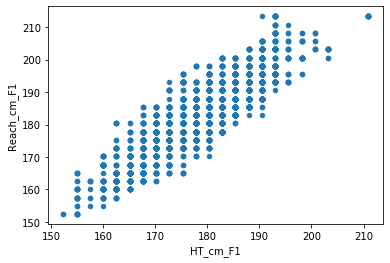

In [ ]:
_ = d.plot('HT_cm_F1','Reach_cm_F1', kind = 'scatter')

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10000, random_state=42, initial_strategy = 'median')
imp.fit(d.loc[:,['HT_cm_F1','Reach_cm_F1','weight_class']])

d[['HT_cm_F1','Reach_cm_F1','weight_class']] = np.round(imp.transform(d[['HT_cm_F1','Reach_cm_F1','weight_class']]))
d[['HT_cm_F2','Reach_cm_F2','weight_class']] = np.round(imp.transform(d[['HT_cm_F2','Reach_cm_F2','weight_class']]))

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='median',
                 max_iter=10000, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=42,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

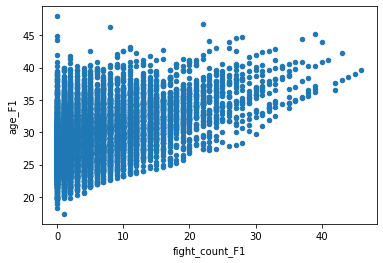

In [ ]:
d.plot('fight_count_F1','age_F1', kind = 'scatter')

In [ ]:
# IMPUTATION WORSENS
# imp.fit(d.loc[:,['fight_count_F1','age_F1']])

# d[['fight_count_F1','age_F1']] = np.round(imp.transform(d[['fight_count_F1','age_F1']]))
# d[['fight_count_F2','age_F2']] = np.round(imp.transform(d[['fight_count_F2','age_F2']]))

In [ ]:
# col_no_next = ['KD_1', 'KD_2', 'SigStr_e_1', 'SigStr_t_1', 'SigStr_e_2', 'SigStr_t_2', 
#                'TotStr_e_1', 'TotStr_t_1', 'TotStr_e_2', 'TotStr_t_2', 'TD_e_1', 'TD_t_1', 
#                'TD_e_2', 'TD_t_2', 'SUB_1', 'SUB_2', 'PASS_1', 'PASS_2', 'REV_1', 'REV_2', 
#                'Head_e_1', 'Head_t_1', 'Head_e_2', 'Head_t_2', 'Body_e_1', 'Body_t_1', 
#                'Body_e_2', 'Body_t_2', 'Leg_e_1', 'Leg_t_1', 'Leg_e_2', 'Leg_t_2', 
#                'Distance_e_1', 'Distance_t_1', 'Distance_e_2', 'Distance_t_2', 
#                'Clinch_e_1', 'Clinch_t_1', 'Clinch_e_2', 'Clinch_t_2', 
#                'Ground_e_1', 'Ground_t_1', 'Ground_e_2', 'Ground_t_2',
#                'fight_time']
               
# col_in_next = ['Stance_F1', 'Stance_F2', 'delta_h', 'delta_r', 
#                'time_avg_F1', 'slpm_avg_F1', 'stracc_avg_F1', 'sapm_avg_F1', 
#                'def_avg_F1', 'td_avg_F1', 'tdacc_avg_F1', 'tddef_avg_F1', 'sub_avg_F1', 
#                'lastfight_F1', 'time_avg_F2', 'slpm_avg_F2', 'stracc_avg_F2', 'sapm_avg_F2', 
#                'def_avg_F2', 'td_avg_F2', 'tdacc_avg_F2', 'tddef_avg_F2',
#                'sub_avg_F2', 'lastfight_F2', 'fight_count_F2', 'Head_perT_1', 'Head_acc_1', 
#                'Head_perT_2', 'Head_acc_2', 'Body_perT_1', 'Body_acc_1', 'Body_perT_2', 'Body_acc_2', 
#                'Leg_perT_1', 'Leg_acc_1', 'Leg_perT_2', 'Leg_acc_2', 'Distance_perT_1', 'Distance_acc_1', 
#                'Distance_perT_2', 'Distance_acc_2', 'Clinch_perT_1', 'Clinch_acc_1',
#                'Clinch_perT_2', 'Clinch_acc_2', 'Ground_perT_1', 'Ground_acc_1',
#                'Ground_perT_2', 'Ground_acc_2', 'PASS_perT_1', 'PASS_perT_2', 'REV_perT_1', 'REV_perT_2', 
#                'KD_perT_1', 'KD_perT_2']

In [ ]:
# r[col_in_next] = r[col_in_next].fillna(r[col_in_next].median())
# r.loc[~r.Result.isna(),col_no_next] = r.loc[~r.Result.isna(),col_no_next].fillna(r.loc[~r.Result.isna(),col_no_next].median())
# r.loc[r.Stance_F1.isna(),'Stance_F1'] = 'Orthodox'
# r.loc[r.Stance_F2.isna(),'Stance_F2'] = 'Orthodox'

''' DO TRY NOT TO IMPUTE, DID NOT SEEM TO HELP LIKE AT ALL'''

' DO TRY NOT TO IMPUTE, DID NOT SEEM TO HELP LIKE AT ALL'

In [ ]:
 def double(df,perc = 1,random_state = 42):
    sample = df.sample(int(df.shape[0]*perc),random_state=random_state)
    rest = df
    
    a = list(sample.loc[:,'Fighter_1':].columns)
    b = [i[:-1]+str(int(i[-1:])*-1+3) if i[-1].isdigit() else i for i in a]
    
    dictionary = dict(zip(a, b))
    sample = sample.rename(columns=dictionary)
    sample.Result = sample.Result*-1+1
    sample.delta_h = sample.delta_h * -1
    sample.delta_r = sample.delta_r * -1
#     sample.delta_w = sample.delta_w * -1
    
    frames = [rest,sample]
    df = pd.concat(frames,sort=False)
    
    return df# double df

In [ ]:
d = double(d)
d = d.sort_index()
d = d.reset_index()

In [ ]:
d.shape
d[d.MID == '0d9e832be918a4e0']

(15054, 166)

,MID,Result,result_str,Date,Method,Round,Time,T_Format,Ref,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,W_F1,L_F1,D_F1,DOB_F1,FID_F1,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,age_F1,age_F2,fight_time,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2,weight_class,pca_0_F1,pca_1_F1,pca_2_F1,pca_3_F1,pca_4_F1,pca_5_F1,pca_0_F2,pca_1_F2,pca_2_F2,pca_3_F2,pca_4_F2,pca_5_F2,method,Stance_F1_Orthodox,Stance_F1_Southpaw,Stance_F1_Switch,Stance_F2_Orthodox,Stance_F2_Southpaw,Stance_F2_Switch,r_method_draw,r_method_ko_1,r_method_ko_2,r_method_md_1,r_method_md_2,r_method_next,r_method_sd_1,r_method_sd_2,r_method_su_1,r_method_su_2,r_method_ud_1,r_method_ud_2
852,0d9e832be918a4e0,0.0,L,2003-03-16,S-DEC,3.0,5:00,3 Rnd (10-5-5),Minoru Toyonaga,Alex Stiebling,Akira Shoji,0.0,1.0,52.0,149.0,29.0,83.0,109.0,207.0,92.0,158.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,8.0,1.0,0.0,39.0,129.0,25.0,74.0,3.0,4.0,0.0,0.0,10.0,16.0,4.0,9.0,42.0,138.0,16.0,54.0,1.0,2.0,0.0,0.0,9.0,9.0,13.0,29.0,18.0,11.0,1.0,NaT,2958.0,14.0,17.0,5.0,1974-01-31,2804.0,188.0,173.0,193.0,178.0,-11.578813,1.010484,0.48189,0.51811,NaN,29.1,20.0,15.24,NaN,17.0,8.0,9.66000,0.959184,0.522222,0.816327,0.493671,0.306122,1.000000,0.647059,0.918367,3.7,5,12.0,12.0,16.56875,0.699248,0.417978,1.251880,0.551213,1.409774,0.735294,0.714286,0.169173,5.5,16,3.367347,0.458333,2.255639,0.343840,0.918367,0.818182,0.413534,0.709677,0.510204,0.714286,0.827068,0.676923,0.714286,0.233333,1.409774,0.344037,0.816327,0.500000,0.300752,0.290909,3.265306,0.727273,1.785714,0.552326,0.306122,1.240602,0.612245,0.056391,0.000000,0.056391,185.0,3.813053,1.335373,1.489461,0.674851,0.695030,0.128623,2.981205,0.544735,0.960062,-0.310489,0.268155,-0.128037,sd_2,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
853,0d9e832be918a4e0,1.0,L,2003-03-16,S-DEC,3.0,5:00,3 Rnd (10-5-5),Minoru Toyonaga,Akira Shoji,Alex Stiebling,1.0,0.0,29.0,83.0,52.0,149.0,92.0,158.0,109.0,207.0,1.0,2.0,0.0,0.0,0.0,1.0,8.0,2.0,0.0,1.0,25.0,74.0,39.0,129.0,0.0,0.0,3.0,4.0,4.0,9.0,10.0,16.0,16.0,54.0,42.0,138.0,0.0,0.0,1.0,2.0,13.0,29.0,9.0,9.0,14.0,17.0,5.0,1974-01-31,2804.0,18.0,11.0,1.0,NaT,2958.0,173.0,188.0,178.0,193.0,1.010484,-11.578813,0.51811,0.48189,29.1,NaN,20.0,-15.24,NaN,12.0,12.0,16.56875,0.699248,0.417978,1.251880,0.551213,1.409774,0.735294,0.714286,0.169173,5.5,16,17.0,8.0,9.66000,0.959184,0.522222,0.816327,0.493671,0.306122,1.000000,0.647059,0.918367,3.7,5,2.255639,0.343840,3.367347,0.458333,0.413534,0.709677,0.918367,0.818182,0.827068,0.676923,0.510204,0.714286,1.409774,0.344037,0.714286,0.233333,0.300752,0.290909,0.816327,0.500000,1.785714,0.552326,3.265306,0.727273,1.240602,0.306122,0.056391,0.612245,0.056391,0.000000,185.0,2.981205,0.544735,0.960062,-0.310489,0.268155,-0.128037,3.813053,1.335373,1.489461,0.674851,0.695030,0.128623,sd_1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
for i in d.index:
    
    if d.loc[i,'Result'] ==1:
        d.loc[i,'r_method'] = d.loc[i,'r_method']+'_1'
    elif d.loc[i,'Result'] ==0:
        d.loc[i,'r_method'] = d.loc[i,'r_method']+'_2'
    elif d.loc[i,'Result'] ==0.5 and d.loc[i,'result_str'] == 'D':
        d.loc[i,'r_method'] = 'draw'
    else:
        pass

In [ ]:
d = d[d.r_method.str.len()>= 4]

In [ ]:
d = d[(d.r_method != 'ot_1')&(d.r_method != 'ot_2')]
d = d.reset_index(drop = True)

In [ ]:
# ATTENTION WEIRD STEP: Due to better performance of softmax, i have to get rid of draws, so I turn one draw event look into 1 and the other into 0 in switching order
draw_ix = d[d.Result == 0.5].index
for i in draw_ix[::2]:
    if d.loc[i,'r_method'] == 'draw' and d.loc[i+1,'r_method'] == 'draw':
        fake = np.random.randint(0,2)
        d.loc[i,'Result'] = fake
        d.loc[i+1,'Result'] = fake

In [ ]:
d['method'] = d.r_method
d = pd.get_dummies(d,columns=['Stance_F1','Stance_F2','r_method'],)

In [ ]:
d = d.drop(['Stance_F1_Sideways','Stance_F2_Sideways','Stance_F1_Open Stance','Stance_F2_Open Stance'],axis =1)

In [ ]:
d[d.FID_F1 == 85.0].sort_values('Date')[['Fighter_1','Date','fight_count_F1','l2d_F1','method','tddef_avg_F1']]

,Fighter_1,Date,fight_count_F1,l2d_F1,method,tddef_avg_F1
12140,Jimmy Ambriz,2005-10-14,0,15.0,ko_2,NaN
464,Jimmy Ambriz,2008-09-23,1,16.0,ko_2,1.0
13347,Jimmy Ambriz,2010-03-22,2,17.0,su_2,1.0


In [ ]:
d[d.Fighter_1 == 'Khabib Nurmagomedov'].sort_values('Date')[['Result','Fighter_1','Fighter_2','Reach_cm_F1','Reach_cm_F2','l2d_F1','w2d_F1','method','delta_r']]

,Result,Fighter_1,Fighter_2,Reach_cm_F1,Reach_cm_F2,l2d_F1,w2d_F1,method,delta_r
7853,1.0,Khabib Nurmagomedov,Kamal Shalorus,178.0,173.0,0.0,16.0,su_1,5.08
13079,1.0,Khabib Nurmagomedov,Gleison Tibau,178.0,180.0,0.0,17.0,ud_1,-2.54
7093,1.0,Khabib Nurmagomedov,Thiago Tavares,178.0,173.0,0.0,18.0,ko_1,5.08
13235,1.0,Khabib Nurmagomedov,Abel Trujillo,178.0,178.0,0.0,19.0,ud_1,0.00
11952,1.0,Khabib Nurmagomedov,Pat Healy,178.0,188.0,0.0,20.0,ud_1,-10.16
9320,1.0,Khabib Nurmagomedov,Rafael Dos Anjos,178.0,178.0,0.0,21.0,ud_1,-0.00
7189,1.0,Khabib Nurmagomedov,Darrell Horcher,178.0,178.0,0.0,22.0,ko_1,-0.00
11442,1.0,Khabib Nurmagomedov,Michael Johnson,178.0,185.0,0.0,23.0,su_1,-7.62
9978,1.0,Khabib Nurmagomedov,Edson Barboza,178.0,190.0,0.0,24.0,ud_1,-12.70
13764,1.0,Khabib Nurmagomedov,Al Iaquinta,178.0,178.0,0.0,25.0,ud_1,0.00


In [ ]:
# NEW BUT WORSE PERFORMANCE
cols_hist = ['Result','KD_1','KD_2','SigStr_e_1', 'SigStr_t_1', 'SigStr_e_2', 'SigStr_t_2', 'TotStr_e_1',
       'TotStr_t_1','TotStr_e_2', 'TotStr_t_2', 'TD_e_1', 'TD_t_1', 'TD_e_2',
       'TD_t_2', 'SUB_1', 'SUB_2', 'PASS_1', 'PASS_2', 'REV_1', 'REV_2',
       'Head_e_1', 'Head_t_1', 'Head_e_2', 'Head_t_2', 'Body_e_1', 'Body_t_1',
       'Body_e_2', 'Body_t_2', 'Leg_e_1', 'Leg_t_1', 'Leg_e_2', 'Leg_t_2',
       'Distance_e_1', 'Distance_t_1', 'Distance_e_2', 'Distance_t_2',
       'Clinch_e_1', 'Clinch_t_1', 'Clinch_e_2', 'Clinch_t_2', 'Ground_e_1',
       'Ground_t_1', 'Ground_e_2', 'Ground_t_2','w2d_F1', 'l2d_F1', 'w2d_F2', 'l2d_F2', 
       'HT_cm_F1','HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2',
       'elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 'age_F1', 'age_F2',
       'fight_time', 'delta_h', 'delta_r','weight_class','fight_count_F1','fight_count_F2',
       'Stance_F1_Orthodox', 'Stance_F1_Southpaw', 'Stance_F1_Switch',
       'Stance_F2_Orthodox', 'Stance_F2_Southpaw', 'Stance_F2_Switch',
       'r_method_draw', 'r_method_ko_1', 'r_method_ko_2', 'r_method_md_1',
       'r_method_md_2', 'r_method_sd_1', 'r_method_sd_2',
       'r_method_su_1', 'r_method_su_2', 'r_method_ud_1', 'r_method_ud_2']

cols_pres = ['HT_cm_F1', 'HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2', 'elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 
       'age_F1','age_F2', 'delta_h', 'delta_r', 'w2d_F1', 'l2d_F1',
       'time_avg_F1', 'slpm_avg_F1', 'stracc_avg_F1', 'sapm_avg_F1',
       'def_avg_F1', 'td_avg_F1', 'tdacc_avg_F1', 'tddef_avg_F1', 'sub_avg_F1',
       'lastfight_F1', 'w2d_F2', 'l2d_F2', 'time_avg_F2', 'slpm_avg_F2',
       'stracc_avg_F2', 'sapm_avg_F2', 'def_avg_F2', 'td_avg_F2',
       'tdacc_avg_F2', 'tddef_avg_F2', 'sub_avg_F2', 'lastfight_F2','fight_count_F1','fight_count_F2',
       'Head_perT_1', 'Head_acc_1', 'Head_perT_2', 'Head_acc_2', 'Body_perT_1',
       'Body_acc_1', 'Body_perT_2', 'Body_acc_2', 'Leg_perT_1', 'Leg_acc_1',
       'Leg_perT_2', 'Leg_acc_2', 'Distance_perT_1', 'Distance_acc_1',
       'Distance_perT_2', 'Distance_acc_2', 'Clinch_perT_1', 'Clinch_acc_1',
       'Clinch_perT_2', 'Clinch_acc_2', 'Ground_perT_1', 'Ground_acc_1',
       'Ground_perT_2', 'Ground_acc_2', 'PASS_perT_1', 'PASS_perT_2',
       'REV_perT_1', 'REV_perT_2', 'KD_perT_1', 'KD_perT_2','weight_class',
       'Stance_F1_Orthodox', 'Stance_F1_Southpaw', 'Stance_F1_Switch',
       'Stance_F2_Orthodox', 'Stance_F2_Southpaw', 'Stance_F2_Switch']

cols_y = ['r_method_draw', 'r_method_ko_1', 'r_method_ko_2', 'r_method_md_1',
       'r_method_md_2', 'r_method_sd_1', 'r_method_sd_2',
       'r_method_su_1', 'r_method_su_2', 'r_method_ud_1', 'r_method_ud_2']

cols_comb = list(set(cols_hist+cols_pres))

In [ ]:
len(cols_hist)
# cols_hist_old = cols_hist.copy()

75

In [ ]:
# # OLD BUT BETTER PERFORMACE - CHECK IF IMPUTATION WAS STUPID
# r.shape
cols_hist = ['Result','KD_1','KD_2','SigStr_e_1', 'SigStr_t_1', 'SigStr_e_2', 'SigStr_t_2', 'TotStr_e_1',
       'TotStr_t_1','TotStr_e_2', 'TotStr_t_2', 'TD_e_1', 'TD_t_1', 'TD_e_2',
       'TD_t_2', 'SUB_1', 'SUB_2', 'PASS_1', 'PASS_2', 'REV_1', 'REV_2',
       'Head_e_1', 'Head_t_1', 'Head_e_2', 'Head_t_2', 'Body_e_1', 'Body_t_1',
       'Body_e_2', 'Body_t_2', 'Leg_e_1', 'Leg_t_1', 'Leg_e_2', 'Leg_t_2',
       'Distance_e_1', 'Distance_t_1', 'Distance_e_2', 'Distance_t_2',
       'Clinch_e_1', 'Clinch_t_1', 'Clinch_e_2', 'Clinch_t_2', 'Ground_e_1',
       'Ground_t_1', 'Ground_e_2', 'Ground_t_2',
       'HT_cm_F1','HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2',# 'WT_lbs_F1', 'WT_lbs_F2',
       'elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 'age_F1', 'age_F2',
       'fight_time', 'delta_h', 'delta_r',
       'Stance_F1_Orthodox', 'Stance_F1_Southpaw', 'Stance_F1_Switch',
       'Stance_F2_Orthodox', 'Stance_F2_Southpaw', 'Stance_F2_Switch',
       'r_method_draw', 'r_method_ko_1', 'r_method_ko_2', 'r_method_md_1',
       'r_method_md_2', 'r_method_sd_1', 'r_method_sd_2',
       'r_method_su_1', 'r_method_su_2', 'r_method_ud_1', 'r_method_ud_2']

# cols_pres = ['HT_cm_F1', 'HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2', #'WT_lbs_F1','WT_lbs_F2', 
#        'elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 'age_F1',
#        'age_F2', 'delta_h', 'delta_r', 'w2d_F1', 'l2d_F1',
#        'time_avg_F1', 'slpm_avg_F1', 'stracc_avg_F1', 'sapm_avg_F1',
#        'def_avg_F1', 'td_avg_F1', 'tdacc_avg_F1', 'tddef_avg_F1', 'sub_avg_F1',
#        'lastfight_F1', 'w2d_F2', 'l2d_F2', 'time_avg_F2', 'slpm_avg_F2',
#        'stracc_avg_F2', 'sapm_avg_F2', 'def_avg_F2', 'td_avg_F2',
#        'tdacc_avg_F2', 'tddef_avg_F2', 'sub_avg_F2', 'lastfight_F2',
#        'Head_perT_1', 'Head_acc_1', 'Head_perT_2', 'Head_acc_2', 'Body_perT_1',
#        'Body_acc_1', 'Body_perT_2', 'Body_acc_2', 'Leg_perT_1', 'Leg_acc_1',
#        'Leg_perT_2', 'Leg_acc_2', 'Distance_perT_1', 'Distance_acc_1',
#        'Distance_perT_2', 'Distance_acc_2', 'Clinch_perT_1', 'Clinch_acc_1',
#        'Clinch_perT_2', 'Clinch_acc_2', 'Ground_perT_1', 'Ground_acc_1',
#        'Ground_perT_2', 'Ground_acc_2', 'PASS_perT_1', 'PASS_perT_2',
#        'REV_perT_1', 'REV_perT_2', 'KD_perT_1', 'KD_perT_2',
#        'Stance_F1_Orthodox', 'Stance_F1_Southpaw', 'Stance_F1_Switch',
#        'Stance_F2_Orthodox', 'Stance_F2_Southpaw', 'Stance_F2_Switch']

# cols_y = ['r_method_draw', 'r_method_ko_1', 'r_method_ko_2', 'r_method_md_1',
#        'r_method_md_2', 'r_method_sd_1', 'r_method_sd_2',
#        'r_method_su_1', 'r_method_su_2', 'r_method_ud_1', 'r_method_ud_2']

# cols_comb = list(set(cols_hist+cols_pres))

In [ ]:
# r[r.Fighter_1 == 'Khabib Nurmagomedov']

In [ ]:
r = d.copy()

In [ ]:
# Normalize data
x = r.loc[:,cols_comb].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
r.loc[:,cols_comb] = pd.DataFrame(x_scaled,columns=r.loc[:,cols_comb].columns, index= r.loc[:,cols_comb].index) 
del x, x_scaled

In [ ]:
max_shape = int(r.FID_F1.value_counts().max())
max_shape
int(r.FID_F1.value_counts().mean())

46

5

##### Get DF with concatenated histories of both fighters incl. Results

In [ ]:
def history(r,fid, mdate):
    sub = r[(r.FID_F1 == fid)&(r.Date < mdate)].sort_values('Date')
    return sub

In [ ]:
def tot_history(r,fid, mdate, train_cols):
    sub = r[(r.FID_F1 == fid)&(r.Date < mdate)].sort_values('Date',ascending = False)
    return sub.loc[:,train_cols].reset_index().drop('index',axis=1).fillna(0),sub.shape[0]

In [ ]:
def padding(combi,max_shape):
    
    if combi.shape[0] > max_shape:
        combi = combi.iloc[:max_shape,:]
    else:
        while combi.shape[0] < max_shape: # get everythin to same max size
            combi = combi.append(pd.Series(), ignore_index=True)

    return combi.iloc[::-1].reset_index().drop('index',axis =1).fillna(0)

In [ ]:
# get df with all the stuff 1 per fighter
store = pd.DataFrame(columns=['MID','Result','result_str','method','Fighter_1','Fighter_2'])

x1,val = tot_history(r,r.loc[0,'FID_F1'],r.loc[0,'Date'],cols_hist)
x2,val = tot_history(r,r.loc[0,'FID_F2'],r.loc[0,'Date'],cols_hist)

combi = pd.concat([x1,x2],axis=1)
combi = padding(combi,max_shape)
pres = r.loc[0,cols_pres].fillna(0)

y = np.array([[r.loc[0,'Result'],r.loc[0,cols_y].to_numpy()]])
X = np.array([[combi.to_numpy(),pres.to_numpy()]])
store = store.append(r.loc[0,['MID','Result','result_str','method','Fighter_1','Fighter_2']])

c = 1
for i in tqdm(r.index[1:]):
    x1,val1 = tot_history(r,r.loc[i,'FID_F1'],r.loc[i,'Date'],cols_hist)
    x2,val2 = tot_history(r,r.loc[i,'FID_F2'],r.loc[i,'Date'],cols_hist)

#     if (val1 != 0) & (val2 != 0): # makes sure to only keep track of fighters, who have both faught before
        
    combi = pd.concat([x1,x2],axis=1)
    combi = padding(combi,max_shape)
    pres = r.loc[i,cols_pres].fillna(0)

    y = np.vstack((y,np.array([[r.loc[i,'Result'],r.loc[i,cols_y].to_numpy()]])))
    X = np.vstack((X,np.array([[combi.to_numpy(),pres.to_numpy()]]))) 
    store = store.append(r.loc[i,['MID','Result','result_str','method','Fighter_1','Fighter_2']])
    c+=1

100%|████████████████████████████████████████████████████████████████████████████| 15053/15053 [23:43<00:00, 10.57it/s]


In [ ]:
np.save(f'{date}_X_vals_reach_imp_shot_Xhist.npy',X)
np.save(f'{date}_y_vals_reach_imp_shot_Xhist.npy',y)
store.to_csv(f'{date}_store_vals.csv')

In [ ]:
X.shape
y.shape
# X[10203][0]
X[:,0].shape
X[:,1].shape
X[:,0][0].shape
X[:,1][100].shape
cn = 12282

assert (pd.DataFrame([X[:,1][cn]],columns = cols_pres)['eloprob_F2'].values == r.loc[[cn],'eloprob_F2'].values)[0]
    
assert pd.DataFrame(X[:,0][cn],columns = cols_hist*2).tail(1).iloc[:,0:len(cols_hist)].reset_index(drop=True)\
.equals(history(r,r.loc[cn,'FID_F1'],r.loc[cn,'Date']).tail(1).loc[:,cols_hist].reset_index(drop=True))
    
assert pd.DataFrame(X[:,0][cn],columns = cols_hist*2).tail(1).iloc[:,len(cols_hist):].reset_index(drop=True)\
.equals(history(r,r.loc[cn,'FID_F2'],r.loc[cn,'Date']).tail(1).loc[:,cols_hist].reset_index(drop=True))


(15054, 2)

(15054, 2)

(15054,)

(15054,)

(46, 150)

(75,)

##### Model Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# y = np.load(f'{date}_y_vals_reach_imp.npy',allow_pickle=True)
# X = np.load(f'{date}_X_vals_reach_imp.npy',allow_pickle=True)

In [ ]:
def xsplit(x):
    xh = np.concatenate(x[:,0]).reshape((x.shape[0],x[0][0].shape[0],x[0][0].shape[1]))
    xp = np.concatenate(x[:,1]).reshape((x[:,1].shape[0],x[:,1][0].shape[0]))
    return xh,xp

X_hist, X_pres = xsplit(X)

In [ ]:
def ysplit(y):
    yl = np.concatenate(y[:,1]).reshape((y[:,1].shape[0],y[:,1][0].shape[0]))
    ys = y[:,0]
    return yl.astype(float), ys.astype(float)

y_long, y_shot = ysplit(y)    

In [ ]:
# get random sample to predict
import random
num_test = 2000
random.seed(42)
testlist = random.sample(range(0, y_shot[~np.isnan(y_shot)].shape[0]), num_test)
restlist = list(set(range(y_shot[~np.isnan(y_shot)].shape[0]))-set(testlist))
predlist = np.ix_(np.isnan(y_shot))[0].tolist()

In [ ]:
y_shot_test = y_shot[testlist]
y_long_test = y_long[testlist]
X_hist_test = X_hist[testlist]
X_pres_test = X_pres[testlist]

y_shot_train = y_shot[restlist]
y_long_train = y_long[restlist]
X_hist_train = X_hist[restlist]
X_pres_train = X_pres[restlist]

X_hist_pred = X_hist[predlist]
X_pres_pred = X_pres[predlist]

In [ ]:
X_pres_test.shape
X_pres_train.shape
X_pres_pred.shape


(2000, 75)

(12966, 75)

(88, 75)

In [ ]:
# X_train_hist.shape;X_train_pres.shape;X_pred_hist.shape;X_test_pres.shape
assert X.shape[0] == X_hist_pred.shape[0] + X_hist_train.shape[0] +X_hist_test.shape[0]
assert (np.array(r.loc[testlist].Result) == y_shot_test).all()
assert (np.array(r.loc[restlist].Result) == y_shot_train).all()
assert (X_pres_test == np.nan_to_num(r.loc[testlist,cols_pres].values)).all()
assert (X_pres_train == np.nan_to_num(r.loc[restlist,cols_pres].values)).all()
assert (X_pres_pred == np.nan_to_num(r.loc[predlist,cols_pres].values)).all()
assert X_hist_train[0][0].std() == 0 and X_hist_train[0][-1].std() != 0

In [ ]:
y_shot_test = to_categorical(y_shot_test) # ATTENTION DOES NOT WORK FOR DRAWS DUE TO ROUNDING
y_shot_train = to_categorical(y_shot_train)
# y_long_test = tf.convert_to_tensor(y_long_test,dtype = np.float32)
# y_long_train = tf.convert_to_tensor(y_long_train,dtype = np.float32

In [ ]:
# Better top 0 bottom with info 
# X_train = np.flip(X_train, 1)
# X_test = np.flip(X_test,1)

##### Build complex Model




In [ ]:
# log_cols = ['lstm_shape','main_shape','drop','learn','batch_size','loss_weight','min_loss','max_acc']
# log = pd.DataFrame(columns = log_cols)
# log_path = f'./tuning/{date}_logfile_combi_model.csv'
# log.to_csv(log_path, index = False)

In [ ]:
# visualizing losses and accuracy trained with lstm_shape = 16 and opt = Adam
def plot_hist(hist,value):
    train = hist.history[value]
    val   = hist.history['val_'+value]
    xc         = range(len(train))


    _ = plt.figure()
    _ = plt.plot(xc, train)
    _ = plt.plot(xc, val)
#     print('Min Val-Loss:',np.array(hist.history['val_loss']).min().round(3), '\nMax Val-Acc:',np.array(hist.history['val_accuracy']).max().round(3))

In [ ]:
def get_model():
    hist_input = Input(shape=(X_hist_train.shape[1:]), name='hist_input')
    
    print(main_shape,lstm_shape,loss_weight,drop,learn)

    lstm_out = LSTM(lstm_shape,dropout= drop,return_sequences = False)(hist_input)
#     lstm_out = LSTM(lstm_shape,dropout= drop,return_sequences = False)(lstm_out)

    l = Dense(lstm_shape)(lstm_out)
    l = Dropout(drop)(l)
    method_output = Dense(y_long_train.shape[1],activation = 'softmax', name='method_output')(l)

    pres_input = Input(shape=(X_pres_train.shape[1]), name='pres_input')

    l = concatenate([l, pres_input])
    l = Dense(main_shape, activation='relu')(l)
    l = Dropout(drop)(l)
    l = Dense(main_shape, activation='relu')(l)
    l = Dropout(drop)(l)
    l = Dense(main_shape, activation='relu')(l)
    l = Dropout(drop)(l)

    main_output = Dense(y_shot_train.shape[1],activation = 'softmax', name='main_output')(l)
#     main_output = Dense(1,activation = 'sigmoid', name='main_output')(l)


    model = Model(inputs=[hist_input, pres_input], outputs=[main_output, method_output])
    
    model.compile(optimizer= opt,
                  loss={'main_output': 'binary_crossentropy', 'method_output': 'categorical_crossentropy'},
                  loss_weights={'main_output': loss_weight, 'method_output': 1-loss_weight},
                  metrics = ['accuracy'])


    
    return model

In [ ]:
X_hist_train.shape
X_pres_train.shape
X_hist_test.shape
X_pres_test.shape
y_long_train.shape
y_shot_train.shape

(12966, 46, 150)

(12966, 75)

(2000, 46, 150)

(2000, 75)

(12966, 11)

(12966, 2)

In [ ]:
# Params:
lstm_shape = 10
main_shape = 16
drop = 0.2
learn = 0.95
rho = 0.95
epochs = 100
batch_size = 64
opt = optimizers.Adadelta(learning_rate=learn, rho=rho)
loss_weight = 0.8
es = EarlyStopping(monitor='val_main_output_loss', mode='min', verbose=1, patience=10)
es = EarlyStopping(monitor='main_output_loss', mode='min', verbose=1, patience=4)


model = get_model()

history = model.fit([X_hist_train, X_pres_train], 
                                  [y_shot_train, y_long_train], 
                                  validation_data = ([X_hist_test,X_pres_test],[y_shot_test,y_long_test]),
                                  epochs=epochs, 
                                  batch_size=batch_size,
                                  use_multiprocessing = True,
                                  callbacks=[es])

16 10 0.8 0.2 0.95
Train on 12966 samples, validate on 2000 samples
Epoch 1/100
12966/12966 [==============================] - 7s 542us/sample - loss: 0.9799 - main_output_loss: 0.6877 - method_output_loss: 2.1488 - main_output_accuracy: 0.5506 - method_output_accuracy: 0.1741 - val_loss: 0.9509 - val_main_output_loss: 0.6761 - val_method_output_loss: 2.0532 - val_main_output_accuracy: 0.5760 - val_method_output_accuracy: 0.1950
Epoch 2/100
12966/12966 [==============================] - 4s 340us/sample - loss: 0.9500 - main_output_loss: 0.6772 - method_output_loss: 2.0407 - main_output_accuracy: 0.5709 - method_output_accuracy: 0.2080 - val_loss: 0.9378 - val_main_output_loss: 0.6666 - val_method_output_loss: 2.0188 - val_main_output_accuracy: 0.5860 - val_method_output_accuracy: 0.2175
Epoch 3/100
12966/12966 [==============================] - 5s 351us/sample - loss: 0.9356 - main_output_loss: 0.6666 - method_output_loss: 2.0118 - main_output_accuracy: 0.5952 - method_output_accuracy:

Epoch 23/100
12966/12966 [==============================] - 4s 343us/sample - loss: 0.8843 - main_output_loss: 0.6232 - method_output_loss: 1.9287 - main_output_accuracy: 0.6452 - method_output_accuracy: 0.2694 - val_loss: 0.9025 - val_main_output_loss: 0.6402 - val_method_output_loss: 1.9454 - val_main_output_accuracy: 0.6130 - val_method_output_accuracy: 0.2650
Epoch 24/100
12966/12966 [==============================] - 4s 343us/sample - loss: 0.8822 - main_output_loss: 0.6208 - method_output_loss: 1.9279 - main_output_accuracy: 0.6487 - method_output_accuracy: 0.2726 - val_loss: 0.8921 - val_main_output_loss: 0.6281 - val_method_output_loss: 1.9391 - val_main_output_accuracy: 0.6255 - val_method_output_accuracy: 0.2635
Epoch 25/100
12966/12966 [==============================] - 4s 338us/sample - loss: 0.8811 - main_output_loss: 0.6199 - method_output_loss: 1.9251 - main_output_accuracy: 0.6465 - method_output_accuracy: 0.2736 - val_loss: 0.8945 - val_main_output_loss: 0.6300 - val_m

In [ ]:
history = model.fit([X_hist_train, X_pres_train], 
                                  [y_shot_train, y_long_train], 
                                  validation_data = ([X_hist_test,X_pres_test],[y_shot_test,y_long_test]),
                                  epochs=epochs, 
                                  batch_size=batch_size,
                                  use_multiprocessing = True,
                                  callbacks=[es])

Train on 11966 samples, validate on 3000 samples
Epoch 1/100
11966/11966 [==============================] - 4s 350us/sample - loss: 0.8680 - main_output_loss: 0.6039 - method_output_loss: 1.9246 - main_output_accuracy: 0.6590 - method_output_accuracy: 0.2718 - val_loss: 0.8890 - val_main_output_loss: 0.6257 - val_method_output_loss: 1.9431 - val_main_output_accuracy: 0.6377 - val_method_output_accuracy: 0.2677
Epoch 2/100
11966/11966 [==============================] - 4s 344us/sample - loss: 0.8709 - main_output_loss: 0.6065 - method_output_loss: 1.9281 - main_output_accuracy: 0.6626 - method_output_accuracy: 0.2693 - val_loss: 0.8849 - val_main_output_loss: 0.6223 - val_method_output_loss: 1.9356 - val_main_output_accuracy: 0.6367 - val_method_output_accuracy: 0.2677
Epoch 3/100
11966/11966 [==============================] - 4s 342us/sample - loss: 0.8683 - main_output_loss: 0.6045 - method_output_loss: 1.9238 - main_output_accuracy: 0.6584 - method_output_accuracy: 0.2696 - val_loss:

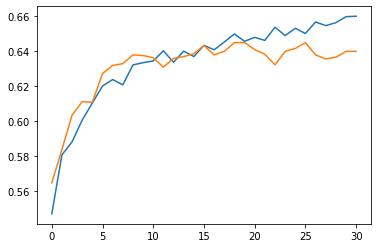

In [ ]:
plot_hist(history,'main_output_accuracy')

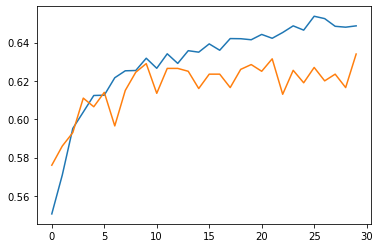

In [ ]:
plot_hist(history,'main_output_accuracy')

32 8 0.8 0.3 1
Train on 13966 samples, validate on 1000 samples
Epoch 1/100
13966/13966 [==============================] - 6s 457us/sample - loss: 0.9760 - main_output_loss: 0.6882 - method_output_loss: 2.1278 - main_output_accuracy: 0.5437 - method_output_accuracy: 0.1766 - val_loss: 0.9485 - val_main_output_loss: 0.6743 - val_method_output_loss: 2.0403 - val_main_output_accuracy: 0.5950 - val_method_output_accuracy: 0.2140
Epoch 2/100
13966/13966 [==============================] - 4s 285us/sample - loss: 0.9479 - main_output_loss: 0.6754 - method_output_loss: 2.0383 - main_output_accuracy: 0.5762 - method_output_accuracy: 0.2042 - val_loss: 0.9300 - val_main_output_loss: 0.6606 - val_method_output_loss: 2.0003 - val_main_output_accuracy: 0.6190 - val_method_output_accuracy: 0.2320
Epoch 3/100
13966/13966 [==============================] - 4s 289us/sample - loss: 0.9350 - main_output_loss: 0.6653 - method_output_loss: 2.0139 - main_output_accuracy: 0.5992 - method_output_accuracy: 0.2

13966/13966 [==============================] - 4s 298us/sample - loss: 1.2181 - main_output_loss: 0.6755 - method_output_loss: 2.0324 - main_output_accuracy: 0.5703 - method_output_accuracy: 0.2061 - val_loss: 1.2023 - val_main_output_loss: 0.6599 - val_method_output_loss: 2.0079 - val_main_output_accuracy: 0.6060 - val_method_output_accuracy: 0.2490
Epoch 3/100
13966/13966 [==============================] - 4s 285us/sample - loss: 1.1991 - main_output_loss: 0.6614 - method_output_loss: 2.0057 - main_output_accuracy: 0.5950 - method_output_accuracy: 0.2286 - val_loss: 1.1920 - val_main_output_loss: 0.6527 - val_method_output_loss: 1.9935 - val_main_output_accuracy: 0.6160 - val_method_output_accuracy: 0.2450
Epoch 4/100
13966/13966 [==============================] - 4s 290us/sample - loss: 1.1923 - main_output_loss: 0.6568 - method_output_loss: 1.9955 - main_output_accuracy: 0.6104 - method_output_accuracy: 0.2339 - val_loss: 1.1841 - val_main_output_loss: 0.6470 - val_method_output_lo

13966/13966 [==============================] - 5s 369us/sample - loss: 1.1254 - main_output_loss: 0.6018 - method_output_loss: 1.9100 - main_output_accuracy: 0.6661 - method_output_accuracy: 0.2758 - val_loss: 1.1447 - val_main_output_loss: 0.6144 - val_method_output_loss: 1.9256 - val_main_output_accuracy: 0.6510 - val_method_output_accuracy: 0.2910
Epoch 47/100
13966/13966 [==============================] - 5s 334us/sample - loss: 1.1239 - main_output_loss: 0.5997 - method_output_loss: 1.9097 - main_output_accuracy: 0.6685 - method_output_accuracy: 0.2777 - val_loss: 1.1545 - val_main_output_loss: 0.6295 - val_method_output_loss: 1.9291 - val_main_output_accuracy: 0.6410 - val_method_output_accuracy: 0.2740
Epoch 48/100
13966/13966 [==============================] - 5s 333us/sample - loss: 1.1245 - main_output_loss: 0.6018 - method_output_loss: 1.9083 - main_output_accuracy: 0.6707 - method_output_accuracy: 0.2828 - val_loss: 1.1542 - val_main_output_loss: 0.6258 - val_method_output_

13966/13966 [==============================] - 2s 133us/sample - loss: 0.8735 - main_output_loss: 0.6094 - method_output_loss: 1.9314 - main_output_accuracy: 0.6544 - method_output_accuracy: 0.2723 - val_loss: 0.8910 - val_main_output_loss: 0.6264 - val_method_output_loss: 1.9461 - val_main_output_accuracy: 0.6500 - val_method_output_accuracy: 0.2630
Epoch 35/100
13966/13966 [==============================] - 2s 131us/sample - loss: 0.8722 - main_output_loss: 0.6087 - method_output_loss: 1.9301 - main_output_accuracy: 0.6591 - method_output_accuracy: 0.2740 - val_loss: 0.8857 - val_main_output_loss: 0.6208 - val_method_output_loss: 1.9452 - val_main_output_accuracy: 0.6450 - val_method_output_accuracy: 0.2640
Epoch 36/100
13966/13966 [==============================] - 2s 125us/sample - loss: 0.8712 - main_output_loss: 0.6059 - method_output_loss: 1.9302 - main_output_accuracy: 0.6605 - method_output_accuracy: 0.2727 - val_loss: 0.9015 - val_main_output_loss: 0.6399 - val_method_output_

KeyboardInterrupt: 

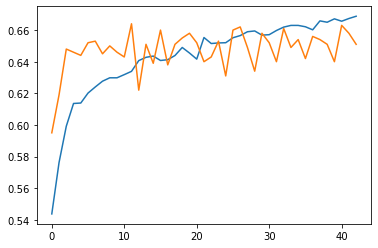

Error in callback <function flush_figures at 0x000001B7E5C78318> (for post_execute):


KeyboardInterrupt: 

In [ ]:
c = 0
es = EarlyStopping(monitor='val_main_output_loss', mode='min', verbose=1, patience=10)

for lstm_shape in [8,16,24,32]:
    for main_shape in [32,16]:
        for drop in [0.3,0.4]:
            for learn in [1,0.9]:
                for batch_size in [32,64]:
                    for loss_weight in [0.8,0.6]:
                        X_shape = 27
                        X_hist_test_2 = X_hist_test[:,X_shape:,:]
                        X_hist_train_2 = X_hist_train[:,X_shape:,:]

                        # opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
                        opt = optimizers.Adadelta(learning_rate=learn, rho=rho)

                        model = get_model()
                        
                        model.compile(optimizer= opt,
                                  loss={'main_output': 'binary_crossentropy', 'method_output': 'categorical_crossentropy'},
                                  loss_weights={'main_output': loss_weight, 'method_output': 1-loss_weight},
                                  metrics = ['accuracy'])
                        
                        history = model.fit([X_hist_train_2, X_pres_train], 
                                  [y_shot_train, y_long_train], 
                                  validation_data = ([X_hist_test_2,X_pres_test],[y_shot_test,y_long_test]),
                                  epochs=epochs, 
                                  batch_size=batch_size,
                                  use_multiprocessing = True,
                                  callbacks=[es])

                        plot_hist(history,'main_output_accuracy')
                        plt.savefig(f'./tuning/{c:03d}_history.png')
                        
                        vals = [[lstm_shape,main_shape,drop,learn,batch_size,loss_weight,np.array(history.history['val_main_output_loss']).min(),np.array(history.history['val_main_output_accuracy']).max()]]
                        log = pd.DataFrame(vals,columns = log_cols)
                        log.to_csv(log_path,index = False, mode = 'a+',header = False)
                        c +=1

In [ ]:
y_shot_train.shape[0]

13966

In [ ]:
log = pd.read_csv(log_path)

In [ ]:
log.columns

Index(['lstm_shape', 'main_shape', 'drop', 'learn', 'batch_size',
       'loss_weight', 'min_loss', 'max_acc'],
      dtype='object')

In [ ]:
log.groupby(['main_shape'])['min_loss'].mean()

main_shape
16    0.617608
Name: min_loss, dtype: float64

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hist_input (InputLayer)         [(None, 19, 164)]    0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 8)            5536        hist_input[0][0]                 
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 8)            72          lstm_18[0][0]                    
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 8)            0           dense_72[0][0]                   
___________________________________________________________________________________________

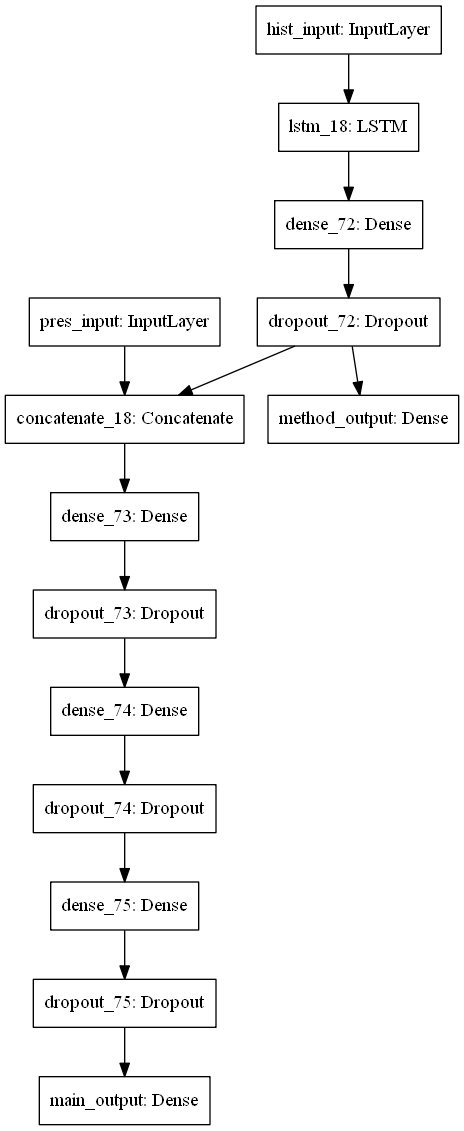

In [ ]:
print(model.summary())
plot_model(model,to_file='./tuning/tune_model_lin_imp.png')

##### Simple LSTM

In [ ]:
X_hist_train.shape

(12966, 46, 164)

In [ ]:
lstm_shape = 12
drop = 0.2

# opt = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt = optimizers.Adadelta(learning_rate=1.0, rho=0.9)


model = Sequential()

model.add(LSTM(lstm_shape, input_shape = (X_hist_train.shape[1:]), return_sequences=False))
model.add(Dropout(drop))
model.add(Dense(lstm_shape,activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(lstm_shape,activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(y_shot_train.shape[1],activation = 'softmax'))

model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy'])

hist = model.fit(X_hist_train, y_shot_train, epochs=30, validation_data = (X_hist_test,y_shot_test), shuffle = True)

# ar = np.hstack((lstm_shape,drop,model.evaluate(X_test,y_test)))
# log = log.append(pd.Series(ar,index =  ['lstm_shape','drop','loss','acc']),ignore_index=True,sort = False)
# log.to_csv('2020-03-11_logfile_LSTM.csv')

Train on 12966 samples, validate on 2000 samples
Epoch 1/30
12966/12966 [==============================] - 6s 482us/sample - loss: 0.6843 - accuracy: 0.5514 - val_loss: 0.6739 - val_accuracy: 0.5735
Epoch 2/30
12966/12966 [==============================] - 3s 230us/sample - loss: 0.6674 - accuracy: 0.5950 - val_loss: 0.6580 - val_accuracy: 0.5985
Epoch 3/30
12966/12966 [==============================] - 6s 440us/sample - loss: 0.6563 - accuracy: 0.6111 - val_loss: 0.6515 - val_accuracy: 0.6030
Epoch 4/30
12966/12966 [==============================] - 6s 466us/sample - loss: 0.6500 - accuracy: 0.6165 - val_loss: 0.6504 - val_accuracy: 0.6150
Epoch 5/30
12966/12966 [==============================] - 6s 480us/sample - loss: 0.6484 - accuracy: 0.6203 - val_loss: 0.6490 - val_accuracy: 0.6180
Epoch 6/30
12966/12966 [==============================] - 6s 481us/sample - loss: 0.6463 - accuracy: 0.6208 - val_loss: 0.6443 - val_accuracy: 0.6150
Epoch 7/30
12966/12966 [===========================

##### Add XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import log_loss,accuracy_score,roc_curve,roc_auc_score

In [ ]:
def dataframe_prep(d):
#     d = random_switch(df,0.3,top+1)
#     d = pd.get_dummies(df, drop_first = True, columns = ['Stance_F1','Stance_F2'])
#     d = d[d.Result != 0.5].drop(['method','fight_time','MID'],axis=1)
    d = d.drop(['method','fight_time','MID'],axis=1)

    d.drop(d.loc[:,'result_str':'FID_F2'].columns,axis= 1,inplace= True)
    d.drop(d.loc[:,'r_method_draw':'r_method_ud_2'].columns,axis=1,inplace=True)
    d.drop(d.select_dtypes(include = 'object').columns, axis = 1,inplace=True)
#     d = d.sample(frac=1)
    return d['Result'],d.drop('Result', axis = 1)

In [ ]:
by, bX = dataframe_prep(d)

In [ ]:
assert bX.shape[0] == X_hist.shape[0]
assert by.shape[0] == d.shape[0]
assert (np.nan_to_num(by.values) ==  np.nan_to_num(y_shot)).all()

In [ ]:
by_train = by[restlist]
by_test = by[testlist]
bX_train = bX.values[restlist]
bX_test = bX.values[testlist]
bX_pred = bX.values[predlist]
# = bX[restlist]
# bX_test = bX[testlist]

In [ ]:
assert (by_train.values == y_shot_train[:,1]).all()
assert (by_test.values == y_shot_test[:,1]).all()
assert bX.shape[0] == (bX_train.shape[0]+bX_test.shape[0]+bX_pred.shape[0])

In [ ]:
xg_reg = xgb.XGBRegressor(objectiv6e ='binary:logistic', colsample_bytree= 0.3, learning_rate = 0.01,
                max_depth = 6,  n_estimators = 900)
model = xg_reg.fit(bX_train,by_train)

[10:28:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test_p = xg_reg.predict(bX_test)
logloss = log_loss(by_test, test_p, eps=1e-15)
auc_holdout = roc_auc_score(by_test, test_p)

In [ ]:
accuracy_score(by_test, test_p.round(), normalize=True)

0.657

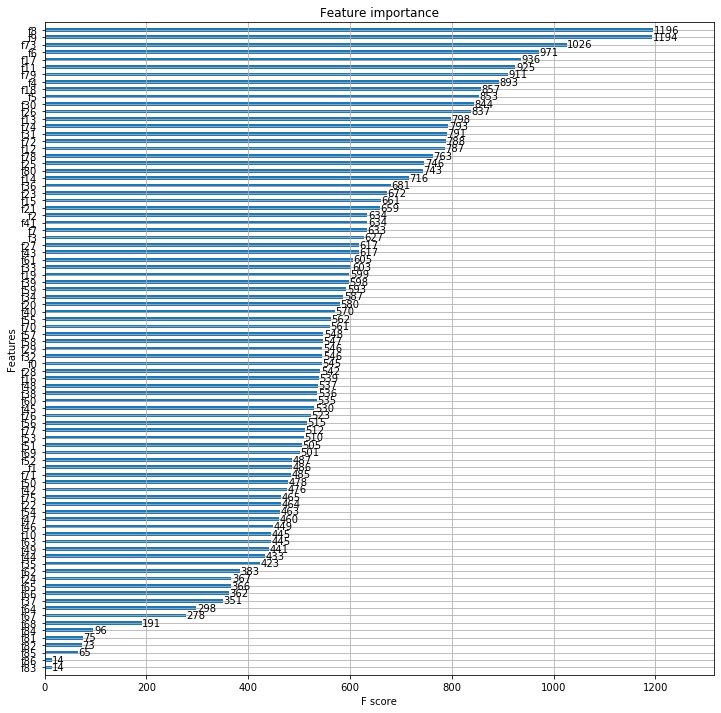

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
_ = xgb.plot_importance(model, height=0.5, ax=ax)
_ = plt.show()

##### Deprecated

In [ ]:
log_cols = ['lstm_shape','drop','optimizer','learn','rho','X_shape','min_loss','max_acc']
log = pd.DataFrame(columns = log_cols)
log.to_csv('2020-03-13_logfile_LSTM.csv', index = False)

In [ ]:
# Extreme complete Grid Search
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

for lstm_shape in [6,9,11,20,32]:
    for drop in [0.1,0.2,0.3]:
        optimizer = 'Adadelta'
        for learn in [0.9,1,1.1]:
            for rho in [0.85,0.9,0.95]:
                for X_shape in [40,30,20,10]:
                    Xtest = X_test[:,X_shape:,:]
                    Xtrain = X_train[:,X_shape:,:]
                    
                    # opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
                    opt = optimizers.Adadelta(learning_rate=learn, rho=rho)

                    model = Sequential()

                    model.add(LSTM(lstm_shape, input_shape = (Xtrain.shape[1:]), return_sequences=False,activation = 'relu'))
                    model.add(Dropout(drop))
                    model.add(Dense(lstm_shape,activation = 'relu'))
                    model.add(Dropout(drop))
                    model.add(Dense(y_train.shape[1],activation = 'softmax'))

                    # model.add(LSTM(lstm_shape, input_shape = (X_train.shape[1:]), return_sequences=True))
                    # model.add(Dropout(drop))
                    # model.add(LSTM(lstm_shape, return_sequences = False))
                    # model.add(Dropout(drop))
                    # model.add(Dense(lstm_shape,activation = 'relu'))
                    # model.add(Dropout(drop))
                    # model.add(Dense(y_train.shape[1],activation = 'softmax'))

                    model.compile(loss = 'binary_crossentropy', optimizer= opt,metrics = ['accuracy'])

                    hist = model.fit(Xtrain, y_train, epochs=110, batch_size=60, validation_data = (Xtest,y_test),shuffle = True,callbacks=[es])

                    vals = [[lstm_shape,drop,optimizer,learn,rho,str(X_train[:,X_shape:,:].shape),np.array(hist.history['val_loss']).min(),np.array(hist.history['val_accuracy']).max()]]
                    log = pd.DataFrame(vals,columns = log_cols)
                    log.to_csv(f'{date}_logfile_old_run.csv',index = False, mode = 'a+',header = False)

Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6917 - accuracy: 0.5315 - val_loss: 0.6908 - val_accuracy: 0.5280
Epoch 2/110
9340/9340 [==============================] - 2s 230us/sample - loss: 0.6892 - accuracy: 0.5388 - val_loss: 0.6841 - val_accuracy: 0.5710
Epoch 3/110
9340/9340 [==============================] - 2s 244us/sample - loss: 0.6833 - accuracy: 0.5605 - val_loss: 0.6774 - val_accuracy: 0.5710
Epoch 4/110
9340/9340 [==============================] - 2s 247us/sample - loss: 0.6784 - accuracy: 0.5601 - val_loss: 0.6715 - val_accuracy: 0.5820
Epoch 5/110
9340/9340 [==============================] - 2s 233us/sample - loss: 0.6713 - accuracy: 0.5749 - val_loss: 0.6692 - val_accuracy: 0.5890
Epoch 6/110
9340/9340 [==============================] - 2s 246us/sample - loss: 0.6685 - accuracy: 0.5862 - val_loss: 0.6608 - val_accuracy: 0.5930
Epoch 7/110
9340/9340 [==============================] - 2

9340/9340 [==============================] - 3s 351us/sample - loss: 0.6142 - accuracy: 0.6599 - val_loss: 0.6302 - val_accuracy: 0.6440
Epoch 39/110
9340/9340 [==============================] - 3s 351us/sample - loss: 0.6148 - accuracy: 0.6626 - val_loss: 0.6308 - val_accuracy: 0.6490
Epoch 40/110
9340/9340 [==============================] - 3s 354us/sample - loss: 0.6157 - accuracy: 0.6636 - val_loss: 0.6255 - val_accuracy: 0.6410
Epoch 41/110
9340/9340 [==============================] - 3s 343us/sample - loss: 0.6128 - accuracy: 0.6606 - val_loss: 0.6217 - val_accuracy: 0.6440
Epoch 42/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6112 - accuracy: 0.6702 - val_loss: 0.6256 - val_accuracy: 0.6440
Epoch 43/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6102 - accuracy: 0.6685 - val_loss: 0.6222 - val_accuracy: 0.6450
Epoch 44/110
9340/9340 [==============================] - 3s 352us/sample - loss: 0.6103 - accuracy: 0.6622 - val

9340/9340 [==============================] - 5s 577us/sample - loss: 0.6209 - accuracy: 0.6560 - val_loss: 0.6257 - val_accuracy: 0.6400
Epoch 38/110
9340/9340 [==============================] - 6s 595us/sample - loss: 0.6208 - accuracy: 0.6546 - val_loss: 0.6242 - val_accuracy: 0.6320
Epoch 39/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6189 - accuracy: 0.6600 - val_loss: 0.6203 - val_accuracy: 0.6440
Epoch 40/110
9340/9340 [==============================] - 5s 578us/sample - loss: 0.6201 - accuracy: 0.6565 - val_loss: 0.6234 - val_accuracy: 0.6410
Epoch 41/110
9340/9340 [==============================] - 5s 543us/sample - loss: 0.6169 - accuracy: 0.6609 - val_loss: 0.6330 - val_accuracy: 0.6300
Epoch 42/110
9340/9340 [==============================] - 5s 559us/sample - loss: 0.6175 - accuracy: 0.6549 - val_loss: 0.6221 - val_accuracy: 0.6450
Epoch 43/110
9340/9340 [==============================] - 5s 574us/sample - loss: 0.6146 - accuracy: 0.6637 - val

9340/9340 [==============================] - 3s 349us/sample - loss: 0.6115 - accuracy: 0.6592 - val_loss: 0.6253 - val_accuracy: 0.6600
Epoch 35/110
9340/9340 [==============================] - 4s 377us/sample - loss: 0.6139 - accuracy: 0.6627 - val_loss: 0.6323 - val_accuracy: 0.6400
Epoch 36/110
9340/9340 [==============================] - 3s 345us/sample - loss: 0.6113 - accuracy: 0.6607 - val_loss: 0.6249 - val_accuracy: 0.6630
Epoch 37/110
9340/9340 [==============================] - 3s 348us/sample - loss: 0.6098 - accuracy: 0.6669 - val_loss: 0.6263 - val_accuracy: 0.6540
Epoch 38/110
9340/9340 [==============================] - 3s 362us/sample - loss: 0.6103 - accuracy: 0.6653 - val_loss: 0.6257 - val_accuracy: 0.6550
Epoch 39/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6052 - accuracy: 0.6698 - val_loss: 0.6225 - val_accuracy: 0.6580
Epoch 40/110
9340/9340 [==============================] - 3s 353us/sample - loss: 0.6078 - accuracy: 0.6625 - val

9340/9340 [==============================] - 5s 580us/sample - loss: 0.6087 - accuracy: 0.6664 - val_loss: 0.6268 - val_accuracy: 0.6470
Epoch 55/110
9340/9340 [==============================] - 5s 578us/sample - loss: 0.6091 - accuracy: 0.6648 - val_loss: 0.6251 - val_accuracy: 0.6530
Epoch 56/110
9340/9340 [==============================] - 5s 585us/sample - loss: 0.6072 - accuracy: 0.6652 - val_loss: 0.6241 - val_accuracy: 0.6560
Epoch 57/110
9340/9340 [==============================] - 5s 573us/sample - loss: 0.6042 - accuracy: 0.6733 - val_loss: 0.6301 - val_accuracy: 0.6640
Epoch 58/110
9340/9340 [==============================] - 5s 569us/sample - loss: 0.6082 - accuracy: 0.6642 - val_loss: 0.6267 - val_accuracy: 0.6450
Epoch 59/110
9340/9340 [==============================] - 6s 589us/sample - loss: 0.6038 - accuracy: 0.6693 - val_loss: 0.6317 - val_accuracy: 0.6500
Epoch 60/110
9340/9340 [==============================] - 5s 567us/sample - loss: 0.6030 - accuracy: 0.6688 - val

9340/9340 [==============================] - 3s 339us/sample - loss: 0.6300 - accuracy: 0.6437 - val_loss: 0.6387 - val_accuracy: 0.6320
Epoch 20/110
9340/9340 [==============================] - 3s 328us/sample - loss: 0.6277 - accuracy: 0.6445 - val_loss: 0.6526 - val_accuracy: 0.6040
Epoch 21/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6272 - accuracy: 0.6454 - val_loss: 0.6435 - val_accuracy: 0.6190
Epoch 22/110
9340/9340 [==============================] - 3s 339us/sample - loss: 0.6272 - accuracy: 0.6476 - val_loss: 0.6320 - val_accuracy: 0.6400
Epoch 23/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6251 - accuracy: 0.6439 - val_loss: 0.6340 - val_accuracy: 0.6350
Epoch 24/110
9340/9340 [==============================] - 3s 355us/sample - loss: 0.6232 - accuracy: 0.6464 - val_loss: 0.6350 - val_accuracy: 0.6570
Epoch 25/110
9340/9340 [==============================] - 3s 337us/sample - loss: 0.6232 - accuracy: 0.6511 - val

Epoch 7/110
9340/9340 [==============================] - 4s 471us/sample - loss: 0.6481 - accuracy: 0.6186 - val_loss: 0.6401 - val_accuracy: 0.6220
Epoch 8/110
9340/9340 [==============================] - 4s 465us/sample - loss: 0.6457 - accuracy: 0.6155 - val_loss: 0.6386 - val_accuracy: 0.6120
Epoch 9/110
9340/9340 [==============================] - 4s 459us/sample - loss: 0.6417 - accuracy: 0.6264 - val_loss: 0.6357 - val_accuracy: 0.6200
Epoch 10/110
9340/9340 [==============================] - 4s 476us/sample - loss: 0.6391 - accuracy: 0.6287 - val_loss: 0.6405 - val_accuracy: 0.6190
Epoch 11/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6343 - accuracy: 0.6345 - val_loss: 0.6352 - val_accuracy: 0.6240
Epoch 12/110
9340/9340 [==============================] - 4s 452us/sample - loss: 0.6354 - accuracy: 0.6335 - val_loss: 0.6338 - val_accuracy: 0.6320
Epoch 13/110
9340/9340 [==============================] - 4s 455us/sample - loss: 0.6314 - accuracy: 0.

Epoch 45/110
9340/9340 [==============================] - 2s 249us/sample - loss: 0.6125 - accuracy: 0.6570 - val_loss: 0.6254 - val_accuracy: 0.6470
Epoch 46/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6149 - accuracy: 0.6522 - val_loss: 0.6272 - val_accuracy: 0.6540
Epoch 47/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6114 - accuracy: 0.6577 - val_loss: 0.6286 - val_accuracy: 0.6370
Epoch 48/110
9340/9340 [==============================] - 2s 244us/sample - loss: 0.6113 - accuracy: 0.6595 - val_loss: 0.6260 - val_accuracy: 0.6540
Epoch 49/110
9340/9340 [==============================] - 2s 260us/sample - loss: 0.6077 - accuracy: 0.6594 - val_loss: 0.6239 - val_accuracy: 0.6450
Epoch 50/110
9340/9340 [==============================] - 3s 271us/sample - loss: 0.6074 - accuracy: 0.6686 - val_loss: 0.6221 - val_accuracy: 0.6490
Epoch 51/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6055 - accuracy:

Epoch 2/110
9340/9340 [==============================] - 5s 587us/sample - loss: 0.6890 - accuracy: 0.5418 - val_loss: 0.6830 - val_accuracy: 0.5790
Epoch 3/110
9340/9340 [==============================] - 5s 567us/sample - loss: 0.6839 - accuracy: 0.5544 - val_loss: 0.6765 - val_accuracy: 0.5760
Epoch 4/110
9340/9340 [==============================] - 5s 561us/sample - loss: 0.6782 - accuracy: 0.5657 - val_loss: 0.6676 - val_accuracy: 0.6040
Epoch 5/110
9340/9340 [==============================] - 6s 593us/sample - loss: 0.6716 - accuracy: 0.5785 - val_loss: 0.6609 - val_accuracy: 0.6100
Epoch 6/110
9340/9340 [==============================] - 5s 589us/sample - loss: 0.6659 - accuracy: 0.5918 - val_loss: 0.6578 - val_accuracy: 0.5990
Epoch 7/110
9340/9340 [==============================] - 5s 579us/sample - loss: 0.6636 - accuracy: 0.5924 - val_loss: 0.6517 - val_accuracy: 0.6180
Epoch 8/110
9340/9340 [==============================] - 5s 552us/sample - loss: 0.6587 - accuracy: 0.6076

9340/9340 [==============================] - 3s 350us/sample - loss: 0.6413 - accuracy: 0.6278 - val_loss: 0.6460 - val_accuracy: 0.6300
Epoch 14/110
9340/9340 [==============================] - 3s 345us/sample - loss: 0.6403 - accuracy: 0.6309 - val_loss: 0.6385 - val_accuracy: 0.6400
Epoch 15/110
9340/9340 [==============================] - 3s 352us/sample - loss: 0.6375 - accuracy: 0.6403 - val_loss: 0.6371 - val_accuracy: 0.6320
Epoch 16/110
9340/9340 [==============================] - 3s 364us/sample - loss: 0.6361 - accuracy: 0.6369 - val_loss: 0.6334 - val_accuracy: 0.6430
Epoch 17/110
9340/9340 [==============================] - 3s 354us/sample - loss: 0.6361 - accuracy: 0.6378 - val_loss: 0.6381 - val_accuracy: 0.6340
Epoch 18/110
9340/9340 [==============================] - 3s 356us/sample - loss: 0.6350 - accuracy: 0.6414 - val_loss: 0.6331 - val_accuracy: 0.6470
Epoch 19/110
9340/9340 [==============================] - 3s 338us/sample - loss: 0.6327 - accuracy: 0.6455 - val

Epoch 76/110
9340/9340 [==============================] - 4s 467us/sample - loss: 0.5928 - accuracy: 0.6804 - val_loss: 0.6148 - val_accuracy: 0.6690
Epoch 77/110
9340/9340 [==============================] - 4s 466us/sample - loss: 0.5943 - accuracy: 0.6874 - val_loss: 0.6239 - val_accuracy: 0.6660
Epoch 78/110
9340/9340 [==============================] - 4s 457us/sample - loss: 0.5948 - accuracy: 0.6877 - val_loss: 0.6160 - val_accuracy: 0.6700
Epoch 79/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.5930 - accuracy: 0.6832 - val_loss: 0.6170 - val_accuracy: 0.6700
Epoch 80/110
9340/9340 [==============================] - 4s 465us/sample - loss: 0.5948 - accuracy: 0.6796 - val_loss: 0.6195 - val_accuracy: 0.6730
Epoch 81/110
9340/9340 [==============================] - 4s 449us/sample - loss: 0.5922 - accuracy: 0.6867 - val_loss: 0.6200 - val_accuracy: 0.6620
Epoch 82/110
9340/9340 [==============================] - 5s 482us/sample - loss: 0.5893 - accuracy:

Epoch 5/110
9340/9340 [==============================] - 2s 260us/sample - loss: 0.6589 - accuracy: 0.6018 - val_loss: 0.6491 - val_accuracy: 0.6190
Epoch 6/110
9340/9340 [==============================] - 3s 273us/sample - loss: 0.6549 - accuracy: 0.6064 - val_loss: 0.6472 - val_accuracy: 0.6150
Epoch 7/110
9340/9340 [==============================] - 2s 254us/sample - loss: 0.6512 - accuracy: 0.6146 - val_loss: 0.6473 - val_accuracy: 0.6240
Epoch 8/110
9340/9340 [==============================] - 2s 267us/sample - loss: 0.6484 - accuracy: 0.6164 - val_loss: 0.6442 - val_accuracy: 0.6270
Epoch 9/110
9340/9340 [==============================] - 2s 256us/sample - loss: 0.6454 - accuracy: 0.6188 - val_loss: 0.6449 - val_accuracy: 0.6260
Epoch 10/110
9340/9340 [==============================] - 2s 260us/sample - loss: 0.6460 - accuracy: 0.6170 - val_loss: 0.6409 - val_accuracy: 0.6310
Epoch 11/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6411 - accuracy: 0.62

Epoch 8/110
9340/9340 [==============================] - 4s 469us/sample - loss: 0.6508 - accuracy: 0.6168 - val_loss: 0.6451 - val_accuracy: 0.6180
Epoch 9/110
9340/9340 [==============================] - 4s 459us/sample - loss: 0.6471 - accuracy: 0.6252 - val_loss: 0.6387 - val_accuracy: 0.6290
Epoch 10/110
9340/9340 [==============================] - 4s 473us/sample - loss: 0.6464 - accuracy: 0.6249 - val_loss: 0.6592 - val_accuracy: 0.5970
Epoch 11/110
9340/9340 [==============================] - 4s 459us/sample - loss: 0.6446 - accuracy: 0.6284 - val_loss: 0.6384 - val_accuracy: 0.6230
Epoch 12/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6405 - accuracy: 0.6309 - val_loss: 0.6334 - val_accuracy: 0.6330
Epoch 13/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6388 - accuracy: 0.6337 - val_loss: 0.6552 - val_accuracy: 0.6030
Epoch 14/110
9340/9340 [==============================] - 5s 482us/sample - loss: 0.6346 - accuracy: 0

9340/9340 [==============================] - 2s 252us/sample - loss: 0.6443 - accuracy: 0.6167 - val_loss: 0.6418 - val_accuracy: 0.6150
Epoch 15/110
9340/9340 [==============================] - 2s 261us/sample - loss: 0.6427 - accuracy: 0.6278 - val_loss: 0.6370 - val_accuracy: 0.6280
Epoch 16/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6431 - accuracy: 0.6216 - val_loss: 0.6361 - val_accuracy: 0.6280
Epoch 17/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6413 - accuracy: 0.6277 - val_loss: 0.6365 - val_accuracy: 0.6360
Epoch 18/110
9340/9340 [==============================] - 2s 254us/sample - loss: 0.6407 - accuracy: 0.6312 - val_loss: 0.6421 - val_accuracy: 0.6230
Epoch 19/110
9340/9340 [==============================] - 2s 244us/sample - loss: 0.6366 - accuracy: 0.6320 - val_loss: 0.6354 - val_accuracy: 0.6280
Epoch 20/110
9340/9340 [==============================] - 2s 262us/sample - loss: 0.6358 - accuracy: 0.6377 - val

9340/9340 [==============================] - 4s 449us/sample - loss: 0.6356 - accuracy: 0.6415 - val_loss: 0.6281 - val_accuracy: 0.6600
Epoch 19/110
9340/9340 [==============================] - 4s 454us/sample - loss: 0.6350 - accuracy: 0.6425 - val_loss: 0.6299 - val_accuracy: 0.6560
Epoch 20/110
9340/9340 [==============================] - 4s 468us/sample - loss: 0.6327 - accuracy: 0.6376 - val_loss: 0.6257 - val_accuracy: 0.6550
Epoch 21/110
9340/9340 [==============================] - 4s 463us/sample - loss: 0.6300 - accuracy: 0.6422 - val_loss: 0.6266 - val_accuracy: 0.6480
Epoch 22/110
9340/9340 [==============================] - 4s 457us/sample - loss: 0.6269 - accuracy: 0.6428 - val_loss: 0.6267 - val_accuracy: 0.6520
Epoch 23/110
9340/9340 [==============================] - 4s 457us/sample - loss: 0.6271 - accuracy: 0.6475 - val_loss: 0.6267 - val_accuracy: 0.6650
Epoch 24/110
9340/9340 [==============================] - 4s 454us/sample - loss: 0.6261 - accuracy: 0.6460 - val

9340/9340 [==============================] - 2s 262us/sample - loss: 0.6180 - accuracy: 0.6579 - val_loss: 0.6300 - val_accuracy: 0.6550
Epoch 37/110
9340/9340 [==============================] - 2s 254us/sample - loss: 0.6189 - accuracy: 0.6521 - val_loss: 0.6257 - val_accuracy: 0.6510
Epoch 38/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6149 - accuracy: 0.6591 - val_loss: 0.6241 - val_accuracy: 0.6520
Epoch 39/110
9340/9340 [==============================] - 2s 255us/sample - loss: 0.6175 - accuracy: 0.6504 - val_loss: 0.6292 - val_accuracy: 0.6410
Epoch 40/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6166 - accuracy: 0.6556 - val_loss: 0.6261 - val_accuracy: 0.6510
Epoch 41/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6125 - accuracy: 0.6625 - val_loss: 0.6324 - val_accuracy: 0.6520
Epoch 42/110
9340/9340 [==============================] - 2s 247us/sample - loss: 0.6136 - accuracy: 0.6575 - val

Epoch 10/110
9340/9340 [==============================] - 6s 634us/sample - loss: 0.6558 - accuracy: 0.6014 - val_loss: 0.6471 - val_accuracy: 0.6260
Epoch 11/110
9340/9340 [==============================] - 5s 565us/sample - loss: 0.6554 - accuracy: 0.5989 - val_loss: 0.6468 - val_accuracy: 0.6270
Epoch 12/110
9340/9340 [==============================] - 5s 527us/sample - loss: 0.6494 - accuracy: 0.6069 - val_loss: 0.6402 - val_accuracy: 0.6290
Epoch 13/110
9340/9340 [==============================] - 5s 560us/sample - loss: 0.6488 - accuracy: 0.6085 - val_loss: 0.6414 - val_accuracy: 0.6260
Epoch 14/110
9340/9340 [==============================] - 5s 583us/sample - loss: 0.6497 - accuracy: 0.6082 - val_loss: 0.6378 - val_accuracy: 0.6280
Epoch 15/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6483 - accuracy: 0.6100 - val_loss: 0.6492 - val_accuracy: 0.6140
Epoch 16/110
9340/9340 [==============================] - 5s 543us/sample - loss: 0.6467 - accuracy:

9340/9340 [==============================] - 3s 331us/sample - loss: 0.6199 - accuracy: 0.6491 - val_loss: 0.6290 - val_accuracy: 0.6550
Epoch 25/110
9340/9340 [==============================] - 3s 352us/sample - loss: 0.6197 - accuracy: 0.6574 - val_loss: 0.6329 - val_accuracy: 0.6550
Epoch 26/110
9340/9340 [==============================] - 3s 315us/sample - loss: 0.6178 - accuracy: 0.6622 - val_loss: 0.6258 - val_accuracy: 0.6500
Epoch 27/110
9340/9340 [==============================] - 3s 337us/sample - loss: 0.6160 - accuracy: 0.6605 - val_loss: 0.6269 - val_accuracy: 0.6510
Epoch 28/110
9340/9340 [==============================] - 3s 348us/sample - loss: 0.6171 - accuracy: 0.6603 - val_loss: 0.6270 - val_accuracy: 0.6390
Epoch 29/110
9340/9340 [==============================] - 3s 340us/sample - loss: 0.6129 - accuracy: 0.6658 - val_loss: 0.6247 - val_accuracy: 0.6540
Epoch 30/110
9340/9340 [==============================] - 3s 329us/sample - loss: 0.6121 - accuracy: 0.6617 - val

9340/9340 [==============================] - 5s 586us/sample - loss: 0.6014 - accuracy: 0.6692 - val_loss: 0.6234 - val_accuracy: 0.6450
Epoch 00041: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6902 - accuracy: 0.5174 - val_loss: 0.6847 - val_accuracy: 0.5860
Epoch 2/110
9340/9340 [==============================] - 2s 259us/sample - loss: 0.6863 - accuracy: 0.5380 - val_loss: 0.6779 - val_accuracy: 0.5830
Epoch 3/110
9340/9340 [==============================] - 3s 274us/sample - loss: 0.6803 - accuracy: 0.5524 - val_loss: 0.6729 - val_accuracy: 0.5870
Epoch 4/110
9340/9340 [==============================] - 2s 247us/sample - loss: 0.6790 - accuracy: 0.5590 - val_loss: 0.6720 - val_accuracy: 0.5840
Epoch 5/110
9340/9340 [==============================] - 3s 284us/sample - loss: 0.6727 - accuracy: 0.5683 - val_loss: 0.6644 - val_accuracy: 0.5920
Epoch 6/110
9340/9340 [===================

9340/9340 [==============================] - 3s 329us/sample - loss: 0.6386 - accuracy: 0.6358 - val_loss: 0.6406 - val_accuracy: 0.6310
Epoch 25/110
9340/9340 [==============================] - 3s 329us/sample - loss: 0.6370 - accuracy: 0.6330 - val_loss: 0.6336 - val_accuracy: 0.6480
Epoch 26/110
9340/9340 [==============================] - 3s 330us/sample - loss: 0.6347 - accuracy: 0.6445 - val_loss: 0.6318 - val_accuracy: 0.6490
Epoch 27/110
9340/9340 [==============================] - 3s 346us/sample - loss: 0.6362 - accuracy: 0.6354 - val_loss: 0.6365 - val_accuracy: 0.6410
Epoch 28/110
9340/9340 [==============================] - 3s 340us/sample - loss: 0.6358 - accuracy: 0.6322 - val_loss: 0.6350 - val_accuracy: 0.6390
Epoch 29/110
9340/9340 [==============================] - 3s 355us/sample - loss: 0.6331 - accuracy: 0.6448 - val_loss: 0.6346 - val_accuracy: 0.6520
Epoch 30/110
9340/9340 [==============================] - 3s 341us/sample - loss: 0.6310 - accuracy: 0.6397 - val

9340/9340 [==============================] - 5s 568us/sample - loss: 0.6255 - accuracy: 0.6540 - val_loss: 0.6268 - val_accuracy: 0.6340
Epoch 35/110
9340/9340 [==============================] - 5s 561us/sample - loss: 0.6284 - accuracy: 0.6479 - val_loss: 0.6307 - val_accuracy: 0.6490
Epoch 36/110
9340/9340 [==============================] - 5s 558us/sample - loss: 0.6257 - accuracy: 0.6430 - val_loss: 0.6288 - val_accuracy: 0.6410
Epoch 37/110
9340/9340 [==============================] - 5s 582us/sample - loss: 0.6291 - accuracy: 0.6455 - val_loss: 0.6257 - val_accuracy: 0.6440
Epoch 38/110
9340/9340 [==============================] - 5s 571us/sample - loss: 0.6250 - accuracy: 0.6530 - val_loss: 0.6351 - val_accuracy: 0.6320
Epoch 39/110
9340/9340 [==============================] - 5s 554us/sample - loss: 0.6251 - accuracy: 0.6469 - val_loss: 0.6287 - val_accuracy: 0.6410
Epoch 40/110
9340/9340 [==============================] - 5s 564us/sample - loss: 0.6217 - accuracy: 0.6587 - val

9340/9340 [==============================] - 3s 327us/sample - loss: 0.6538 - accuracy: 0.6086 - val_loss: 0.6466 - val_accuracy: 0.6310
Epoch 19/110
9340/9340 [==============================] - 3s 336us/sample - loss: 0.6501 - accuracy: 0.6095 - val_loss: 0.6516 - val_accuracy: 0.6100
Epoch 20/110
9340/9340 [==============================] - 3s 332us/sample - loss: 0.6517 - accuracy: 0.6133 - val_loss: 0.6430 - val_accuracy: 0.6260
Epoch 21/110
9340/9340 [==============================] - 3s 324us/sample - loss: 0.6508 - accuracy: 0.6123 - val_loss: 0.6439 - val_accuracy: 0.6250
Epoch 22/110
9340/9340 [==============================] - 3s 354us/sample - loss: 0.6499 - accuracy: 0.6128 - val_loss: 0.6461 - val_accuracy: 0.6190
Epoch 23/110
9340/9340 [==============================] - 3s 332us/sample - loss: 0.6456 - accuracy: 0.6225 - val_loss: 0.6416 - val_accuracy: 0.6380
Epoch 24/110
9340/9340 [==============================] - 3s 347us/sample - loss: 0.6452 - accuracy: 0.6259 - val

9340/9340 [==============================] - 5s 573us/sample - loss: 0.6283 - accuracy: 0.6469 - val_loss: 0.6276 - val_accuracy: 0.6530
Epoch 26/110
9340/9340 [==============================] - 5s 544us/sample - loss: 0.6295 - accuracy: 0.6436 - val_loss: 0.6217 - val_accuracy: 0.6550
Epoch 27/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6275 - accuracy: 0.6421 - val_loss: 0.6261 - val_accuracy: 0.6480
Epoch 28/110
9340/9340 [==============================] - 5s 564us/sample - loss: 0.6278 - accuracy: 0.6470 - val_loss: 0.6244 - val_accuracy: 0.6590
Epoch 29/110
9340/9340 [==============================] - 5s 566us/sample - loss: 0.6226 - accuracy: 0.6556 - val_loss: 0.6258 - val_accuracy: 0.6580
Epoch 30/110
9340/9340 [==============================] - 5s 575us/sample - loss: 0.6243 - accuracy: 0.6453 - val_loss: 0.6259 - val_accuracy: 0.6580
Epoch 31/110
9340/9340 [==============================] - 5s 577us/sample - loss: 0.6216 - accuracy: 0.6507 - val

Epoch 7/110
9340/9340 [==============================] - 4s 406us/sample - loss: 0.6634 - accuracy: 0.5989 - val_loss: 0.6533 - val_accuracy: 0.6130
Epoch 8/110
9340/9340 [==============================] - 4s 481us/sample - loss: 0.6606 - accuracy: 0.6112 - val_loss: 0.6515 - val_accuracy: 0.6120
Epoch 9/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6585 - accuracy: 0.6118 - val_loss: 0.6638 - val_accuracy: 0.5930
Epoch 10/110
9340/9340 [==============================] - 4s 466us/sample - loss: 0.6543 - accuracy: 0.6172 - val_loss: 0.6462 - val_accuracy: 0.6090
Epoch 11/110
9340/9340 [==============================] - 4s 440us/sample - loss: 0.6567 - accuracy: 0.6133 - val_loss: 0.6429 - val_accuracy: 0.6150
Epoch 12/110
9340/9340 [==============================] - 4s 460us/sample - loss: 0.6519 - accuracy: 0.6158 - val_loss: 0.6469 - val_accuracy: 0.6170
Epoch 13/110
9340/9340 [==============================] - 4s 439us/sample - loss: 0.6493 - accuracy: 0.

9340/9340 [==============================] - 2s 248us/sample - loss: 0.6257 - accuracy: 0.6380 - val_loss: 0.6259 - val_accuracy: 0.6450
Epoch 46/110
9340/9340 [==============================] - 2s 253us/sample - loss: 0.6279 - accuracy: 0.6408 - val_loss: 0.6268 - val_accuracy: 0.6460
Epoch 47/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6242 - accuracy: 0.6428 - val_loss: 0.6249 - val_accuracy: 0.6500
Epoch 48/110
9340/9340 [==============================] - 2s 239us/sample - loss: 0.6255 - accuracy: 0.6459 - val_loss: 0.6300 - val_accuracy: 0.6460
Epoch 49/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6259 - accuracy: 0.6362 - val_loss: 0.6265 - val_accuracy: 0.6450
Epoch 50/110
9340/9340 [==============================] - 2s 249us/sample - loss: 0.6248 - accuracy: 0.6429 - val_loss: 0.6264 - val_accuracy: 0.6510
Epoch 51/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6237 - accuracy: 0.6441 - val

9340/9340 [==============================] - 4s 465us/sample - loss: 0.6260 - accuracy: 0.6529 - val_loss: 0.6243 - val_accuracy: 0.6590
Epoch 40/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6210 - accuracy: 0.6596 - val_loss: 0.6230 - val_accuracy: 0.6640
Epoch 41/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6234 - accuracy: 0.6575 - val_loss: 0.6230 - val_accuracy: 0.6600
Epoch 42/110
9340/9340 [==============================] - 4s 463us/sample - loss: 0.6209 - accuracy: 0.6604 - val_loss: 0.6224 - val_accuracy: 0.6540
Epoch 43/110
9340/9340 [==============================] - 4s 451us/sample - loss: 0.6227 - accuracy: 0.6587 - val_loss: 0.6218 - val_accuracy: 0.6650
Epoch 44/110
9340/9340 [==============================] - 4s 446us/sample - loss: 0.6203 - accuracy: 0.6548 - val_loss: 0.6303 - val_accuracy: 0.6420
Epoch 45/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6173 - accuracy: 0.6577 - val

Epoch 42/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6216 - accuracy: 0.6561 - val_loss: 0.6300 - val_accuracy: 0.6550
Epoch 43/110
9340/9340 [==============================] - 5s 557us/sample - loss: 0.6216 - accuracy: 0.6602 - val_loss: 0.6382 - val_accuracy: 0.6400
Epoch 44/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6197 - accuracy: 0.6606 - val_loss: 0.6288 - val_accuracy: 0.6430
Epoch 45/110
9340/9340 [==============================] - 5s 560us/sample - loss: 0.6256 - accuracy: 0.6488 - val_loss: 0.6401 - val_accuracy: 0.6330
Epoch 46/110
9340/9340 [==============================] - 5s 588us/sample - loss: 0.6196 - accuracy: 0.6588 - val_loss: 0.6334 - val_accuracy: 0.6560
Epoch 00046: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6946 - accuracy: 0.5095 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/110
9340/9340 [==

Epoch 6/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6685 - accuracy: 0.5865 - val_loss: 0.6522 - val_accuracy: 0.6110
Epoch 7/110
9340/9340 [==============================] - 4s 437us/sample - loss: 0.6681 - accuracy: 0.5791 - val_loss: 0.6542 - val_accuracy: 0.6150
Epoch 8/110
9340/9340 [==============================] - 4s 468us/sample - loss: 0.6638 - accuracy: 0.5918 - val_loss: 0.6549 - val_accuracy: 0.6110
Epoch 9/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6583 - accuracy: 0.5960 - val_loss: 0.6502 - val_accuracy: 0.6230
Epoch 10/110
9340/9340 [==============================] - 4s 447us/sample - loss: 0.6587 - accuracy: 0.6015 - val_loss: 0.6483 - val_accuracy: 0.6220
Epoch 11/110
9340/9340 [==============================] - 4s 463us/sample - loss: 0.6564 - accuracy: 0.6012 - val_loss: 0.6502 - val_accuracy: 0.6220
Epoch 12/110
9340/9340 [==============================] - 4s 455us/sample - loss: 0.6570 - accuracy: 0.6

9340/9340 [==============================] - 5s 560us/sample - loss: 0.6034 - accuracy: 0.6650 - val_loss: 0.6295 - val_accuracy: 0.6350
Epoch 67/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6074 - accuracy: 0.6666 - val_loss: 0.6229 - val_accuracy: 0.6490
Epoch 68/110
9340/9340 [==============================] - 6s 592us/sample - loss: 0.6071 - accuracy: 0.6634 - val_loss: 0.6208 - val_accuracy: 0.6570
Epoch 69/110
9340/9340 [==============================] - 5s 564us/sample - loss: 0.6066 - accuracy: 0.6723 - val_loss: 0.6276 - val_accuracy: 0.6290
Epoch 70/110
9340/9340 [==============================] - 5s 586us/sample - loss: 0.6063 - accuracy: 0.6665 - val_loss: 0.6229 - val_accuracy: 0.6450
Epoch 00070: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6927 - accuracy: 0.5093 - val_loss: 0.6906 - val_accuracy: 0.5160
Epoch 2/110
9340/9340 [===============

Epoch 7/110
9340/9340 [==============================] - 3s 359us/sample - loss: 0.6644 - accuracy: 0.5918 - val_loss: 0.6669 - val_accuracy: 0.5880
Epoch 8/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6626 - accuracy: 0.5922 - val_loss: 0.6462 - val_accuracy: 0.6250
Epoch 9/110
9340/9340 [==============================] - 3s 346us/sample - loss: 0.6547 - accuracy: 0.5972 - val_loss: 0.6431 - val_accuracy: 0.6240
Epoch 10/110
9340/9340 [==============================] - 3s 334us/sample - loss: 0.6524 - accuracy: 0.6109 - val_loss: 0.6476 - val_accuracy: 0.6230
Epoch 11/110
9340/9340 [==============================] - 3s 328us/sample - loss: 0.6486 - accuracy: 0.6132 - val_loss: 0.6404 - val_accuracy: 0.6390
Epoch 12/110
9340/9340 [==============================] - 3s 362us/sample - loss: 0.6470 - accuracy: 0.6224 - val_loss: 0.6360 - val_accuracy: 0.6440
Epoch 13/110
9340/9340 [==============================] - 3s 352us/sample - loss: 0.6457 - accuracy: 0.

9340/9340 [==============================] - 6s 601us/sample - loss: 0.6322 - accuracy: 0.6390 - val_loss: 0.6285 - val_accuracy: 0.6470
Epoch 29/110
9340/9340 [==============================] - 6s 596us/sample - loss: 0.6311 - accuracy: 0.6374 - val_loss: 0.6300 - val_accuracy: 0.6460
Epoch 30/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6303 - accuracy: 0.6367 - val_loss: 0.6326 - val_accuracy: 0.6400
Epoch 31/110
9340/9340 [==============================] - 6s 604us/sample - loss: 0.6297 - accuracy: 0.6376 - val_loss: 0.6317 - val_accuracy: 0.6450
Epoch 32/110
9340/9340 [==============================] - 6s 596us/sample - loss: 0.6272 - accuracy: 0.6438 - val_loss: 0.6298 - val_accuracy: 0.6390
Epoch 33/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6262 - accuracy: 0.6442 - val_loss: 0.6277 - val_accuracy: 0.6400
Epoch 34/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6247 - accuracy: 0.6379 - val

9340/9340 [==============================] - 3s 373us/sample - loss: 0.6655 - accuracy: 0.5935 - val_loss: 0.6615 - val_accuracy: 0.5970
Epoch 10/110
9340/9340 [==============================] - 3s 345us/sample - loss: 0.6656 - accuracy: 0.6004 - val_loss: 0.6609 - val_accuracy: 0.6020
Epoch 11/110
9340/9340 [==============================] - 3s 358us/sample - loss: 0.6602 - accuracy: 0.6033 - val_loss: 0.6605 - val_accuracy: 0.6040
Epoch 12/110
9340/9340 [==============================] - 3s 337us/sample - loss: 0.6635 - accuracy: 0.5968 - val_loss: 0.6590 - val_accuracy: 0.6110
Epoch 13/110
9340/9340 [==============================] - 3s 358us/sample - loss: 0.6596 - accuracy: 0.6026 - val_loss: 0.6540 - val_accuracy: 0.6210
Epoch 14/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6588 - accuracy: 0.6101 - val_loss: 0.6527 - val_accuracy: 0.6250
Epoch 15/110
9340/9340 [==============================] - 3s 353us/sample - loss: 0.6555 - accuracy: 0.6118 - val

Epoch 9/110
9340/9340 [==============================] - 3s 276us/sample - loss: 0.6553 - accuracy: 0.6003 - val_loss: 0.6447 - val_accuracy: 0.6140
Epoch 10/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6500 - accuracy: 0.6102 - val_loss: 0.6492 - val_accuracy: 0.6210
Epoch 11/110
9340/9340 [==============================] - 2s 261us/sample - loss: 0.6515 - accuracy: 0.6095 - val_loss: 0.6478 - val_accuracy: 0.6130
Epoch 12/110
9340/9340 [==============================] - 2s 264us/sample - loss: 0.6518 - accuracy: 0.6101 - val_loss: 0.6406 - val_accuracy: 0.6220
Epoch 13/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6512 - accuracy: 0.6121 - val_loss: 0.6380 - val_accuracy: 0.6290
Epoch 14/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6504 - accuracy: 0.6146 - val_loss: 0.6392 - val_accuracy: 0.6310
Epoch 15/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6500 - accuracy: 

Epoch 64/110
9340/9340 [==============================] - 3s 361us/sample - loss: 0.6032 - accuracy: 0.6722 - val_loss: 0.6256 - val_accuracy: 0.6510
Epoch 65/110
9340/9340 [==============================] - 3s 356us/sample - loss: 0.5964 - accuracy: 0.6784 - val_loss: 0.6338 - val_accuracy: 0.6300
Epoch 66/110
9340/9340 [==============================] - 3s 344us/sample - loss: 0.5997 - accuracy: 0.6750 - val_loss: 0.6337 - val_accuracy: 0.6320
Epoch 00066: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 5s 578us/sample - loss: 0.6918 - accuracy: 0.5184 - val_loss: 0.6889 - val_accuracy: 0.5530
Epoch 2/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6873 - accuracy: 0.5522 - val_loss: 0.6848 - val_accuracy: 0.5500
Epoch 3/110
9340/9340 [==============================] - 4s 469us/sample - loss: 0.6819 - accuracy: 0.5631 - val_loss: 0.6781 - val_accuracy: 0.5590
Epoch 4/110
9340/9340 [====

9340/9340 [==============================] - 5s 563us/sample - loss: 0.6169 - accuracy: 0.6625 - val_loss: 0.6282 - val_accuracy: 0.6530
Epoch 43/110
9340/9340 [==============================] - 6s 589us/sample - loss: 0.6176 - accuracy: 0.6606 - val_loss: 0.6289 - val_accuracy: 0.6420
Epoch 44/110
9340/9340 [==============================] - 5s 586us/sample - loss: 0.6149 - accuracy: 0.6649 - val_loss: 0.6238 - val_accuracy: 0.6500
Epoch 45/110
9340/9340 [==============================] - 5s 578us/sample - loss: 0.6190 - accuracy: 0.6587 - val_loss: 0.6366 - val_accuracy: 0.6370
Epoch 46/110
9340/9340 [==============================] - 6s 608us/sample - loss: 0.6146 - accuracy: 0.6635 - val_loss: 0.6299 - val_accuracy: 0.6410
Epoch 47/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6133 - accuracy: 0.6630 - val_loss: 0.6263 - val_accuracy: 0.6500
Epoch 48/110
9340/9340 [==============================] - 5s 566us/sample - loss: 0.6145 - accuracy: 0.6648 - val

Epoch 11/110
9340/9340 [==============================] - 3s 315us/sample - loss: 0.6549 - accuracy: 0.6079 - val_loss: 0.6391 - val_accuracy: 0.6250
Epoch 12/110
9340/9340 [==============================] - 3s 313us/sample - loss: 0.6500 - accuracy: 0.6080 - val_loss: 0.6469 - val_accuracy: 0.6160
Epoch 13/110
9340/9340 [==============================] - 3s 320us/sample - loss: 0.6493 - accuracy: 0.6135 - val_loss: 0.6366 - val_accuracy: 0.6250
Epoch 14/110
9340/9340 [==============================] - 3s 318us/sample - loss: 0.6457 - accuracy: 0.6203 - val_loss: 0.6445 - val_accuracy: 0.6150
Epoch 15/110
9340/9340 [==============================] - 3s 326us/sample - loss: 0.6418 - accuracy: 0.6254 - val_loss: 0.6399 - val_accuracy: 0.6120
Epoch 16/110
9340/9340 [==============================] - 3s 312us/sample - loss: 0.6408 - accuracy: 0.6272 - val_loss: 0.6320 - val_accuracy: 0.6300
Epoch 17/110
9340/9340 [==============================] - 3s 327us/sample - loss: 0.6395 - accuracy:

9340/9340 [==============================] - 5s 561us/sample - loss: 0.6400 - accuracy: 0.6263 - val_loss: 0.6340 - val_accuracy: 0.6270
Epoch 19/110
9340/9340 [==============================] - 5s 568us/sample - loss: 0.6436 - accuracy: 0.6195 - val_loss: 0.6365 - val_accuracy: 0.6320
Epoch 20/110
9340/9340 [==============================] - 5s 571us/sample - loss: 0.6418 - accuracy: 0.6226 - val_loss: 0.6344 - val_accuracy: 0.6410
Epoch 21/110
9340/9340 [==============================] - 5s 568us/sample - loss: 0.6383 - accuracy: 0.6242 - val_loss: 0.6361 - val_accuracy: 0.6340
Epoch 22/110
9340/9340 [==============================] - 5s 561us/sample - loss: 0.6396 - accuracy: 0.6299 - val_loss: 0.6454 - val_accuracy: 0.6270
Epoch 23/110
9340/9340 [==============================] - 5s 575us/sample - loss: 0.6370 - accuracy: 0.6282 - val_loss: 0.6276 - val_accuracy: 0.6370
Epoch 24/110
9340/9340 [==============================] - 5s 557us/sample - loss: 0.6373 - accuracy: 0.6287 - val

Epoch 72/110
9340/9340 [==============================] - 2s 252us/sample - loss: 0.6170 - accuracy: 0.6573 - val_loss: 0.6231 - val_accuracy: 0.6680
Epoch 00072: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 453us/sample - loss: 0.6925 - accuracy: 0.5109 - val_loss: 0.6911 - val_accuracy: 0.5040
Epoch 2/110
9340/9340 [==============================] - 3s 313us/sample - loss: 0.6911 - accuracy: 0.5154 - val_loss: 0.6888 - val_accuracy: 0.5230
Epoch 3/110
9340/9340 [==============================] - 3s 326us/sample - loss: 0.6893 - accuracy: 0.5251 - val_loss: 0.6870 - val_accuracy: 0.5940
Epoch 4/110
9340/9340 [==============================] - 3s 317us/sample - loss: 0.6858 - accuracy: 0.5384 - val_loss: 0.6812 - val_accuracy: 0.5780
Epoch 5/110
9340/9340 [==============================] - 3s 338us/sample - loss: 0.6833 - accuracy: 0.5521 - val_loss: 0.6781 - val_accuracy: 0.5830
Epoch 6/110
9340/9340 [======

9340/9340 [==============================] - 4s 455us/sample - loss: 0.6394 - accuracy: 0.6315 - val_loss: 0.6288 - val_accuracy: 0.6250
Epoch 45/110
9340/9340 [==============================] - 4s 417us/sample - loss: 0.6385 - accuracy: 0.6347 - val_loss: 0.6304 - val_accuracy: 0.6390
Epoch 46/110
9340/9340 [==============================] - 4s 420us/sample - loss: 0.6384 - accuracy: 0.6219 - val_loss: 0.6385 - val_accuracy: 0.6370
Epoch 47/110
9340/9340 [==============================] - 4s 432us/sample - loss: 0.6426 - accuracy: 0.6304 - val_loss: 0.6362 - val_accuracy: 0.6270
Epoch 48/110
9340/9340 [==============================] - 4s 430us/sample - loss: 0.6427 - accuracy: 0.6307 - val_loss: 0.6325 - val_accuracy: 0.6340
Epoch 49/110
9340/9340 [==============================] - 4s 422us/sample - loss: 0.6338 - accuracy: 0.6294 - val_loss: 0.6327 - val_accuracy: 0.6410
Epoch 50/110
9340/9340 [==============================] - 4s 454us/sample - loss: 0.6374 - accuracy: 0.6335 - val

9340/9340 [==============================] - 2s 226us/sample - loss: 0.6306 - accuracy: 0.6449 - val_loss: 0.6279 - val_accuracy: 0.6480
Epoch 48/110
9340/9340 [==============================] - 2s 232us/sample - loss: 0.6267 - accuracy: 0.6485 - val_loss: 0.6339 - val_accuracy: 0.6210
Epoch 49/110
9340/9340 [==============================] - 2s 239us/sample - loss: 0.6282 - accuracy: 0.6435 - val_loss: 0.6316 - val_accuracy: 0.6190
Epoch 50/110
9340/9340 [==============================] - 2s 235us/sample - loss: 0.6265 - accuracy: 0.6443 - val_loss: 0.6340 - val_accuracy: 0.6320
Epoch 51/110
9340/9340 [==============================] - 2s 242us/sample - loss: 0.6275 - accuracy: 0.6420 - val_loss: 0.6294 - val_accuracy: 0.6350
Epoch 52/110
9340/9340 [==============================] - 2s 255us/sample - loss: 0.6264 - accuracy: 0.6493 - val_loss: 0.6272 - val_accuracy: 0.6330
Epoch 53/110
9340/9340 [==============================] - 2s 226us/sample - loss: 0.6251 - accuracy: 0.6464 - val

Epoch 56/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6347 - accuracy: 0.6400 - val_loss: 0.6482 - val_accuracy: 0.6200
Epoch 57/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6314 - accuracy: 0.6475 - val_loss: 0.6382 - val_accuracy: 0.6520
Epoch 58/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6303 - accuracy: 0.6403 - val_loss: 0.6413 - val_accuracy: 0.6200
Epoch 59/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6303 - accuracy: 0.6430 - val_loss: 0.6405 - val_accuracy: 0.6350
Epoch 60/110
9340/9340 [==============================] - 3s 362us/sample - loss: 0.6302 - accuracy: 0.6456 - val_loss: 0.6471 - val_accuracy: 0.6120
Epoch 61/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6289 - accuracy: 0.6504 - val_loss: 0.6473 - val_accuracy: 0.6170
Epoch 62/110
9340/9340 [==============================] - 3s 350us/sample - loss: 0.6246 - accuracy:

9340/9340 [==============================] - 6s 610us/sample - loss: 0.6476 - accuracy: 0.6258 - val_loss: 0.6378 - val_accuracy: 0.6430
Epoch 33/110
9340/9340 [==============================] - 6s 595us/sample - loss: 0.6425 - accuracy: 0.6219 - val_loss: 0.6374 - val_accuracy: 0.6490
Epoch 34/110
9340/9340 [==============================] - 5s 589us/sample - loss: 0.6435 - accuracy: 0.6272 - val_loss: 0.6369 - val_accuracy: 0.6480
Epoch 35/110
9340/9340 [==============================] - 6s 601us/sample - loss: 0.6405 - accuracy: 0.6306 - val_loss: 0.6415 - val_accuracy: 0.6360
Epoch 36/110
9340/9340 [==============================] - 5s 584us/sample - loss: 0.6393 - accuracy: 0.6237 - val_loss: 0.6329 - val_accuracy: 0.6470
Epoch 37/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6416 - accuracy: 0.6306 - val_loss: 0.6358 - val_accuracy: 0.6470
Epoch 38/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6383 - accuracy: 0.6309 - val

9340/9340 [==============================] - 4s 381us/sample - loss: 0.6356 - accuracy: 0.6398 - val_loss: 0.6362 - val_accuracy: 0.6490
Epoch 41/110
9340/9340 [==============================] - 3s 368us/sample - loss: 0.6328 - accuracy: 0.6413 - val_loss: 0.6407 - val_accuracy: 0.6480
Epoch 42/110
9340/9340 [==============================] - 3s 369us/sample - loss: 0.6328 - accuracy: 0.6464 - val_loss: 0.6444 - val_accuracy: 0.6570
Epoch 43/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6337 - accuracy: 0.6423 - val_loss: 0.6378 - val_accuracy: 0.6510
Epoch 44/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6358 - accuracy: 0.6466 - val_loss: 0.6341 - val_accuracy: 0.6590
Epoch 45/110
9340/9340 [==============================] - 4s 378us/sample - loss: 0.6329 - accuracy: 0.6448 - val_loss: 0.6360 - val_accuracy: 0.6450
Epoch 46/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6330 - accuracy: 0.6387 - val

Epoch 8/110
9340/9340 [==============================] - 6s 605us/sample - loss: 0.6642 - accuracy: 0.6011 - val_loss: 0.6631 - val_accuracy: 0.5950
Epoch 9/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6642 - accuracy: 0.6048 - val_loss: 0.6523 - val_accuracy: 0.6060
Epoch 10/110
9340/9340 [==============================] - 6s 597us/sample - loss: 0.6630 - accuracy: 0.6044 - val_loss: 0.6647 - val_accuracy: 0.5840
Epoch 11/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6607 - accuracy: 0.5999 - val_loss: 0.6536 - val_accuracy: 0.6060
Epoch 12/110
9340/9340 [==============================] - 5s 585us/sample - loss: 0.6583 - accuracy: 0.6080 - val_loss: 0.6460 - val_accuracy: 0.6250
Epoch 13/110
9340/9340 [==============================] - 6s 604us/sample - loss: 0.6564 - accuracy: 0.6112 - val_loss: 0.6438 - val_accuracy: 0.6340
Epoch 14/110
9340/9340 [==============================] - 5s 564us/sample - loss: 0.6572 - accuracy: 0

Epoch 62/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6229 - accuracy: 0.6419 - val_loss: 0.6289 - val_accuracy: 0.6370
Epoch 63/110
9340/9340 [==============================] - 2s 262us/sample - loss: 0.6194 - accuracy: 0.6512 - val_loss: 0.6273 - val_accuracy: 0.6360
Epoch 64/110
9340/9340 [==============================] - 3s 273us/sample - loss: 0.6225 - accuracy: 0.6524 - val_loss: 0.6303 - val_accuracy: 0.6210
Epoch 00064: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 662us/sample - loss: 0.6934 - accuracy: 0.5080 - val_loss: 0.6904 - val_accuracy: 0.5390
Epoch 2/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6908 - accuracy: 0.5231 - val_loss: 0.6864 - val_accuracy: 0.5550
Epoch 3/110
9340/9340 [==============================] - 4s 390us/sample - loss: 0.6871 - accuracy: 0.5415 - val_loss: 0.6830 - val_accuracy: 0.5760
Epoch 4/110
9340/9340 [====

9340/9340 [==============================] - 5s 499us/sample - loss: 0.6324 - accuracy: 0.6374 - val_loss: 0.6307 - val_accuracy: 0.6450
Epoch 54/110
9340/9340 [==============================] - 5s 507us/sample - loss: 0.6316 - accuracy: 0.6353 - val_loss: 0.6305 - val_accuracy: 0.6480
Epoch 55/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6311 - accuracy: 0.6376 - val_loss: 0.6359 - val_accuracy: 0.6390
Epoch 00055: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 723us/sample - loss: 0.7000 - accuracy: 0.5043 - val_loss: 0.6911 - val_accuracy: 0.5410
Epoch 2/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.6907 - accuracy: 0.5283 - val_loss: 0.6868 - val_accuracy: 0.5630
Epoch 3/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6870 - accuracy: 0.5398 - val_loss: 0.6802 - val_accuracy: 0.5730
Epoch 4/110
9340/9340 [=================

9340/9340 [==============================] - 3s 280us/sample - loss: 0.6278 - accuracy: 0.6427 - val_loss: 0.6264 - val_accuracy: 0.6370
Epoch 45/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6324 - accuracy: 0.6362 - val_loss: 0.6285 - val_accuracy: 0.6490
Epoch 46/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6321 - accuracy: 0.6367 - val_loss: 0.6352 - val_accuracy: 0.6420
Epoch 47/110
9340/9340 [==============================] - 3s 273us/sample - loss: 0.6302 - accuracy: 0.6388 - val_loss: 0.6337 - val_accuracy: 0.6470
Epoch 48/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6255 - accuracy: 0.6438 - val_loss: 0.6281 - val_accuracy: 0.6490
Epoch 49/110
9340/9340 [==============================] - 2s 267us/sample - loss: 0.6309 - accuracy: 0.6367 - val_loss: 0.6265 - val_accuracy: 0.6450
Epoch 50/110
9340/9340 [==============================] - 3s 268us/sample - loss: 0.6289 - accuracy: 0.6443 - val

9340/9340 [==============================] - 4s 474us/sample - loss: 0.6512 - accuracy: 0.6063 - val_loss: 0.6443 - val_accuracy: 0.6250
Epoch 31/110
9340/9340 [==============================] - 5s 489us/sample - loss: 0.6490 - accuracy: 0.6067 - val_loss: 0.6395 - val_accuracy: 0.6230
Epoch 32/110
9340/9340 [==============================] - 5s 482us/sample - loss: 0.6502 - accuracy: 0.6158 - val_loss: 0.6392 - val_accuracy: 0.6370
Epoch 33/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6468 - accuracy: 0.6123 - val_loss: 0.6397 - val_accuracy: 0.6220
Epoch 34/110
9340/9340 [==============================] - 5s 489us/sample - loss: 0.6510 - accuracy: 0.6097 - val_loss: 0.6385 - val_accuracy: 0.6450
Epoch 35/110
9340/9340 [==============================] - 5s 493us/sample - loss: 0.6499 - accuracy: 0.6123 - val_loss: 0.6405 - val_accuracy: 0.6300
Epoch 36/110
9340/9340 [==============================] - 5s 485us/sample - loss: 0.6466 - accuracy: 0.6208 - val

9340/9340 [==============================] - 3s 277us/sample - loss: 0.6293 - accuracy: 0.6381 - val_loss: 0.6307 - val_accuracy: 0.6380
Epoch 40/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6286 - accuracy: 0.6411 - val_loss: 0.6366 - val_accuracy: 0.6420
Epoch 41/110
9340/9340 [==============================] - 3s 274us/sample - loss: 0.6288 - accuracy: 0.6436 - val_loss: 0.6346 - val_accuracy: 0.6420
Epoch 42/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6253 - accuracy: 0.6415 - val_loss: 0.6338 - val_accuracy: 0.6430
Epoch 43/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6284 - accuracy: 0.6428 - val_loss: 0.6348 - val_accuracy: 0.6190
Epoch 44/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6281 - accuracy: 0.6411 - val_loss: 0.6343 - val_accuracy: 0.6380
Epoch 00044: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============

Epoch 6/110
9340/9340 [==============================] - 6s 605us/sample - loss: 0.6742 - accuracy: 0.5791 - val_loss: 0.6713 - val_accuracy: 0.5950
Epoch 7/110
9340/9340 [==============================] - 6s 595us/sample - loss: 0.6703 - accuracy: 0.5843 - val_loss: 0.6619 - val_accuracy: 0.6010
Epoch 8/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6672 - accuracy: 0.5899 - val_loss: 0.6605 - val_accuracy: 0.6160
Epoch 9/110
9340/9340 [==============================] - 6s 602us/sample - loss: 0.6672 - accuracy: 0.5890 - val_loss: 0.6597 - val_accuracy: 0.6070
Epoch 10/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6671 - accuracy: 0.5974 - val_loss: 0.6606 - val_accuracy: 0.6070
Epoch 11/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6640 - accuracy: 0.5999 - val_loss: 0.6537 - val_accuracy: 0.6240
Epoch 12/110
9340/9340 [==============================] - 6s 593us/sample - loss: 0.6587 - accuracy: 0.6

9340/9340 [==============================] - 3s 371us/sample - loss: 0.6456 - accuracy: 0.6228 - val_loss: 0.6315 - val_accuracy: 0.6300
Epoch 33/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6471 - accuracy: 0.6224 - val_loss: 0.6369 - val_accuracy: 0.6320
Epoch 34/110
9340/9340 [==============================] - 3s 365us/sample - loss: 0.6432 - accuracy: 0.6190 - val_loss: 0.6321 - val_accuracy: 0.6320
Epoch 35/110
9340/9340 [==============================] - 3s 373us/sample - loss: 0.6439 - accuracy: 0.6222 - val_loss: 0.6395 - val_accuracy: 0.6250
Epoch 36/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6445 - accuracy: 0.6256 - val_loss: 0.6326 - val_accuracy: 0.6280
Epoch 37/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6461 - accuracy: 0.6160 - val_loss: 0.6321 - val_accuracy: 0.6260
Epoch 38/110
9340/9340 [==============================] - 3s 345us/sample - loss: 0.6418 - accuracy: 0.6278 - val

9340/9340 [==============================] - 7s 735us/sample - loss: 0.6921 - accuracy: 0.5215 - val_loss: 0.6902 - val_accuracy: 0.5200
Epoch 2/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.6894 - accuracy: 0.5297 - val_loss: 0.6871 - val_accuracy: 0.5760
Epoch 3/110
9340/9340 [==============================] - 6s 607us/sample - loss: 0.6869 - accuracy: 0.5502 - val_loss: 0.6825 - val_accuracy: 0.5920
Epoch 4/110
9340/9340 [==============================] - 5s 576us/sample - loss: 0.6836 - accuracy: 0.5479 - val_loss: 0.6771 - val_accuracy: 0.6030
Epoch 5/110
9340/9340 [==============================] - 6s 601us/sample - loss: 0.6800 - accuracy: 0.5615 - val_loss: 0.6720 - val_accuracy: 0.5980
Epoch 6/110
9340/9340 [==============================] - 5s 574us/sample - loss: 0.6776 - accuracy: 0.5713 - val_loss: 0.6683 - val_accuracy: 0.6090
Epoch 7/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6731 - accuracy: 0.5794 - val_loss:

Epoch 56/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6321 - accuracy: 0.6509 - val_loss: 0.6287 - val_accuracy: 0.6620
Epoch 57/110
9340/9340 [==============================] - 6s 601us/sample - loss: 0.6293 - accuracy: 0.6495 - val_loss: 0.6277 - val_accuracy: 0.6630
Epoch 58/110
9340/9340 [==============================] - 5s 581us/sample - loss: 0.6349 - accuracy: 0.6451 - val_loss: 0.6299 - val_accuracy: 0.6570
Epoch 59/110
9340/9340 [==============================] - 5s 582us/sample - loss: 0.6290 - accuracy: 0.6520 - val_loss: 0.6268 - val_accuracy: 0.6690
Epoch 60/110
9340/9340 [==============================] - 6s 599us/sample - loss: 0.6310 - accuracy: 0.6442 - val_loss: 0.6267 - val_accuracy: 0.6600
Epoch 61/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6316 - accuracy: 0.6457 - val_loss: 0.6288 - val_accuracy: 0.6500
Epoch 62/110
9340/9340 [==============================] - 5s 578us/sample - loss: 0.6310 - accuracy:

9340/9340 [==============================] - 4s 467us/sample - loss: 0.6564 - accuracy: 0.6048 - val_loss: 0.6562 - val_accuracy: 0.6140
Epoch 18/110
9340/9340 [==============================] - 4s 482us/sample - loss: 0.6548 - accuracy: 0.6116 - val_loss: 0.6509 - val_accuracy: 0.6190
Epoch 19/110
9340/9340 [==============================] - 4s 474us/sample - loss: 0.6526 - accuracy: 0.6118 - val_loss: 0.6508 - val_accuracy: 0.6160
Epoch 20/110
9340/9340 [==============================] - 4s 468us/sample - loss: 0.6530 - accuracy: 0.6178 - val_loss: 0.6473 - val_accuracy: 0.6310
Epoch 21/110
9340/9340 [==============================] - 5s 491us/sample - loss: 0.6487 - accuracy: 0.6156 - val_loss: 0.6439 - val_accuracy: 0.6320
Epoch 22/110
9340/9340 [==============================] - 5s 484us/sample - loss: 0.6509 - accuracy: 0.6136 - val_loss: 0.6433 - val_accuracy: 0.6340
Epoch 23/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6468 - accuracy: 0.6169 - val

9340/9340 [==============================] - 3s 271us/sample - loss: 0.6472 - accuracy: 0.6138 - val_loss: 0.6408 - val_accuracy: 0.6390
Epoch 20/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6494 - accuracy: 0.6104 - val_loss: 0.6382 - val_accuracy: 0.6340
Epoch 21/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6428 - accuracy: 0.6237 - val_loss: 0.6383 - val_accuracy: 0.6250
Epoch 22/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6452 - accuracy: 0.6228 - val_loss: 0.6334 - val_accuracy: 0.6450
Epoch 23/110
9340/9340 [==============================] - 2s 251us/sample - loss: 0.6420 - accuracy: 0.6236 - val_loss: 0.6463 - val_accuracy: 0.6170
Epoch 24/110
9340/9340 [==============================] - 2s 246us/sample - loss: 0.6415 - accuracy: 0.6224 - val_loss: 0.6340 - val_accuracy: 0.6420
Epoch 25/110
9340/9340 [==============================] - 3s 271us/sample - loss: 0.6402 - accuracy: 0.6225 - val

9340/9340 [==============================] - 4s 482us/sample - loss: 0.6288 - accuracy: 0.6331 - val_loss: 0.6309 - val_accuracy: 0.6490
Epoch 47/110
9340/9340 [==============================] - 5s 484us/sample - loss: 0.6230 - accuracy: 0.6428 - val_loss: 0.6319 - val_accuracy: 0.6480
Epoch 00047: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 735us/sample - loss: 0.6932 - accuracy: 0.5087 - val_loss: 0.6907 - val_accuracy: 0.5310
Epoch 2/110
9340/9340 [==============================] - 5s 577us/sample - loss: 0.6898 - accuracy: 0.5317 - val_loss: 0.6856 - val_accuracy: 0.5670
Epoch 3/110
9340/9340 [==============================] - 5s 588us/sample - loss: 0.6874 - accuracy: 0.5340 - val_loss: 0.6805 - val_accuracy: 0.5740
Epoch 4/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6834 - accuracy: 0.5463 - val_loss: 0.6723 - val_accuracy: 0.6010
Epoch 5/110
9340/9340 [==================

Epoch 24/110
9340/9340 [==============================] - 3s 275us/sample - loss: 0.6291 - accuracy: 0.6416 - val_loss: 0.6331 - val_accuracy: 0.6400
Epoch 25/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6290 - accuracy: 0.6493 - val_loss: 0.6369 - val_accuracy: 0.6310
Epoch 26/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6234 - accuracy: 0.6493 - val_loss: 0.6336 - val_accuracy: 0.6280
Epoch 27/110
9340/9340 [==============================] - 3s 280us/sample - loss: 0.6272 - accuracy: 0.6502 - val_loss: 0.6377 - val_accuracy: 0.6410
Epoch 28/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6249 - accuracy: 0.6479 - val_loss: 0.6323 - val_accuracy: 0.6490
Epoch 29/110
9340/9340 [==============================] - 3s 273us/sample - loss: 0.6213 - accuracy: 0.6534 - val_loss: 0.6332 - val_accuracy: 0.6420
Epoch 30/110
9340/9340 [==============================] - 2s 260us/sample - loss: 0.6196 - accuracy:

9340/9340 [==============================] - 4s 476us/sample - loss: 0.6201 - accuracy: 0.6546 - val_loss: 0.6312 - val_accuracy: 0.6480
Epoch 28/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6200 - accuracy: 0.6572 - val_loss: 0.6306 - val_accuracy: 0.6520
Epoch 29/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.6198 - accuracy: 0.6552 - val_loss: 0.6347 - val_accuracy: 0.6490
Epoch 30/110
9340/9340 [==============================] - 4s 482us/sample - loss: 0.6210 - accuracy: 0.6499 - val_loss: 0.6300 - val_accuracy: 0.6580
Epoch 31/110
9340/9340 [==============================] - 4s 470us/sample - loss: 0.6122 - accuracy: 0.6615 - val_loss: 0.6318 - val_accuracy: 0.6480
Epoch 32/110
9340/9340 [==============================] - 4s 476us/sample - loss: 0.6165 - accuracy: 0.6561 - val_loss: 0.6284 - val_accuracy: 0.6610
Epoch 33/110
9340/9340 [==============================] - 5s 492us/sample - loss: 0.6123 - accuracy: 0.6608 - val

9340/9340 [==============================] - 3s 271us/sample - loss: 0.6220 - accuracy: 0.6426 - val_loss: 0.6327 - val_accuracy: 0.6370
Epoch 36/110
9340/9340 [==============================] - 3s 280us/sample - loss: 0.6201 - accuracy: 0.6438 - val_loss: 0.6256 - val_accuracy: 0.6490
Epoch 37/110
9340/9340 [==============================] - 3s 275us/sample - loss: 0.6231 - accuracy: 0.6442 - val_loss: 0.6277 - val_accuracy: 0.6480
Epoch 38/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6177 - accuracy: 0.6454 - val_loss: 0.6237 - val_accuracy: 0.6540
Epoch 39/110
9340/9340 [==============================] - 3s 275us/sample - loss: 0.6169 - accuracy: 0.6436 - val_loss: 0.6221 - val_accuracy: 0.6520
Epoch 40/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6163 - accuracy: 0.6494 - val_loss: 0.6251 - val_accuracy: 0.6570
Epoch 41/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6149 - accuracy: 0.6490 - val

9340/9340 [==============================] - 4s 455us/sample - loss: 0.5917 - accuracy: 0.6785 - val_loss: 0.6299 - val_accuracy: 0.6400
Epoch 00040: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 717us/sample - loss: 0.6910 - accuracy: 0.5306 - val_loss: 0.6831 - val_accuracy: 0.5860
Epoch 2/110
9340/9340 [==============================] - 6s 617us/sample - loss: 0.6836 - accuracy: 0.5611 - val_loss: 0.6777 - val_accuracy: 0.5810
Epoch 3/110
9340/9340 [==============================] - 5s 568us/sample - loss: 0.6772 - accuracy: 0.5633 - val_loss: 0.6661 - val_accuracy: 0.6060
Epoch 4/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6713 - accuracy: 0.5805 - val_loss: 0.6570 - val_accuracy: 0.6140
Epoch 5/110
9340/9340 [==============================] - 5s 583us/sample - loss: 0.6646 - accuracy: 0.5911 - val_loss: 0.6585 - val_accuracy: 0.6160
Epoch 6/110
9340/9340 [===================

Epoch 12/110
9340/9340 [==============================] - 3s 280us/sample - loss: 0.6390 - accuracy: 0.6290 - val_loss: 0.6347 - val_accuracy: 0.6310
Epoch 13/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6364 - accuracy: 0.6322 - val_loss: 0.6344 - val_accuracy: 0.6370
Epoch 14/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6369 - accuracy: 0.6315 - val_loss: 0.6302 - val_accuracy: 0.6370
Epoch 15/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6327 - accuracy: 0.6345 - val_loss: 0.6376 - val_accuracy: 0.6370
Epoch 16/110
9340/9340 [==============================] - 3s 284us/sample - loss: 0.6284 - accuracy: 0.6458 - val_loss: 0.6353 - val_accuracy: 0.6430
Epoch 17/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6282 - accuracy: 0.6440 - val_loss: 0.6292 - val_accuracy: 0.6390
Epoch 18/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6280 - accuracy:

9340/9340 [==============================] - 4s 480us/sample - loss: 0.5899 - accuracy: 0.6837 - val_loss: 0.6093 - val_accuracy: 0.6760
Epoch 41/110
9340/9340 [==============================] - 4s 466us/sample - loss: 0.5842 - accuracy: 0.6834 - val_loss: 0.6107 - val_accuracy: 0.6720
Epoch 42/110
9340/9340 [==============================] - 4s 469us/sample - loss: 0.5865 - accuracy: 0.6870 - val_loss: 0.6081 - val_accuracy: 0.6690
Epoch 43/110
9340/9340 [==============================] - 5s 485us/sample - loss: 0.5864 - accuracy: 0.6882 - val_loss: 0.6115 - val_accuracy: 0.6620
Epoch 44/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.5833 - accuracy: 0.6907 - val_loss: 0.6266 - val_accuracy: 0.6600
Epoch 45/110
9340/9340 [==============================] - 4s 470us/sample - loss: 0.5801 - accuracy: 0.6898 - val_loss: 0.6200 - val_accuracy: 0.6460
Epoch 46/110
9340/9340 [==============================] - 4s 467us/sample - loss: 0.5805 - accuracy: 0.6905 - val

Epoch 6/110
9340/9340 [==============================] - 3s 277us/sample - loss: 0.6565 - accuracy: 0.6062 - val_loss: 0.6695 - val_accuracy: 0.6000
Epoch 7/110
9340/9340 [==============================] - 3s 274us/sample - loss: 0.6541 - accuracy: 0.6072 - val_loss: 0.6503 - val_accuracy: 0.6120
Epoch 8/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6477 - accuracy: 0.6219 - val_loss: 0.6529 - val_accuracy: 0.6040
Epoch 9/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6479 - accuracy: 0.6256 - val_loss: 0.6481 - val_accuracy: 0.6120
Epoch 10/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6467 - accuracy: 0.6252 - val_loss: 0.6442 - val_accuracy: 0.6250
Epoch 11/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6432 - accuracy: 0.6241 - val_loss: 0.6415 - val_accuracy: 0.6240
Epoch 12/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6420 - accuracy: 0.6

Epoch 3/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6779 - accuracy: 0.5722 - val_loss: 0.6658 - val_accuracy: 0.6160
Epoch 4/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6685 - accuracy: 0.5861 - val_loss: 0.6685 - val_accuracy: 0.5830
Epoch 5/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6626 - accuracy: 0.5944 - val_loss: 0.6513 - val_accuracy: 0.6160
Epoch 6/110
9340/9340 [==============================] - 6s 625us/sample - loss: 0.6580 - accuracy: 0.6065 - val_loss: 0.6487 - val_accuracy: 0.6200
Epoch 7/110
9340/9340 [==============================] - 6s 604us/sample - loss: 0.6548 - accuracy: 0.6163 - val_loss: 0.6467 - val_accuracy: 0.6150
Epoch 8/110
9340/9340 [==============================] - 6s 622us/sample - loss: 0.6502 - accuracy: 0.6141 - val_loss: 0.6445 - val_accuracy: 0.6280
Epoch 9/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6493 - accuracy: 0.6216

9340/9340 [==============================] - 3s 371us/sample - loss: 0.6359 - accuracy: 0.6353 - val_loss: 0.6401 - val_accuracy: 0.6220
Epoch 15/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6332 - accuracy: 0.6412 - val_loss: 0.6300 - val_accuracy: 0.6480
Epoch 16/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6288 - accuracy: 0.6428 - val_loss: 0.6349 - val_accuracy: 0.6280
Epoch 17/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6252 - accuracy: 0.6464 - val_loss: 0.6533 - val_accuracy: 0.6170
Epoch 18/110
9340/9340 [==============================] - 4s 385us/sample - loss: 0.6275 - accuracy: 0.6494 - val_loss: 0.6444 - val_accuracy: 0.6180
Epoch 19/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6243 - accuracy: 0.6481 - val_loss: 0.6397 - val_accuracy: 0.6340
Epoch 20/110
9340/9340 [==============================] - 4s 376us/sample - loss: 0.6220 - accuracy: 0.6531 - val

Epoch 15/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6316 - accuracy: 0.6405 - val_loss: 0.6263 - val_accuracy: 0.6450
Epoch 16/110
9340/9340 [==============================] - 5s 586us/sample - loss: 0.6275 - accuracy: 0.6471 - val_loss: 0.6262 - val_accuracy: 0.6460
Epoch 17/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6269 - accuracy: 0.6411 - val_loss: 0.6281 - val_accuracy: 0.6570
Epoch 18/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6239 - accuracy: 0.6484 - val_loss: 0.6297 - val_accuracy: 0.6470
Epoch 19/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6258 - accuracy: 0.6474 - val_loss: 0.6206 - val_accuracy: 0.6610
Epoch 20/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6233 - accuracy: 0.6464 - val_loss: 0.6475 - val_accuracy: 0.6280
Epoch 21/110
9340/9340 [==============================] - 6s 633us/sample - loss: 0.6201 - accuracy:

9340/9340 [==============================] - 3s 370us/sample - loss: 0.5968 - accuracy: 0.6796 - val_loss: 0.6279 - val_accuracy: 0.6440
Epoch 39/110
9340/9340 [==============================] - 3s 362us/sample - loss: 0.5936 - accuracy: 0.6802 - val_loss: 0.6197 - val_accuracy: 0.6590
Epoch 40/110
9340/9340 [==============================] - 4s 376us/sample - loss: 0.5938 - accuracy: 0.6806 - val_loss: 0.6234 - val_accuracy: 0.6560
Epoch 41/110
9340/9340 [==============================] - 4s 401us/sample - loss: 0.5922 - accuracy: 0.6801 - val_loss: 0.6192 - val_accuracy: 0.6430
Epoch 42/110
9340/9340 [==============================] - 4s 390us/sample - loss: 0.5911 - accuracy: 0.6830 - val_loss: 0.6205 - val_accuracy: 0.6540
Epoch 00042: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6866 - accuracy: 0.5494 - val_loss: 0.6752 - val_accuracy: 0.5910
Epoch 2/110
9340/9340 [===============

Epoch 18/110
9340/9340 [==============================] - 6s 623us/sample - loss: 0.6182 - accuracy: 0.6582 - val_loss: 0.6283 - val_accuracy: 0.6390
Epoch 19/110
9340/9340 [==============================] - 6s 634us/sample - loss: 0.6140 - accuracy: 0.6586 - val_loss: 0.6240 - val_accuracy: 0.6370
Epoch 20/110
9340/9340 [==============================] - 6s 640us/sample - loss: 0.6146 - accuracy: 0.6602 - val_loss: 0.6360 - val_accuracy: 0.6420
Epoch 21/110
9340/9340 [==============================] - 6s 622us/sample - loss: 0.6130 - accuracy: 0.6641 - val_loss: 0.6272 - val_accuracy: 0.6310
Epoch 22/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6125 - accuracy: 0.6617 - val_loss: 0.6278 - val_accuracy: 0.6430
Epoch 23/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6134 - accuracy: 0.6638 - val_loss: 0.6284 - val_accuracy: 0.6340
Epoch 24/110
9340/9340 [==============================] - 6s 642us/sample - loss: 0.6094 - accuracy:

Epoch 13/110
9340/9340 [==============================] - 3s 369us/sample - loss: 0.6366 - accuracy: 0.6332 - val_loss: 0.6509 - val_accuracy: 0.6180
Epoch 14/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6370 - accuracy: 0.6357 - val_loss: 0.6431 - val_accuracy: 0.6220
Epoch 15/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6339 - accuracy: 0.6373 - val_loss: 0.6351 - val_accuracy: 0.6440
Epoch 16/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6311 - accuracy: 0.6400 - val_loss: 0.6302 - val_accuracy: 0.6390
Epoch 17/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6287 - accuracy: 0.6435 - val_loss: 0.6291 - val_accuracy: 0.6530
Epoch 18/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6275 - accuracy: 0.6403 - val_loss: 0.6294 - val_accuracy: 0.6360
Epoch 19/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6263 - accuracy:

9340/9340 [==============================] - 6s 610us/sample - loss: 0.6302 - accuracy: 0.6427 - val_loss: 0.6288 - val_accuracy: 0.6430
Epoch 14/110
9340/9340 [==============================] - 6s 592us/sample - loss: 0.6289 - accuracy: 0.6403 - val_loss: 0.6245 - val_accuracy: 0.6520
Epoch 15/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6238 - accuracy: 0.6507 - val_loss: 0.6340 - val_accuracy: 0.6330
Epoch 16/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6223 - accuracy: 0.6551 - val_loss: 0.6507 - val_accuracy: 0.6110
Epoch 17/110
9340/9340 [==============================] - 6s 622us/sample - loss: 0.6219 - accuracy: 0.6563 - val_loss: 0.6229 - val_accuracy: 0.6510
Epoch 18/110
9340/9340 [==============================] - 6s 626us/sample - loss: 0.6199 - accuracy: 0.6559 - val_loss: 0.6244 - val_accuracy: 0.6480
Epoch 19/110
9340/9340 [==============================] - 5s 545us/sample - loss: 0.6177 - accuracy: 0.6593 - val

Epoch 5/110
9340/9340 [==============================] - 4s 463us/sample - loss: 0.6556 - accuracy: 0.6030 - val_loss: 0.6464 - val_accuracy: 0.6170
Epoch 6/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6507 - accuracy: 0.6110 - val_loss: 0.6495 - val_accuracy: 0.5950
Epoch 7/110
9340/9340 [==============================] - 5s 487us/sample - loss: 0.6482 - accuracy: 0.6112 - val_loss: 0.6410 - val_accuracy: 0.6210
Epoch 8/110
9340/9340 [==============================] - 5s 491us/sample - loss: 0.6437 - accuracy: 0.6137 - val_loss: 0.6470 - val_accuracy: 0.6350
Epoch 9/110
9340/9340 [==============================] - 4s 459us/sample - loss: 0.6411 - accuracy: 0.6258 - val_loss: 0.6445 - val_accuracy: 0.6060
Epoch 10/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6377 - accuracy: 0.6251 - val_loss: 0.6406 - val_accuracy: 0.6200
Epoch 11/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6357 - accuracy: 0.62

9340/9340 [==============================] - 3s 274us/sample - loss: 0.6094 - accuracy: 0.6661 - val_loss: 0.6349 - val_accuracy: 0.6290
Epoch 30/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6085 - accuracy: 0.6613 - val_loss: 0.6375 - val_accuracy: 0.6250
Epoch 31/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6079 - accuracy: 0.6657 - val_loss: 0.6261 - val_accuracy: 0.6460
Epoch 00031: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 5s 493us/sample - loss: 0.6859 - accuracy: 0.5495 - val_loss: 0.6757 - val_accuracy: 0.5650
Epoch 2/110
9340/9340 [==============================] - 3s 373us/sample - loss: 0.6743 - accuracy: 0.5796 - val_loss: 0.6563 - val_accuracy: 0.6170
Epoch 3/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6647 - accuracy: 0.5978 - val_loss: 0.6468 - val_accuracy: 0.6310
Epoch 4/110
9340/9340 [=================

Epoch 11/110
9340/9340 [==============================] - 3s 275us/sample - loss: 0.6577 - accuracy: 0.6000 - val_loss: 0.6493 - val_accuracy: 0.6260
Epoch 12/110
9340/9340 [==============================] - 3s 283us/sample - loss: 0.6554 - accuracy: 0.6059 - val_loss: 0.6504 - val_accuracy: 0.6190
Epoch 13/110
9340/9340 [==============================] - 3s 268us/sample - loss: 0.6547 - accuracy: 0.6089 - val_loss: 0.6443 - val_accuracy: 0.6230
Epoch 14/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6515 - accuracy: 0.6073 - val_loss: 0.6498 - val_accuracy: 0.6120
Epoch 15/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6503 - accuracy: 0.6146 - val_loss: 0.6438 - val_accuracy: 0.6330
Epoch 16/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6463 - accuracy: 0.6155 - val_loss: 0.6427 - val_accuracy: 0.6340
Epoch 17/110
9340/9340 [==============================] - 2s 258us/sample - loss: 0.6461 - accuracy:

9340/9340 [==============================] - 5s 509us/sample - loss: 0.6418 - accuracy: 0.6275 - val_loss: 0.6377 - val_accuracy: 0.6340
Epoch 16/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6368 - accuracy: 0.6319 - val_loss: 0.6367 - val_accuracy: 0.6410
Epoch 17/110
9340/9340 [==============================] - 5s 508us/sample - loss: 0.6390 - accuracy: 0.6276 - val_loss: 0.6409 - val_accuracy: 0.6280
Epoch 18/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6379 - accuracy: 0.6323 - val_loss: 0.6355 - val_accuracy: 0.6450
Epoch 19/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6362 - accuracy: 0.6395 - val_loss: 0.6388 - val_accuracy: 0.6380
Epoch 20/110
9340/9340 [==============================] - 4s 478us/sample - loss: 0.6314 - accuracy: 0.6431 - val_loss: 0.6409 - val_accuracy: 0.6330
Epoch 21/110
9340/9340 [==============================] - 5s 496us/sample - loss: 0.6314 - accuracy: 0.6372 - val

9340/9340 [==============================] - 3s 280us/sample - loss: 0.6475 - accuracy: 0.6149 - val_loss: 0.6496 - val_accuracy: 0.6140
Epoch 13/110
9340/9340 [==============================] - 3s 274us/sample - loss: 0.6451 - accuracy: 0.6242 - val_loss: 0.6452 - val_accuracy: 0.6200
Epoch 14/110
9340/9340 [==============================] - 3s 275us/sample - loss: 0.6460 - accuracy: 0.6192 - val_loss: 0.6441 - val_accuracy: 0.6180
Epoch 15/110
9340/9340 [==============================] - 3s 276us/sample - loss: 0.6443 - accuracy: 0.6202 - val_loss: 0.6456 - val_accuracy: 0.6160
Epoch 16/110
9340/9340 [==============================] - 3s 274us/sample - loss: 0.6407 - accuracy: 0.6266 - val_loss: 0.6440 - val_accuracy: 0.6170
Epoch 17/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6399 - accuracy: 0.6232 - val_loss: 0.6425 - val_accuracy: 0.6110
Epoch 18/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6374 - accuracy: 0.6330 - val

Epoch 60/110
9340/9340 [==============================] - 4s 376us/sample - loss: 0.6090 - accuracy: 0.6670 - val_loss: 0.6205 - val_accuracy: 0.6540
Epoch 61/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6110 - accuracy: 0.6640 - val_loss: 0.6197 - val_accuracy: 0.6550
Epoch 62/110
9340/9340 [==============================] - 3s 350us/sample - loss: 0.6079 - accuracy: 0.6718 - val_loss: 0.6147 - val_accuracy: 0.6650
Epoch 00062: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 599us/sample - loss: 0.6956 - accuracy: 0.5064 - val_loss: 0.6904 - val_accuracy: 0.5230
Epoch 2/110
9340/9340 [==============================] - 4s 479us/sample - loss: 0.6879 - accuracy: 0.5401 - val_loss: 0.6829 - val_accuracy: 0.5690
Epoch 3/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.6836 - accuracy: 0.5491 - val_loss: 0.6775 - val_accuracy: 0.5950
Epoch 4/110
9340/9340 [====

Epoch 4/110
9340/9340 [==============================] - 6s 602us/sample - loss: 0.6742 - accuracy: 0.5783 - val_loss: 0.6636 - val_accuracy: 0.6040
Epoch 5/110
9340/9340 [==============================] - 5s 585us/sample - loss: 0.6712 - accuracy: 0.5843 - val_loss: 0.6574 - val_accuracy: 0.6290
Epoch 6/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6644 - accuracy: 0.5905 - val_loss: 0.6516 - val_accuracy: 0.6190
Epoch 7/110
9340/9340 [==============================] - 6s 598us/sample - loss: 0.6620 - accuracy: 0.6030 - val_loss: 0.6450 - val_accuracy: 0.6370
Epoch 8/110
9340/9340 [==============================] - 6s 589us/sample - loss: 0.6584 - accuracy: 0.6120 - val_loss: 0.6513 - val_accuracy: 0.6100
Epoch 9/110
9340/9340 [==============================] - 5s 579us/sample - loss: 0.6554 - accuracy: 0.6101 - val_loss: 0.6451 - val_accuracy: 0.6250
Epoch 10/110
9340/9340 [==============================] - 5s 588us/sample - loss: 0.6544 - accuracy: 0.615

Epoch 00056: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 478us/sample - loss: 0.6932 - accuracy: 0.5171 - val_loss: 0.6905 - val_accuracy: 0.5290
Epoch 2/110
9340/9340 [==============================] - 3s 369us/sample - loss: 0.6883 - accuracy: 0.5427 - val_loss: 0.6831 - val_accuracy: 0.5670
Epoch 3/110
9340/9340 [==============================] - 3s 365us/sample - loss: 0.6816 - accuracy: 0.5676 - val_loss: 0.6762 - val_accuracy: 0.6020
Epoch 4/110
9340/9340 [==============================] - 3s 356us/sample - loss: 0.6731 - accuracy: 0.5865 - val_loss: 0.6679 - val_accuracy: 0.6080
Epoch 5/110
9340/9340 [==============================] - 3s 351us/sample - loss: 0.6693 - accuracy: 0.5946 - val_loss: 0.6618 - val_accuracy: 0.6030
Epoch 6/110
9340/9340 [==============================] - 3s 351us/sample - loss: 0.6623 - accuracy: 0.6056 - val_loss: 0.6631 - val_accuracy: 0.6010
Epoch 7/110
9340/9340 [=======

Epoch 8/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6522 - accuracy: 0.6156 - val_loss: 0.6441 - val_accuracy: 0.6190
Epoch 9/110
9340/9340 [==============================] - 4s 482us/sample - loss: 0.6516 - accuracy: 0.6202 - val_loss: 0.6501 - val_accuracy: 0.6210
Epoch 10/110
9340/9340 [==============================] - 5s 491us/sample - loss: 0.6509 - accuracy: 0.6165 - val_loss: 0.6524 - val_accuracy: 0.6060
Epoch 11/110
9340/9340 [==============================] - 5s 483us/sample - loss: 0.6446 - accuracy: 0.6298 - val_loss: 0.6392 - val_accuracy: 0.6320
Epoch 12/110
9340/9340 [==============================] - 5s 486us/sample - loss: 0.6441 - accuracy: 0.6250 - val_loss: 0.6374 - val_accuracy: 0.6390
Epoch 13/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6375 - accuracy: 0.6383 - val_loss: 0.6373 - val_accuracy: 0.6420
Epoch 14/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6357 - accuracy: 0

9340/9340 [==============================] - 3s 283us/sample - loss: 0.6432 - accuracy: 0.6241 - val_loss: 0.6379 - val_accuracy: 0.6340
Epoch 22/110
9340/9340 [==============================] - 3s 276us/sample - loss: 0.6407 - accuracy: 0.6255 - val_loss: 0.6385 - val_accuracy: 0.6350
Epoch 23/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6409 - accuracy: 0.6292 - val_loss: 0.6381 - val_accuracy: 0.6290
Epoch 24/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6383 - accuracy: 0.6328 - val_loss: 0.6425 - val_accuracy: 0.6230
Epoch 25/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6370 - accuracy: 0.6366 - val_loss: 0.6396 - val_accuracy: 0.6290
Epoch 26/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6336 - accuracy: 0.6357 - val_loss: 0.6404 - val_accuracy: 0.6270
Epoch 27/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6340 - accuracy: 0.6350 - val

9340/9340 [==============================] - 4s 479us/sample - loss: 0.6100 - accuracy: 0.6754 - val_loss: 0.6209 - val_accuracy: 0.6720
Epoch 42/110
9340/9340 [==============================] - 5s 504us/sample - loss: 0.6103 - accuracy: 0.6661 - val_loss: 0.6201 - val_accuracy: 0.6760
Epoch 43/110
9340/9340 [==============================] - 5s 496us/sample - loss: 0.6071 - accuracy: 0.6690 - val_loss: 0.6239 - val_accuracy: 0.6610
Epoch 00043: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 724us/sample - loss: 0.6941 - accuracy: 0.4926 - val_loss: 0.6933 - val_accuracy: 0.5010
Epoch 2/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/110
9340/9340 [==============================] - 6s 590us/sample - loss: 0.6917 - accuracy: 0.5241 - val_loss: 0.6892 - val_accuracy: 0.5390
Epoch 4/110
9340/9340 [=================

Epoch 6/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6589 - accuracy: 0.6013 - val_loss: 0.6485 - val_accuracy: 0.6030
Epoch 7/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6555 - accuracy: 0.6054 - val_loss: 0.6439 - val_accuracy: 0.6210
Epoch 8/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6525 - accuracy: 0.6165 - val_loss: 0.6467 - val_accuracy: 0.6310
Epoch 9/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6511 - accuracy: 0.6151 - val_loss: 0.6397 - val_accuracy: 0.6170
Epoch 10/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6446 - accuracy: 0.6193 - val_loss: 0.6415 - val_accuracy: 0.6290
Epoch 11/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6461 - accuracy: 0.6251 - val_loss: 0.6492 - val_accuracy: 0.6060
Epoch 12/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6432 - accuracy: 0.6

Epoch 27/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6176 - accuracy: 0.6572 - val_loss: 0.6215 - val_accuracy: 0.6510
Epoch 28/110
9340/9340 [==============================] - 4s 475us/sample - loss: 0.6115 - accuracy: 0.6611 - val_loss: 0.6264 - val_accuracy: 0.6560
Epoch 29/110
9340/9340 [==============================] - 5s 492us/sample - loss: 0.6100 - accuracy: 0.6635 - val_loss: 0.6214 - val_accuracy: 0.6510
Epoch 30/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6115 - accuracy: 0.6681 - val_loss: 0.6229 - val_accuracy: 0.6500
Epoch 31/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6118 - accuracy: 0.6618 - val_loss: 0.6371 - val_accuracy: 0.6160
Epoch 32/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6067 - accuracy: 0.6650 - val_loss: 0.6264 - val_accuracy: 0.6480
Epoch 33/110
9340/9340 [==============================] - 5s 483us/sample - loss: 0.6058 - accuracy:

9340/9340 [==============================] - 3s 296us/sample - loss: 0.5986 - accuracy: 0.6789 - val_loss: 0.6797 - val_accuracy: 0.6060
Epoch 39/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.5940 - accuracy: 0.6803 - val_loss: 0.6316 - val_accuracy: 0.6350
Epoch 40/110
9340/9340 [==============================] - 3s 295us/sample - loss: 0.6001 - accuracy: 0.6729 - val_loss: 0.6311 - val_accuracy: 0.6430
Epoch 41/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.5964 - accuracy: 0.6816 - val_loss: 0.6523 - val_accuracy: 0.6070
Epoch 42/110
9340/9340 [==============================] - 3s 296us/sample - loss: 0.5974 - accuracy: 0.6799 - val_loss: 0.6327 - val_accuracy: 0.6310
Epoch 00042: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 5s 503us/sample - loss: 0.6915 - accuracy: 0.5227 - val_loss: 0.6855 - val_accuracy: 0.5570
Epoch 2/110
9340/9340 [===============

Epoch 19/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6325 - accuracy: 0.6425 - val_loss: 0.6336 - val_accuracy: 0.6380
Epoch 20/110
9340/9340 [==============================] - 5s 484us/sample - loss: 0.6322 - accuracy: 0.6407 - val_loss: 0.6367 - val_accuracy: 0.6260
Epoch 21/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.6301 - accuracy: 0.6420 - val_loss: 0.6316 - val_accuracy: 0.6310
Epoch 22/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6256 - accuracy: 0.6490 - val_loss: 0.6308 - val_accuracy: 0.6390
Epoch 23/110
9340/9340 [==============================] - 4s 474us/sample - loss: 0.6283 - accuracy: 0.6433 - val_loss: 0.6259 - val_accuracy: 0.6460
Epoch 24/110
9340/9340 [==============================] - 4s 471us/sample - loss: 0.6257 - accuracy: 0.6487 - val_loss: 0.6264 - val_accuracy: 0.6380
Epoch 25/110
9340/9340 [==============================] - 4s 467us/sample - loss: 0.6231 - accuracy:

9340/9340 [==============================] - 3s 285us/sample - loss: 0.6116 - accuracy: 0.6630 - val_loss: 0.6230 - val_accuracy: 0.6460
Epoch 36/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6155 - accuracy: 0.6611 - val_loss: 0.6361 - val_accuracy: 0.6330
Epoch 37/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6155 - accuracy: 0.6657 - val_loss: 0.6232 - val_accuracy: 0.6480
Epoch 38/110
9340/9340 [==============================] - 3s 278us/sample - loss: 0.6151 - accuracy: 0.6607 - val_loss: 0.6216 - val_accuracy: 0.6570
Epoch 39/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6133 - accuracy: 0.6632 - val_loss: 0.6242 - val_accuracy: 0.6380
Epoch 40/110
9340/9340 [==============================] - 3s 279us/sample - loss: 0.6111 - accuracy: 0.6651 - val_loss: 0.6229 - val_accuracy: 0.6480
Epoch 41/110
9340/9340 [==============================] - 3s 284us/sample - loss: 0.6092 - accuracy: 0.6678 - val

Epoch 9/110
9340/9340 [==============================] - 4s 452us/sample - loss: 0.6493 - accuracy: 0.6210 - val_loss: 0.6383 - val_accuracy: 0.6380
Epoch 10/110
9340/9340 [==============================] - 5s 545us/sample - loss: 0.6460 - accuracy: 0.6215 - val_loss: 0.6424 - val_accuracy: 0.6340
Epoch 11/110
9340/9340 [==============================] - 4s 473us/sample - loss: 0.6428 - accuracy: 0.6210 - val_loss: 0.6340 - val_accuracy: 0.6350
Epoch 12/110
9340/9340 [==============================] - 5s 491us/sample - loss: 0.6428 - accuracy: 0.6267 - val_loss: 0.6365 - val_accuracy: 0.6340
Epoch 13/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.6430 - accuracy: 0.6255 - val_loss: 0.6329 - val_accuracy: 0.6460
Epoch 14/110
9340/9340 [==============================] - 4s 464us/sample - loss: 0.6349 - accuracy: 0.6340 - val_loss: 0.6411 - val_accuracy: 0.6310
Epoch 15/110
9340/9340 [==============================] - 4s 473us/sample - loss: 0.6361 - accuracy: 

9340/9340 [==============================] - 2s 239us/sample - loss: 0.6247 - accuracy: 0.6497 - val_loss: 0.6301 - val_accuracy: 0.6480
Epoch 26/110
9340/9340 [==============================] - 2s 262us/sample - loss: 0.6244 - accuracy: 0.6484 - val_loss: 0.6260 - val_accuracy: 0.6420
Epoch 27/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6213 - accuracy: 0.6570 - val_loss: 0.6284 - val_accuracy: 0.6380
Epoch 28/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6212 - accuracy: 0.6526 - val_loss: 0.6284 - val_accuracy: 0.6510
Epoch 29/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6164 - accuracy: 0.6558 - val_loss: 0.6332 - val_accuracy: 0.6400
Epoch 30/110
9340/9340 [==============================] - 2s 263us/sample - loss: 0.6164 - accuracy: 0.6540 - val_loss: 0.6260 - val_accuracy: 0.6370
Epoch 31/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6166 - accuracy: 0.6616 - val

9340/9340 [==============================] - 6s 644us/sample - loss: 0.6864 - accuracy: 0.5489 - val_loss: 0.6772 - val_accuracy: 0.5810
Epoch 4/110
9340/9340 [==============================] - 6s 628us/sample - loss: 0.6807 - accuracy: 0.5599 - val_loss: 0.6680 - val_accuracy: 0.6000
Epoch 5/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6749 - accuracy: 0.5784 - val_loss: 0.6601 - val_accuracy: 0.6130
Epoch 6/110
9340/9340 [==============================] - 6s 631us/sample - loss: 0.6685 - accuracy: 0.5890 - val_loss: 0.6567 - val_accuracy: 0.6080
Epoch 7/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6630 - accuracy: 0.6025 - val_loss: 0.6527 - val_accuracy: 0.6110
Epoch 8/110
9340/9340 [==============================] - 6s 607us/sample - loss: 0.6592 - accuracy: 0.6077 - val_loss: 0.6497 - val_accuracy: 0.6160
Epoch 9/110
9340/9340 [==============================] - 6s 628us/sample - loss: 0.6541 - accuracy: 0.6108 - val_loss:

Epoch 10/110
9340/9340 [==============================] - 3s 368us/sample - loss: 0.6417 - accuracy: 0.6278 - val_loss: 0.6367 - val_accuracy: 0.6380
Epoch 11/110
9340/9340 [==============================] - 3s 354us/sample - loss: 0.6403 - accuracy: 0.6300 - val_loss: 0.6384 - val_accuracy: 0.6340
Epoch 12/110
9340/9340 [==============================] - 3s 352us/sample - loss: 0.6394 - accuracy: 0.6274 - val_loss: 0.6377 - val_accuracy: 0.6430
Epoch 13/110
9340/9340 [==============================] - 3s 360us/sample - loss: 0.6355 - accuracy: 0.6347 - val_loss: 0.6382 - val_accuracy: 0.6410
Epoch 14/110
9340/9340 [==============================] - 3s 375us/sample - loss: 0.6322 - accuracy: 0.6379 - val_loss: 0.6329 - val_accuracy: 0.6470
Epoch 15/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6293 - accuracy: 0.6392 - val_loss: 0.6340 - val_accuracy: 0.6480
Epoch 16/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6281 - accuracy:

9340/9340 [==============================] - 6s 626us/sample - loss: 0.6051 - accuracy: 0.6650 - val_loss: 0.6248 - val_accuracy: 0.6520
Epoch 39/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6075 - accuracy: 0.6699 - val_loss: 0.6203 - val_accuracy: 0.6550
Epoch 40/110
9340/9340 [==============================] - 6s 602us/sample - loss: 0.6069 - accuracy: 0.6661 - val_loss: 0.6201 - val_accuracy: 0.6520
Epoch 41/110
9340/9340 [==============================] - 6s 607us/sample - loss: 0.6085 - accuracy: 0.6680 - val_loss: 0.6213 - val_accuracy: 0.6520
Epoch 42/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6065 - accuracy: 0.6699 - val_loss: 0.6166 - val_accuracy: 0.6680
Epoch 43/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6071 - accuracy: 0.6751 - val_loss: 0.6269 - val_accuracy: 0.6410
Epoch 44/110
9340/9340 [==============================] - 6s 625us/sample - loss: 0.6001 - accuracy: 0.6726 - val

9340/9340 [==============================] - 4s 395us/sample - loss: 0.6132 - accuracy: 0.6596 - val_loss: 0.6185 - val_accuracy: 0.6740
Epoch 50/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6183 - accuracy: 0.6631 - val_loss: 0.6248 - val_accuracy: 0.6610
Epoch 51/110
9340/9340 [==============================] - 4s 385us/sample - loss: 0.6131 - accuracy: 0.6619 - val_loss: 0.6205 - val_accuracy: 0.6650
Epoch 52/110
9340/9340 [==============================] - 3s 350us/sample - loss: 0.6138 - accuracy: 0.6627 - val_loss: 0.6230 - val_accuracy: 0.6580
Epoch 53/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6114 - accuracy: 0.6652 - val_loss: 0.6210 - val_accuracy: 0.6640
Epoch 54/110
9340/9340 [==============================] - 4s 395us/sample - loss: 0.6142 - accuracy: 0.6630 - val_loss: 0.6283 - val_accuracy: 0.6500
Epoch 55/110
9340/9340 [==============================] - 3s 351us/sample - loss: 0.6122 - accuracy: 0.6626 - val

9340/9340 [==============================] - 6s 609us/sample - loss: 0.6445 - accuracy: 0.6293 - val_loss: 0.6435 - val_accuracy: 0.6300
Epoch 31/110
9340/9340 [==============================] - 6s 625us/sample - loss: 0.6467 - accuracy: 0.6241 - val_loss: 0.6388 - val_accuracy: 0.6550
Epoch 32/110
9340/9340 [==============================] - 6s 625us/sample - loss: 0.6439 - accuracy: 0.6263 - val_loss: 0.6375 - val_accuracy: 0.6480
Epoch 33/110
9340/9340 [==============================] - 6s 636us/sample - loss: 0.6418 - accuracy: 0.6278 - val_loss: 0.6389 - val_accuracy: 0.6540
Epoch 34/110
9340/9340 [==============================] - 6s 592us/sample - loss: 0.6458 - accuracy: 0.6275 - val_loss: 0.6412 - val_accuracy: 0.6630
Epoch 35/110
9340/9340 [==============================] - 5s 588us/sample - loss: 0.6408 - accuracy: 0.6318 - val_loss: 0.6355 - val_accuracy: 0.6610
Epoch 36/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.6420 - accuracy: 0.6284 - val

9340/9340 [==============================] - 3s 368us/sample - loss: 0.6869 - accuracy: 0.5370 - val_loss: 0.6807 - val_accuracy: 0.5770
Epoch 4/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6809 - accuracy: 0.5574 - val_loss: 0.6741 - val_accuracy: 0.5930
Epoch 5/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6759 - accuracy: 0.5658 - val_loss: 0.6674 - val_accuracy: 0.5980
Epoch 6/110
9340/9340 [==============================] - 3s 364us/sample - loss: 0.6709 - accuracy: 0.5803 - val_loss: 0.6611 - val_accuracy: 0.6110
Epoch 7/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6682 - accuracy: 0.5741 - val_loss: 0.6628 - val_accuracy: 0.6070
Epoch 8/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6674 - accuracy: 0.5786 - val_loss: 0.6572 - val_accuracy: 0.6160
Epoch 9/110
9340/9340 [==============================] - 4s 376us/sample - loss: 0.6598 - accuracy: 0.5936 - val_loss:

9340/9340 [==============================] - 6s 631us/sample - loss: 0.6380 - accuracy: 0.6302 - val_loss: 0.6314 - val_accuracy: 0.6410
Epoch 23/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6333 - accuracy: 0.6369 - val_loss: 0.6395 - val_accuracy: 0.6240
Epoch 24/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6350 - accuracy: 0.6358 - val_loss: 0.6350 - val_accuracy: 0.6430
Epoch 25/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6330 - accuracy: 0.6383 - val_loss: 0.6313 - val_accuracy: 0.6500
Epoch 26/110
9340/9340 [==============================] - 6s 637us/sample - loss: 0.6330 - accuracy: 0.6334 - val_loss: 0.6302 - val_accuracy: 0.6420
Epoch 27/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6336 - accuracy: 0.6368 - val_loss: 0.6287 - val_accuracy: 0.6510
Epoch 28/110
9340/9340 [==============================] - 6s 605us/sample - loss: 0.6280 - accuracy: 0.6435 - val

9340/9340 [==============================] - 4s 395us/sample - loss: 0.6557 - accuracy: 0.6081 - val_loss: 0.6399 - val_accuracy: 0.6200
Epoch 9/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6528 - accuracy: 0.6126 - val_loss: 0.6442 - val_accuracy: 0.6120
Epoch 10/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6507 - accuracy: 0.6141 - val_loss: 0.6413 - val_accuracy: 0.6320
Epoch 11/110
9340/9340 [==============================] - 3s 366us/sample - loss: 0.6475 - accuracy: 0.6261 - val_loss: 0.6374 - val_accuracy: 0.6450
Epoch 12/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6456 - accuracy: 0.6213 - val_loss: 0.6390 - val_accuracy: 0.6260
Epoch 13/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6469 - accuracy: 0.6172 - val_loss: 0.6380 - val_accuracy: 0.6300
Epoch 14/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6399 - accuracy: 0.6325 - val_

9340/9340 [==============================] - 6s 619us/sample - loss: 0.6574 - accuracy: 0.6013 - val_loss: 0.6512 - val_accuracy: 0.5980
Epoch 7/110
9340/9340 [==============================] - 6s 624us/sample - loss: 0.6552 - accuracy: 0.6052 - val_loss: 0.6446 - val_accuracy: 0.6330
Epoch 8/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6529 - accuracy: 0.6148 - val_loss: 0.6415 - val_accuracy: 0.6380
Epoch 9/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6481 - accuracy: 0.6135 - val_loss: 0.6415 - val_accuracy: 0.6380
Epoch 10/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6482 - accuracy: 0.6148 - val_loss: 0.6432 - val_accuracy: 0.6400
Epoch 11/110
9340/9340 [==============================] - 6s 621us/sample - loss: 0.6467 - accuracy: 0.6194 - val_loss: 0.6369 - val_accuracy: 0.6290
Epoch 12/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6459 - accuracy: 0.6260 - val_lo

9340/9340 [==============================] - 4s 396us/sample - loss: 0.6518 - accuracy: 0.6136 - val_loss: 0.6402 - val_accuracy: 0.6420
Epoch 15/110
9340/9340 [==============================] - 4s 409us/sample - loss: 0.6522 - accuracy: 0.6161 - val_loss: 0.6404 - val_accuracy: 0.6450
Epoch 16/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6488 - accuracy: 0.6210 - val_loss: 0.6401 - val_accuracy: 0.6400
Epoch 17/110
9340/9340 [==============================] - 3s 368us/sample - loss: 0.6475 - accuracy: 0.6256 - val_loss: 0.6357 - val_accuracy: 0.6360
Epoch 18/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6478 - accuracy: 0.6236 - val_loss: 0.6368 - val_accuracy: 0.6450
Epoch 19/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6449 - accuracy: 0.6285 - val_loss: 0.6310 - val_accuracy: 0.6500
Epoch 20/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6415 - accuracy: 0.6291 - val

9340/9340 [==============================] - 5s 569us/sample - loss: 0.6532 - accuracy: 0.6131 - val_loss: 0.6407 - val_accuracy: 0.6450
Epoch 18/110
9340/9340 [==============================] - 5s 573us/sample - loss: 0.6497 - accuracy: 0.6237 - val_loss: 0.6445 - val_accuracy: 0.6290
Epoch 19/110
9340/9340 [==============================] - 5s 583us/sample - loss: 0.6459 - accuracy: 0.6239 - val_loss: 0.6414 - val_accuracy: 0.6380
Epoch 20/110
9340/9340 [==============================] - 5s 577us/sample - loss: 0.6445 - accuracy: 0.6286 - val_loss: 0.6381 - val_accuracy: 0.6440
Epoch 21/110
9340/9340 [==============================] - 5s 574us/sample - loss: 0.6443 - accuracy: 0.6308 - val_loss: 0.6371 - val_accuracy: 0.6370
Epoch 22/110
9340/9340 [==============================] - 5s 567us/sample - loss: 0.6410 - accuracy: 0.6340 - val_loss: 0.6400 - val_accuracy: 0.6440
Epoch 23/110
9340/9340 [==============================] - 5s 586us/sample - loss: 0.6432 - accuracy: 0.6308 - val

Epoch 72/110
9340/9340 [==============================] - 5s 579us/sample - loss: 0.6001 - accuracy: 0.6813 - val_loss: 0.6203 - val_accuracy: 0.6640
Epoch 73/110
9340/9340 [==============================] - 5s 575us/sample - loss: 0.6004 - accuracy: 0.6862 - val_loss: 0.6216 - val_accuracy: 0.6610
Epoch 00073: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 398us/sample - loss: 0.6910 - accuracy: 0.5176 - val_loss: 0.6856 - val_accuracy: 0.5510
Epoch 2/110
9340/9340 [==============================] - 2s 262us/sample - loss: 0.6869 - accuracy: 0.5383 - val_loss: 0.6804 - val_accuracy: 0.6040
Epoch 3/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6826 - accuracy: 0.5456 - val_loss: 0.6664 - val_accuracy: 0.6020
Epoch 4/110
9340/9340 [==============================] - 3s 273us/sample - loss: 0.6761 - accuracy: 0.5767 - val_loss: 0.6629 - val_accuracy: 0.6030
Epoch 5/110
9340/9340 [=====

9340/9340 [==============================] - 3s 345us/sample - loss: 0.6161 - accuracy: 0.6596 - val_loss: 0.6328 - val_accuracy: 0.6430
Epoch 54/110
9340/9340 [==============================] - 3s 345us/sample - loss: 0.6167 - accuracy: 0.6530 - val_loss: 0.6351 - val_accuracy: 0.6340
Epoch 55/110
9340/9340 [==============================] - 3s 333us/sample - loss: 0.6156 - accuracy: 0.6574 - val_loss: 0.6283 - val_accuracy: 0.6520
Epoch 56/110
9340/9340 [==============================] - 3s 334us/sample - loss: 0.6191 - accuracy: 0.6555 - val_loss: 0.6252 - val_accuracy: 0.6630
Epoch 57/110
9340/9340 [==============================] - 3s 335us/sample - loss: 0.6168 - accuracy: 0.6624 - val_loss: 0.6334 - val_accuracy: 0.6310
Epoch 58/110
9340/9340 [==============================] - 3s 349us/sample - loss: 0.6159 - accuracy: 0.6569 - val_loss: 0.6425 - val_accuracy: 0.6170
Epoch 59/110
9340/9340 [==============================] - 3s 333us/sample - loss: 0.6195 - accuracy: 0.6536 - val

Epoch 16/110
9340/9340 [==============================] - 3s 270us/sample - loss: 0.6461 - accuracy: 0.6224 - val_loss: 0.6414 - val_accuracy: 0.6430
Epoch 17/110
9340/9340 [==============================] - 3s 268us/sample - loss: 0.6480 - accuracy: 0.6232 - val_loss: 0.6429 - val_accuracy: 0.6230
Epoch 18/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6434 - accuracy: 0.6252 - val_loss: 0.6344 - val_accuracy: 0.6450
Epoch 19/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6374 - accuracy: 0.6332 - val_loss: 0.6350 - val_accuracy: 0.6370
Epoch 20/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6382 - accuracy: 0.6363 - val_loss: 0.6366 - val_accuracy: 0.6390
Epoch 21/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6403 - accuracy: 0.6363 - val_loss: 0.6340 - val_accuracy: 0.6500
Epoch 22/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6329 - accuracy:

9340/9340 [==============================] - 4s 467us/sample - loss: 0.6704 - accuracy: 0.5812 - val_loss: 0.6579 - val_accuracy: 0.6260
Epoch 6/110
9340/9340 [==============================] - 4s 459us/sample - loss: 0.6675 - accuracy: 0.5938 - val_loss: 0.6532 - val_accuracy: 0.6190
Epoch 7/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6638 - accuracy: 0.5941 - val_loss: 0.6552 - val_accuracy: 0.6060
Epoch 8/110
9340/9340 [==============================] - 4s 461us/sample - loss: 0.6600 - accuracy: 0.5893 - val_loss: 0.6495 - val_accuracy: 0.6430
Epoch 9/110
9340/9340 [==============================] - 4s 456us/sample - loss: 0.6573 - accuracy: 0.6013 - val_loss: 0.6469 - val_accuracy: 0.6240
Epoch 10/110
9340/9340 [==============================] - 4s 454us/sample - loss: 0.6559 - accuracy: 0.6027 - val_loss: 0.6498 - val_accuracy: 0.6320
Epoch 11/110
9340/9340 [==============================] - 4s 458us/sample - loss: 0.6550 - accuracy: 0.6056 - val_los

9340/9340 [==============================] - 3s 269us/sample - loss: 0.6503 - accuracy: 0.6231 - val_loss: 0.6385 - val_accuracy: 0.6280
Epoch 15/110
9340/9340 [==============================] - 2s 263us/sample - loss: 0.6501 - accuracy: 0.6224 - val_loss: 0.6419 - val_accuracy: 0.6340
Epoch 16/110
9340/9340 [==============================] - 2s 265us/sample - loss: 0.6441 - accuracy: 0.6246 - val_loss: 0.6409 - val_accuracy: 0.6330
Epoch 17/110
9340/9340 [==============================] - 2s 261us/sample - loss: 0.6484 - accuracy: 0.6171 - val_loss: 0.6363 - val_accuracy: 0.6270
Epoch 18/110
9340/9340 [==============================] - 2s 261us/sample - loss: 0.6436 - accuracy: 0.6268 - val_loss: 0.6352 - val_accuracy: 0.6280
Epoch 19/110
9340/9340 [==============================] - 2s 267us/sample - loss: 0.6464 - accuracy: 0.6239 - val_loss: 0.6377 - val_accuracy: 0.6270
Epoch 20/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6420 - accuracy: 0.6310 - val

9340/9340 [==============================] - 4s 448us/sample - loss: 0.6375 - accuracy: 0.6382 - val_loss: 0.6412 - val_accuracy: 0.6150
Epoch 24/110
9340/9340 [==============================] - 4s 472us/sample - loss: 0.6384 - accuracy: 0.6325 - val_loss: 0.6365 - val_accuracy: 0.6280
Epoch 25/110
9340/9340 [==============================] - 4s 445us/sample - loss: 0.6387 - accuracy: 0.6347 - val_loss: 0.6460 - val_accuracy: 0.6110
Epoch 26/110
9340/9340 [==============================] - 4s 434us/sample - loss: 0.6384 - accuracy: 0.6415 - val_loss: 0.6375 - val_accuracy: 0.6280
Epoch 27/110
9340/9340 [==============================] - 4s 457us/sample - loss: 0.6356 - accuracy: 0.6376 - val_loss: 0.6376 - val_accuracy: 0.6310
Epoch 28/110
9340/9340 [==============================] - 4s 466us/sample - loss: 0.6350 - accuracy: 0.6411 - val_loss: 0.6355 - val_accuracy: 0.6340
Epoch 29/110
9340/9340 [==============================] - 4s 440us/sample - loss: 0.6360 - accuracy: 0.6398 - val

9340/9340 [==============================] - 3s 276us/sample - loss: 0.6600 - accuracy: 0.6013 - val_loss: 0.6542 - val_accuracy: 0.6010
Epoch 12/110
9340/9340 [==============================] - 3s 276us/sample - loss: 0.6522 - accuracy: 0.6069 - val_loss: 0.6434 - val_accuracy: 0.6250
Epoch 13/110
9340/9340 [==============================] - 2s 264us/sample - loss: 0.6521 - accuracy: 0.6036 - val_loss: 0.6432 - val_accuracy: 0.6200
Epoch 14/110
9340/9340 [==============================] - 2s 257us/sample - loss: 0.6498 - accuracy: 0.6147 - val_loss: 0.6418 - val_accuracy: 0.6280
Epoch 15/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6475 - accuracy: 0.6190 - val_loss: 0.6356 - val_accuracy: 0.6330
Epoch 16/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6474 - accuracy: 0.6157 - val_loss: 0.6369 - val_accuracy: 0.6250
Epoch 17/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6476 - accuracy: 0.6153 - val

9340/9340 [==============================] - 5s 484us/sample - loss: 0.6340 - accuracy: 0.6452 - val_loss: 0.6282 - val_accuracy: 0.6610
Epoch 27/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6326 - accuracy: 0.6428 - val_loss: 0.6282 - val_accuracy: 0.6490
Epoch 28/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6332 - accuracy: 0.6453 - val_loss: 0.6273 - val_accuracy: 0.6650
Epoch 29/110
9340/9340 [==============================] - 4s 432us/sample - loss: 0.6308 - accuracy: 0.6483 - val_loss: 0.6206 - val_accuracy: 0.6590
Epoch 30/110
9340/9340 [==============================] - 4s 450us/sample - loss: 0.6299 - accuracy: 0.6485 - val_loss: 0.6424 - val_accuracy: 0.6340
Epoch 31/110
9340/9340 [==============================] - 4s 474us/sample - loss: 0.6291 - accuracy: 0.6469 - val_loss: 0.6198 - val_accuracy: 0.6730
Epoch 32/110
9340/9340 [==============================] - 4s 479us/sample - loss: 0.6316 - accuracy: 0.6465 - val

9340/9340 [==============================] - 3s 269us/sample - loss: 0.6320 - accuracy: 0.6380 - val_loss: 0.6272 - val_accuracy: 0.6460
Epoch 25/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6299 - accuracy: 0.6367 - val_loss: 0.6271 - val_accuracy: 0.6500
Epoch 26/110
9340/9340 [==============================] - 3s 270us/sample - loss: 0.6233 - accuracy: 0.6474 - val_loss: 0.6355 - val_accuracy: 0.6360
Epoch 27/110
9340/9340 [==============================] - 2s 266us/sample - loss: 0.6237 - accuracy: 0.6441 - val_loss: 0.6525 - val_accuracy: 0.6030
Epoch 28/110
9340/9340 [==============================] - 3s 271us/sample - loss: 0.6277 - accuracy: 0.6393 - val_loss: 0.6263 - val_accuracy: 0.6400
Epoch 29/110
9340/9340 [==============================] - 3s 272us/sample - loss: 0.6235 - accuracy: 0.6460 - val_loss: 0.6359 - val_accuracy: 0.6330
Epoch 30/110
9340/9340 [==============================] - 3s 269us/sample - loss: 0.6192 - accuracy: 0.6495 - val

9340/9340 [==============================] - 4s 475us/sample - loss: 0.6275 - accuracy: 0.6464 - val_loss: 0.6298 - val_accuracy: 0.6560
Epoch 33/110
9340/9340 [==============================] - 4s 481us/sample - loss: 0.6244 - accuracy: 0.6502 - val_loss: 0.6226 - val_accuracy: 0.6570
Epoch 34/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6210 - accuracy: 0.6471 - val_loss: 0.6324 - val_accuracy: 0.6450
Epoch 35/110
9340/9340 [==============================] - 4s 466us/sample - loss: 0.6204 - accuracy: 0.6448 - val_loss: 0.6239 - val_accuracy: 0.6410
Epoch 36/110
9340/9340 [==============================] - 5s 483us/sample - loss: 0.6197 - accuracy: 0.6546 - val_loss: 0.6287 - val_accuracy: 0.6610
Epoch 37/110
9340/9340 [==============================] - 4s 470us/sample - loss: 0.6206 - accuracy: 0.6512 - val_loss: 0.6249 - val_accuracy: 0.6450
Epoch 38/110
9340/9340 [==============================] - 4s 478us/sample - loss: 0.6169 - accuracy: 0.6517 - val

Epoch 6/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6611 - accuracy: 0.6060 - val_loss: 0.6554 - val_accuracy: 0.6010
Epoch 7/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6558 - accuracy: 0.6137 - val_loss: 0.6471 - val_accuracy: 0.6150
Epoch 8/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6515 - accuracy: 0.6190 - val_loss: 0.6459 - val_accuracy: 0.6140
Epoch 9/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6505 - accuracy: 0.6162 - val_loss: 0.6444 - val_accuracy: 0.6200
Epoch 10/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6497 - accuracy: 0.6200 - val_loss: 0.6421 - val_accuracy: 0.6240
Epoch 11/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6450 - accuracy: 0.6277 - val_loss: 0.6432 - val_accuracy: 0.6240
Epoch 12/110
9340/9340 [==============================] - 3s 283us/sample - loss: 0.6405 - accuracy: 0.6

9340/9340 [==============================] - 5s 487us/sample - loss: 0.6214 - accuracy: 0.6539 - val_loss: 0.6266 - val_accuracy: 0.6510
Epoch 21/110
9340/9340 [==============================] - 5s 509us/sample - loss: 0.6181 - accuracy: 0.6563 - val_loss: 0.6251 - val_accuracy: 0.6520
Epoch 22/110
9340/9340 [==============================] - 5s 502us/sample - loss: 0.6176 - accuracy: 0.6599 - val_loss: 0.6261 - val_accuracy: 0.6450
Epoch 23/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6144 - accuracy: 0.6597 - val_loss: 0.6269 - val_accuracy: 0.6550
Epoch 24/110
9340/9340 [==============================] - 4s 481us/sample - loss: 0.6091 - accuracy: 0.6641 - val_loss: 0.6212 - val_accuracy: 0.6430
Epoch 25/110
9340/9340 [==============================] - 5s 514us/sample - loss: 0.6154 - accuracy: 0.6575 - val_loss: 0.6176 - val_accuracy: 0.6540
Epoch 26/110
9340/9340 [==============================] - 5s 499us/sample - loss: 0.6120 - accuracy: 0.6633 - val

Epoch 3/110
9340/9340 [==============================] - 4s 384us/sample - loss: 0.6784 - accuracy: 0.5685 - val_loss: 0.6692 - val_accuracy: 0.5860
Epoch 4/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6738 - accuracy: 0.5773 - val_loss: 0.6658 - val_accuracy: 0.6020
Epoch 5/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6668 - accuracy: 0.5929 - val_loss: 0.6588 - val_accuracy: 0.6070
Epoch 6/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6658 - accuracy: 0.5895 - val_loss: 0.6574 - val_accuracy: 0.6090
Epoch 7/110
9340/9340 [==============================] - 3s 375us/sample - loss: 0.6577 - accuracy: 0.6029 - val_loss: 0.6509 - val_accuracy: 0.6220
Epoch 8/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6555 - accuracy: 0.6064 - val_loss: 0.6489 - val_accuracy: 0.6290
Epoch 9/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6529 - accuracy: 0.6168

9340/9340 [==============================] - 6s 619us/sample - loss: 0.6535 - accuracy: 0.6069 - val_loss: 0.6439 - val_accuracy: 0.6170
Epoch 7/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6469 - accuracy: 0.6157 - val_loss: 0.6433 - val_accuracy: 0.6280
Epoch 8/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6458 - accuracy: 0.6176 - val_loss: 0.6392 - val_accuracy: 0.6300
Epoch 9/110
9340/9340 [==============================] - 6s 626us/sample - loss: 0.6420 - accuracy: 0.6263 - val_loss: 0.6416 - val_accuracy: 0.6180
Epoch 10/110
9340/9340 [==============================] - 6s 626us/sample - loss: 0.6376 - accuracy: 0.6306 - val_loss: 0.6352 - val_accuracy: 0.6490
Epoch 11/110
9340/9340 [==============================] - 6s 636us/sample - loss: 0.6347 - accuracy: 0.6436 - val_loss: 0.6317 - val_accuracy: 0.6460
Epoch 12/110
9340/9340 [==============================] - 6s 623us/sample - loss: 0.6310 - accuracy: 0.6372 - val_lo

9340/9340 [==============================] - 3s 366us/sample - loss: 0.6095 - accuracy: 0.6620 - val_loss: 0.6242 - val_accuracy: 0.6480
Epoch 22/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6092 - accuracy: 0.6691 - val_loss: 0.6328 - val_accuracy: 0.6460
Epoch 23/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6070 - accuracy: 0.6647 - val_loss: 0.6228 - val_accuracy: 0.6600
Epoch 24/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6016 - accuracy: 0.6710 - val_loss: 0.6229 - val_accuracy: 0.6550
Epoch 25/110
9340/9340 [==============================] - 3s 366us/sample - loss: 0.6026 - accuracy: 0.6704 - val_loss: 0.6169 - val_accuracy: 0.6670
Epoch 26/110
9340/9340 [==============================] - 3s 366us/sample - loss: 0.6017 - accuracy: 0.6673 - val_loss: 0.6189 - val_accuracy: 0.6530
Epoch 27/110
9340/9340 [==============================] - 4s 389us/sample - loss: 0.5993 - accuracy: 0.6748 - val

Epoch 14/110
9340/9340 [==============================] - 3s 297us/sample - loss: 0.6349 - accuracy: 0.6285 - val_loss: 0.6454 - val_accuracy: 0.6270
Epoch 15/110
9340/9340 [==============================] - 3s 296us/sample - loss: 0.6324 - accuracy: 0.6393 - val_loss: 0.6340 - val_accuracy: 0.6400
Epoch 16/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6298 - accuracy: 0.6415 - val_loss: 0.6343 - val_accuracy: 0.6560
Epoch 17/110
9340/9340 [==============================] - 3s 299us/sample - loss: 0.6292 - accuracy: 0.6414 - val_loss: 0.6373 - val_accuracy: 0.6480
Epoch 18/110
9340/9340 [==============================] - 3s 298us/sample - loss: 0.6268 - accuracy: 0.6437 - val_loss: 0.6369 - val_accuracy: 0.6470
Epoch 19/110
9340/9340 [==============================] - 3s 297us/sample - loss: 0.6261 - accuracy: 0.6445 - val_loss: 0.6672 - val_accuracy: 0.6070
Epoch 20/110
9340/9340 [==============================] - 3s 293us/sample - loss: 0.6218 - accuracy:

Epoch 4/110
9340/9340 [==============================] - 6s 629us/sample - loss: 0.6700 - accuracy: 0.5844 - val_loss: 0.6629 - val_accuracy: 0.5940
Epoch 5/110
9340/9340 [==============================] - 6s 632us/sample - loss: 0.6650 - accuracy: 0.5979 - val_loss: 0.6586 - val_accuracy: 0.6140
Epoch 6/110
9340/9340 [==============================] - 6s 634us/sample - loss: 0.6608 - accuracy: 0.5964 - val_loss: 0.6568 - val_accuracy: 0.5980
Epoch 7/110
9340/9340 [==============================] - 6s 630us/sample - loss: 0.6563 - accuracy: 0.6025 - val_loss: 0.6566 - val_accuracy: 0.6160
Epoch 8/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6539 - accuracy: 0.6085 - val_loss: 0.6504 - val_accuracy: 0.6050
Epoch 9/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6481 - accuracy: 0.6172 - val_loss: 0.6457 - val_accuracy: 0.6220
Epoch 10/110
9340/9340 [==============================] - 6s 635us/sample - loss: 0.6469 - accuracy: 0.616

Epoch 2/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6852 - accuracy: 0.5561 - val_loss: 0.6782 - val_accuracy: 0.5780
Epoch 3/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6754 - accuracy: 0.5738 - val_loss: 0.6698 - val_accuracy: 0.5790
Epoch 4/110
9340/9340 [==============================] - 5s 529us/sample - loss: 0.6678 - accuracy: 0.5872 - val_loss: 0.6561 - val_accuracy: 0.6050
Epoch 5/110
9340/9340 [==============================] - 5s 500us/sample - loss: 0.6609 - accuracy: 0.5943 - val_loss: 0.6521 - val_accuracy: 0.6180
Epoch 6/110
9340/9340 [==============================] - 5s 510us/sample - loss: 0.6554 - accuracy: 0.6058 - val_loss: 0.6469 - val_accuracy: 0.6150
Epoch 7/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6486 - accuracy: 0.6130 - val_loss: 0.6546 - val_accuracy: 0.6000
Epoch 8/110
9340/9340 [==============================] - 4s 481us/sample - loss: 0.6497 - accuracy: 0.6150

Epoch 17/110
9340/9340 [==============================] - 4s 395us/sample - loss: 0.6187 - accuracy: 0.6513 - val_loss: 0.6309 - val_accuracy: 0.6380
Epoch 18/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6173 - accuracy: 0.6540 - val_loss: 0.6434 - val_accuracy: 0.6370
Epoch 19/110
9340/9340 [==============================] - 4s 390us/sample - loss: 0.6132 - accuracy: 0.6635 - val_loss: 0.6296 - val_accuracy: 0.6430
Epoch 20/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6152 - accuracy: 0.6556 - val_loss: 0.6307 - val_accuracy: 0.6370
Epoch 21/110
9340/9340 [==============================] - 4s 416us/sample - loss: 0.6117 - accuracy: 0.6566 - val_loss: 0.6306 - val_accuracy: 0.6460
Epoch 22/110
9340/9340 [==============================] - 4s 396us/sample - loss: 0.6079 - accuracy: 0.6609 - val_loss: 0.6279 - val_accuracy: 0.6420
Epoch 23/110
9340/9340 [==============================] - 3s 359us/sample - loss: 0.6057 - accuracy:

Epoch 20/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6240 - accuracy: 0.6454 - val_loss: 0.6211 - val_accuracy: 0.6380
Epoch 21/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6188 - accuracy: 0.6540 - val_loss: 0.6238 - val_accuracy: 0.6420
Epoch 22/110
9340/9340 [==============================] - 3s 293us/sample - loss: 0.6195 - accuracy: 0.6483 - val_loss: 0.6291 - val_accuracy: 0.6280
Epoch 23/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6142 - accuracy: 0.6513 - val_loss: 0.6213 - val_accuracy: 0.6410
Epoch 24/110
9340/9340 [==============================] - 3s 281us/sample - loss: 0.6134 - accuracy: 0.6549 - val_loss: 0.6220 - val_accuracy: 0.6350
Epoch 25/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6146 - accuracy: 0.6564 - val_loss: 0.6254 - val_accuracy: 0.6380
Epoch 26/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6111 - accuracy:

Epoch 8/110
9340/9340 [==============================] - 6s 636us/sample - loss: 0.6515 - accuracy: 0.6191 - val_loss: 0.6483 - val_accuracy: 0.6140
Epoch 9/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6482 - accuracy: 0.6225 - val_loss: 0.6396 - val_accuracy: 0.6340
Epoch 10/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6429 - accuracy: 0.6307 - val_loss: 0.6435 - val_accuracy: 0.6250
Epoch 11/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6418 - accuracy: 0.6269 - val_loss: 0.6355 - val_accuracy: 0.6320
Epoch 12/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6377 - accuracy: 0.6334 - val_loss: 0.6334 - val_accuracy: 0.6370
Epoch 13/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6371 - accuracy: 0.6349 - val_loss: 0.6300 - val_accuracy: 0.6350
Epoch 14/110
9340/9340 [==============================] - 6s 641us/sample - loss: 0.6292 - accuracy: 0

9340/9340 [==============================] - 4s 408us/sample - loss: 0.5858 - accuracy: 0.6815 - val_loss: 0.6363 - val_accuracy: 0.6530
Epoch 42/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.5826 - accuracy: 0.6849 - val_loss: 0.6287 - val_accuracy: 0.6480
Epoch 43/110
9340/9340 [==============================] - 4s 391us/sample - loss: 0.5819 - accuracy: 0.6858 - val_loss: 0.6274 - val_accuracy: 0.6530
Epoch 00043: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6947 - accuracy: 0.4966 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 2/110
9340/9340 [==============================] - 5s 505us/sample - loss: 0.6912 - accuracy: 0.5329 - val_loss: 0.6892 - val_accuracy: 0.5300
Epoch 3/110
9340/9340 [==============================] - 5s 497us/sample - loss: 0.6856 - accuracy: 0.5556 - val_loss: 0.6791 - val_accuracy: 0.5710
Epoch 4/110
9340/9340 [=================

Epoch 13/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6301 - accuracy: 0.6431 - val_loss: 0.6299 - val_accuracy: 0.6490
Epoch 14/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6302 - accuracy: 0.6428 - val_loss: 0.6360 - val_accuracy: 0.6450
Epoch 15/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6269 - accuracy: 0.6481 - val_loss: 0.6309 - val_accuracy: 0.6570
Epoch 16/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6273 - accuracy: 0.6422 - val_loss: 0.6392 - val_accuracy: 0.6320
Epoch 17/110
9340/9340 [==============================] - 5s 586us/sample - loss: 0.6228 - accuracy: 0.6465 - val_loss: 0.6329 - val_accuracy: 0.6520
Epoch 18/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6232 - accuracy: 0.6517 - val_loss: 0.6322 - val_accuracy: 0.6500
Epoch 19/110
9340/9340 [==============================] - 5s 583us/sample - loss: 0.6202 - accuracy:

Epoch 4/110
9340/9340 [==============================] - 5s 505us/sample - loss: 0.6564 - accuracy: 0.6026 - val_loss: 0.6575 - val_accuracy: 0.5950
Epoch 5/110
9340/9340 [==============================] - 5s 482us/sample - loss: 0.6498 - accuracy: 0.6100 - val_loss: 0.6430 - val_accuracy: 0.6090
Epoch 6/110
9340/9340 [==============================] - 5s 493us/sample - loss: 0.6447 - accuracy: 0.6180 - val_loss: 0.6455 - val_accuracy: 0.6130
Epoch 7/110
9340/9340 [==============================] - 5s 502us/sample - loss: 0.6400 - accuracy: 0.6263 - val_loss: 0.6356 - val_accuracy: 0.6180
Epoch 8/110
9340/9340 [==============================] - 4s 478us/sample - loss: 0.6401 - accuracy: 0.6246 - val_loss: 0.6375 - val_accuracy: 0.6250
Epoch 9/110
9340/9340 [==============================] - 5s 494us/sample - loss: 0.6339 - accuracy: 0.6382 - val_loss: 0.6441 - val_accuracy: 0.6110
Epoch 10/110
9340/9340 [==============================] - 5s 516us/sample - loss: 0.6347 - accuracy: 0.636

Epoch 5/110
9340/9340 [==============================] - 4s 400us/sample - loss: 0.6709 - accuracy: 0.5793 - val_loss: 0.6593 - val_accuracy: 0.6090
Epoch 6/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6612 - accuracy: 0.5949 - val_loss: 0.6536 - val_accuracy: 0.6220
Epoch 7/110
9340/9340 [==============================] - 4s 398us/sample - loss: 0.6617 - accuracy: 0.5978 - val_loss: 0.6517 - val_accuracy: 0.6230
Epoch 8/110
9340/9340 [==============================] - 4s 394us/sample - loss: 0.6580 - accuracy: 0.6069 - val_loss: 0.6486 - val_accuracy: 0.6130
Epoch 9/110
9340/9340 [==============================] - 4s 405us/sample - loss: 0.6564 - accuracy: 0.6085 - val_loss: 0.6530 - val_accuracy: 0.6100
Epoch 10/110
9340/9340 [==============================] - 4s 390us/sample - loss: 0.6502 - accuracy: 0.6080 - val_loss: 0.6459 - val_accuracy: 0.6190
Epoch 11/110
9340/9340 [==============================] - 4s 377us/sample - loss: 0.6489 - accuracy: 0.61

Epoch 2/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6900 - accuracy: 0.5312 - val_loss: 0.6866 - val_accuracy: 0.5600
Epoch 3/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6855 - accuracy: 0.5564 - val_loss: 0.6807 - val_accuracy: 0.5720
Epoch 4/110
9340/9340 [==============================] - 6s 631us/sample - loss: 0.6822 - accuracy: 0.5571 - val_loss: 0.6770 - val_accuracy: 0.5770
Epoch 5/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6778 - accuracy: 0.5722 - val_loss: 0.6683 - val_accuracy: 0.6030
Epoch 6/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6754 - accuracy: 0.5803 - val_loss: 0.6619 - val_accuracy: 0.6090
Epoch 7/110
9340/9340 [==============================] - 6s 625us/sample - loss: 0.6704 - accuracy: 0.5883 - val_loss: 0.6610 - val_accuracy: 0.5920
Epoch 8/110
9340/9340 [==============================] - 6s 605us/sample - loss: 0.6658 - accuracy: 0.5980

9340/9340 [==============================] - 4s 376us/sample - loss: 0.6211 - accuracy: 0.6545 - val_loss: 0.6535 - val_accuracy: 0.6340
Epoch 27/110
9340/9340 [==============================] - 3s 351us/sample - loss: 0.6165 - accuracy: 0.6584 - val_loss: 0.6602 - val_accuracy: 0.6240
Epoch 28/110
9340/9340 [==============================] - 3s 369us/sample - loss: 0.6147 - accuracy: 0.6645 - val_loss: 0.6268 - val_accuracy: 0.6430
Epoch 29/110
9340/9340 [==============================] - 4s 386us/sample - loss: 0.6127 - accuracy: 0.6605 - val_loss: 0.6250 - val_accuracy: 0.6450
Epoch 30/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6159 - accuracy: 0.6642 - val_loss: 0.6251 - val_accuracy: 0.6490
Epoch 31/110
9340/9340 [==============================] - 4s 376us/sample - loss: 0.6116 - accuracy: 0.6633 - val_loss: 0.6240 - val_accuracy: 0.6550
Epoch 32/110
9340/9340 [==============================] - 4s 385us/sample - loss: 0.6142 - accuracy: 0.6610 - val

Epoch 6/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6602 - accuracy: 0.6011 - val_loss: 0.6459 - val_accuracy: 0.6160
Epoch 7/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6573 - accuracy: 0.6084 - val_loss: 0.6501 - val_accuracy: 0.6040
Epoch 8/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6526 - accuracy: 0.6147 - val_loss: 0.6487 - val_accuracy: 0.6070
Epoch 9/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6501 - accuracy: 0.6183 - val_loss: 0.6403 - val_accuracy: 0.6200
Epoch 10/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6492 - accuracy: 0.6181 - val_loss: 0.6399 - val_accuracy: 0.6200
Epoch 11/110
9340/9340 [==============================] - 3s 283us/sample - loss: 0.6490 - accuracy: 0.6200 - val_loss: 0.6412 - val_accuracy: 0.6290
Epoch 12/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6433 - accuracy: 0.6

9340/9340 [==============================] - 3s 372us/sample - loss: 0.5825 - accuracy: 0.6907 - val_loss: 0.6184 - val_accuracy: 0.6530
Epoch 53/110
9340/9340 [==============================] - 4s 399us/sample - loss: 0.5824 - accuracy: 0.6867 - val_loss: 0.6196 - val_accuracy: 0.6470
Epoch 54/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.5810 - accuracy: 0.6895 - val_loss: 0.6137 - val_accuracy: 0.6600
Epoch 55/110
9340/9340 [==============================] - 4s 397us/sample - loss: 0.5822 - accuracy: 0.6943 - val_loss: 0.6156 - val_accuracy: 0.6650
Epoch 56/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.5751 - accuracy: 0.6880 - val_loss: 0.6175 - val_accuracy: 0.6560
Epoch 00056: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 594us/sample - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6903 - val_accuracy: 0.5470
Epoch 2/110
9340/9340 [===============

9340/9340 [==============================] - 7s 762us/sample - loss: 0.6921 - accuracy: 0.5267 - val_loss: 0.6886 - val_accuracy: 0.5540
Epoch 2/110
9340/9340 [==============================] - 6s 638us/sample - loss: 0.6873 - accuracy: 0.5424 - val_loss: 0.6820 - val_accuracy: 0.5690
Epoch 3/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.6790 - accuracy: 0.5646 - val_loss: 0.6672 - val_accuracy: 0.5960
Epoch 4/110
9340/9340 [==============================] - 6s 605us/sample - loss: 0.6702 - accuracy: 0.5725 - val_loss: 0.6543 - val_accuracy: 0.6080
Epoch 5/110
9340/9340 [==============================] - 6s 621us/sample - loss: 0.6632 - accuracy: 0.5918 - val_loss: 0.6479 - val_accuracy: 0.6130
Epoch 6/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6604 - accuracy: 0.5937 - val_loss: 0.6507 - val_accuracy: 0.6200
Epoch 7/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6543 - accuracy: 0.6077 - val_loss:

9340/9340 [==============================] - 4s 407us/sample - loss: 0.6608 - accuracy: 0.5970 - val_loss: 0.6514 - val_accuracy: 0.6100
Epoch 7/110
9340/9340 [==============================] - 4s 410us/sample - loss: 0.6572 - accuracy: 0.6075 - val_loss: 0.6558 - val_accuracy: 0.6020
Epoch 8/110
9340/9340 [==============================] - 4s 398us/sample - loss: 0.6556 - accuracy: 0.6113 - val_loss: 0.6485 - val_accuracy: 0.6040
Epoch 9/110
9340/9340 [==============================] - 4s 397us/sample - loss: 0.6524 - accuracy: 0.6078 - val_loss: 0.6435 - val_accuracy: 0.6170
Epoch 10/110
9340/9340 [==============================] - 3s 365us/sample - loss: 0.6505 - accuracy: 0.6143 - val_loss: 0.6548 - val_accuracy: 0.6040
Epoch 11/110
9340/9340 [==============================] - 4s 402us/sample - loss: 0.6495 - accuracy: 0.6180 - val_loss: 0.6365 - val_accuracy: 0.6280
Epoch 12/110
9340/9340 [==============================] - 4s 403us/sample - loss: 0.6447 - accuracy: 0.6242 - val_lo

9340/9340 [==============================] - 5s 560us/sample - loss: 0.6249 - accuracy: 0.6468 - val_loss: 0.6314 - val_accuracy: 0.6440
Epoch 26/110
9340/9340 [==============================] - 5s 568us/sample - loss: 0.6236 - accuracy: 0.6551 - val_loss: 0.6268 - val_accuracy: 0.6520
Epoch 27/110
9340/9340 [==============================] - 5s 588us/sample - loss: 0.6235 - accuracy: 0.6504 - val_loss: 0.6256 - val_accuracy: 0.6550
Epoch 28/110
9340/9340 [==============================] - 5s 583us/sample - loss: 0.6207 - accuracy: 0.6472 - val_loss: 0.6316 - val_accuracy: 0.6550
Epoch 29/110
9340/9340 [==============================] - 6s 593us/sample - loss: 0.6154 - accuracy: 0.6586 - val_loss: 0.6311 - val_accuracy: 0.6240
Epoch 30/110
9340/9340 [==============================] - 6s 592us/sample - loss: 0.6172 - accuracy: 0.6536 - val_loss: 0.6268 - val_accuracy: 0.6510
Epoch 31/110
9340/9340 [==============================] - 5s 570us/sample - loss: 0.6170 - accuracy: 0.6556 - val

Epoch 15/110
9340/9340 [==============================] - 5s 504us/sample - loss: 0.6407 - accuracy: 0.6313 - val_loss: 0.6316 - val_accuracy: 0.6360
Epoch 16/110
9340/9340 [==============================] - 5s 516us/sample - loss: 0.6381 - accuracy: 0.6379 - val_loss: 0.6292 - val_accuracy: 0.6350
Epoch 17/110
9340/9340 [==============================] - 5s 498us/sample - loss: 0.6346 - accuracy: 0.6394 - val_loss: 0.6324 - val_accuracy: 0.6440
Epoch 18/110
9340/9340 [==============================] - 5s 485us/sample - loss: 0.6335 - accuracy: 0.6381 - val_loss: 0.6261 - val_accuracy: 0.6450
Epoch 19/110
9340/9340 [==============================] - 5s 497us/sample - loss: 0.6331 - accuracy: 0.6430 - val_loss: 0.6299 - val_accuracy: 0.6400
Epoch 20/110
9340/9340 [==============================] - 4s 480us/sample - loss: 0.6298 - accuracy: 0.6448 - val_loss: 0.6251 - val_accuracy: 0.6480
Epoch 21/110
9340/9340 [==============================] - 5s 507us/sample - loss: 0.6277 - accuracy:

Epoch 10/110
9340/9340 [==============================] - 4s 383us/sample - loss: 0.6424 - accuracy: 0.6266 - val_loss: 0.6354 - val_accuracy: 0.6350
Epoch 11/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6401 - accuracy: 0.6291 - val_loss: 0.6354 - val_accuracy: 0.6310
Epoch 12/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6376 - accuracy: 0.6272 - val_loss: 0.6311 - val_accuracy: 0.6330
Epoch 13/110
9340/9340 [==============================] - 3s 337us/sample - loss: 0.6340 - accuracy: 0.6360 - val_loss: 0.6309 - val_accuracy: 0.6430
Epoch 14/110
9340/9340 [==============================] - 3s 328us/sample - loss: 0.6328 - accuracy: 0.6412 - val_loss: 0.6337 - val_accuracy: 0.6410
Epoch 15/110
9340/9340 [==============================] - 3s 370us/sample - loss: 0.6327 - accuracy: 0.6377 - val_loss: 0.6518 - val_accuracy: 0.6130
Epoch 16/110
9340/9340 [==============================] - 3s 361us/sample - loss: 0.6290 - accuracy:

Epoch 4/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6741 - accuracy: 0.5827 - val_loss: 0.6653 - val_accuracy: 0.6060
Epoch 5/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6679 - accuracy: 0.5926 - val_loss: 0.6623 - val_accuracy: 0.6050
Epoch 6/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6611 - accuracy: 0.5973 - val_loss: 0.6539 - val_accuracy: 0.6120
Epoch 7/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6569 - accuracy: 0.6070 - val_loss: 0.6500 - val_accuracy: 0.6290
Epoch 8/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6569 - accuracy: 0.6074 - val_loss: 0.6490 - val_accuracy: 0.6280
Epoch 9/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6538 - accuracy: 0.6187 - val_loss: 0.6448 - val_accuracy: 0.6150
Epoch 10/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6490 - accuracy: 0.618

Epoch 3/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6822 - accuracy: 0.5643 - val_loss: 0.6721 - val_accuracy: 0.6000
Epoch 4/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6749 - accuracy: 0.5738 - val_loss: 0.6624 - val_accuracy: 0.6170
Epoch 5/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6674 - accuracy: 0.5913 - val_loss: 0.6535 - val_accuracy: 0.6140
Epoch 6/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6640 - accuracy: 0.5987 - val_loss: 0.6501 - val_accuracy: 0.6300
Epoch 7/110
9340/9340 [==============================] - 6s 624us/sample - loss: 0.6584 - accuracy: 0.6060 - val_loss: 0.6527 - val_accuracy: 0.6060
Epoch 8/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6555 - accuracy: 0.6115 - val_loss: 0.6556 - val_accuracy: 0.6010
Epoch 9/110
9340/9340 [==============================] - 6s 621us/sample - loss: 0.6523 - accuracy: 0.6140

9340/9340 [==============================] - 3s 369us/sample - loss: 0.6178 - accuracy: 0.6539 - val_loss: 0.6319 - val_accuracy: 0.6410
Epoch 27/110
9340/9340 [==============================] - 4s 391us/sample - loss: 0.6157 - accuracy: 0.6551 - val_loss: 0.6588 - val_accuracy: 0.6200
Epoch 28/110
9340/9340 [==============================] - 4s 392us/sample - loss: 0.6140 - accuracy: 0.6571 - val_loss: 0.6292 - val_accuracy: 0.6480
Epoch 29/110
9340/9340 [==============================] - 4s 395us/sample - loss: 0.6123 - accuracy: 0.6662 - val_loss: 0.6234 - val_accuracy: 0.6640
Epoch 30/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6123 - accuracy: 0.6587 - val_loss: 0.6227 - val_accuracy: 0.6580
Epoch 31/110
9340/9340 [==============================] - 4s 380us/sample - loss: 0.6085 - accuracy: 0.6632 - val_loss: 0.6297 - val_accuracy: 0.6340
Epoch 32/110
9340/9340 [==============================] - 4s 398us/sample - loss: 0.6124 - accuracy: 0.6634 - val

Epoch 10/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6450 - accuracy: 0.6251 - val_loss: 0.6391 - val_accuracy: 0.6320
Epoch 11/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6436 - accuracy: 0.6216 - val_loss: 0.6396 - val_accuracy: 0.6460
Epoch 12/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6374 - accuracy: 0.6297 - val_loss: 0.6383 - val_accuracy: 0.6350
Epoch 13/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6368 - accuracy: 0.6332 - val_loss: 0.6347 - val_accuracy: 0.6420
Epoch 14/110
9340/9340 [==============================] - 3s 293us/sample - loss: 0.6352 - accuracy: 0.6379 - val_loss: 0.6317 - val_accuracy: 0.6470
Epoch 15/110
9340/9340 [==============================] - 3s 296us/sample - loss: 0.6341 - accuracy: 0.6349 - val_loss: 0.6324 - val_accuracy: 0.6310
Epoch 16/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6306 - accuracy:

Epoch 3/110
9340/9340 [==============================] - 5s 506us/sample - loss: 0.6669 - accuracy: 0.5838 - val_loss: 0.6525 - val_accuracy: 0.6080
Epoch 4/110
9340/9340 [==============================] - 5s 489us/sample - loss: 0.6599 - accuracy: 0.5968 - val_loss: 0.6490 - val_accuracy: 0.6180
Epoch 5/110
9340/9340 [==============================] - 5s 492us/sample - loss: 0.6556 - accuracy: 0.5975 - val_loss: 0.6441 - val_accuracy: 0.6340
Epoch 6/110
9340/9340 [==============================] - 5s 488us/sample - loss: 0.6498 - accuracy: 0.6126 - val_loss: 0.6417 - val_accuracy: 0.6300
Epoch 7/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6457 - accuracy: 0.6208 - val_loss: 0.6376 - val_accuracy: 0.6200
Epoch 8/110
9340/9340 [==============================] - 5s 489us/sample - loss: 0.6445 - accuracy: 0.6195 - val_loss: 0.6417 - val_accuracy: 0.6110
Epoch 9/110
9340/9340 [==============================] - 5s 501us/sample - loss: 0.6416 - accuracy: 0.6227

9340/9340 [==============================] - 3s 290us/sample - loss: 0.6179 - accuracy: 0.6586 - val_loss: 0.6266 - val_accuracy: 0.6390
Epoch 37/110
9340/9340 [==============================] - 3s 283us/sample - loss: 0.6175 - accuracy: 0.6613 - val_loss: 0.6330 - val_accuracy: 0.6550
Epoch 38/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6163 - accuracy: 0.6577 - val_loss: 0.6350 - val_accuracy: 0.6470
Epoch 39/110
9340/9340 [==============================] - 3s 284us/sample - loss: 0.6120 - accuracy: 0.6651 - val_loss: 0.6263 - val_accuracy: 0.6510
Epoch 40/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6124 - accuracy: 0.6692 - val_loss: 0.6280 - val_accuracy: 0.6350
Epoch 41/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6128 - accuracy: 0.6591 - val_loss: 0.6230 - val_accuracy: 0.6500
Epoch 42/110
9340/9340 [==============================] - 3s 292us/sample - loss: 0.6115 - accuracy: 0.6633 - val

Epoch 20/110
9340/9340 [==============================] - 6s 637us/sample - loss: 0.6427 - accuracy: 0.6257 - val_loss: 0.6393 - val_accuracy: 0.6280
Epoch 21/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6424 - accuracy: 0.6260 - val_loss: 0.6421 - val_accuracy: 0.6260
Epoch 22/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6417 - accuracy: 0.6308 - val_loss: 0.6360 - val_accuracy: 0.6350
Epoch 23/110
9340/9340 [==============================] - 6s 613us/sample - loss: 0.6400 - accuracy: 0.6310 - val_loss: 0.6343 - val_accuracy: 0.6460
Epoch 24/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6403 - accuracy: 0.6281 - val_loss: 0.6403 - val_accuracy: 0.6240
Epoch 25/110
9340/9340 [==============================] - 6s 593us/sample - loss: 0.6378 - accuracy: 0.6339 - val_loss: 0.6328 - val_accuracy: 0.6350
Epoch 26/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6349 - accuracy:

9340/9340 [==============================] - 4s 401us/sample - loss: 0.6320 - accuracy: 0.6410 - val_loss: 0.6307 - val_accuracy: 0.6620
Epoch 27/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6272 - accuracy: 0.6444 - val_loss: 0.6285 - val_accuracy: 0.6450
Epoch 28/110
9340/9340 [==============================] - 4s 377us/sample - loss: 0.6239 - accuracy: 0.6471 - val_loss: 0.6328 - val_accuracy: 0.6580
Epoch 29/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6269 - accuracy: 0.6445 - val_loss: 0.6246 - val_accuracy: 0.6540
Epoch 30/110
9340/9340 [==============================] - 4s 405us/sample - loss: 0.6253 - accuracy: 0.6494 - val_loss: 0.6219 - val_accuracy: 0.6600
Epoch 31/110
9340/9340 [==============================] - 4s 403us/sample - loss: 0.6225 - accuracy: 0.6524 - val_loss: 0.6258 - val_accuracy: 0.6550
Epoch 32/110
9340/9340 [==============================] - 4s 411us/sample - loss: 0.6208 - accuracy: 0.6507 - val

9340/9340 [==============================] - 6s 603us/sample - loss: 0.6276 - accuracy: 0.6478 - val_loss: 0.6269 - val_accuracy: 0.6550
Epoch 23/110
9340/9340 [==============================] - 6s 633us/sample - loss: 0.6306 - accuracy: 0.6467 - val_loss: 0.6296 - val_accuracy: 0.6500
Epoch 24/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6243 - accuracy: 0.6517 - val_loss: 0.6227 - val_accuracy: 0.6580
Epoch 25/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6199 - accuracy: 0.6582 - val_loss: 0.6250 - val_accuracy: 0.6460
Epoch 26/110
9340/9340 [==============================] - 6s 622us/sample - loss: 0.6232 - accuracy: 0.6576 - val_loss: 0.6227 - val_accuracy: 0.6620
Epoch 27/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6202 - accuracy: 0.6637 - val_loss: 0.6428 - val_accuracy: 0.6320
Epoch 28/110
9340/9340 [==============================] - 6s 595us/sample - loss: 0.6225 - accuracy: 0.6544 - val

Epoch 19/110
9340/9340 [==============================] - 5s 508us/sample - loss: 0.6398 - accuracy: 0.6312 - val_loss: 0.6371 - val_accuracy: 0.6340
Epoch 20/110
9340/9340 [==============================] - 5s 486us/sample - loss: 0.6357 - accuracy: 0.6372 - val_loss: 0.6366 - val_accuracy: 0.6350
Epoch 21/110
9340/9340 [==============================] - 5s 506us/sample - loss: 0.6335 - accuracy: 0.6349 - val_loss: 0.6361 - val_accuracy: 0.6380
Epoch 22/110
9340/9340 [==============================] - 5s 499us/sample - loss: 0.6321 - accuracy: 0.6411 - val_loss: 0.6332 - val_accuracy: 0.6520
Epoch 23/110
9340/9340 [==============================] - 5s 503us/sample - loss: 0.6321 - accuracy: 0.6406 - val_loss: 0.6337 - val_accuracy: 0.6420
Epoch 24/110
9340/9340 [==============================] - 5s 497us/sample - loss: 0.6323 - accuracy: 0.6422 - val_loss: 0.6343 - val_accuracy: 0.6290
Epoch 25/110
9340/9340 [==============================] - 5s 491us/sample - loss: 0.6275 - accuracy:

9340/9340 [==============================] - 3s 298us/sample - loss: 0.6418 - accuracy: 0.6288 - val_loss: 0.6372 - val_accuracy: 0.6340
Epoch 20/110
9340/9340 [==============================] - 3s 299us/sample - loss: 0.6387 - accuracy: 0.6316 - val_loss: 0.6361 - val_accuracy: 0.6260
Epoch 21/110
9340/9340 [==============================] - 3s 296us/sample - loss: 0.6382 - accuracy: 0.6404 - val_loss: 0.6521 - val_accuracy: 0.6100
Epoch 22/110
9340/9340 [==============================] - 3s 298us/sample - loss: 0.6352 - accuracy: 0.6398 - val_loss: 0.6384 - val_accuracy: 0.6180
Epoch 23/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6351 - accuracy: 0.6428 - val_loss: 0.6385 - val_accuracy: 0.6140
Epoch 24/110
9340/9340 [==============================] - 3s 298us/sample - loss: 0.6312 - accuracy: 0.6426 - val_loss: 0.6371 - val_accuracy: 0.6410
Epoch 25/110
9340/9340 [==============================] - 3s 304us/sample - loss: 0.6325 - accuracy: 0.6405 - val

9340/9340 [==============================] - 5s 508us/sample - loss: 0.6144 - accuracy: 0.6585 - val_loss: 0.6206 - val_accuracy: 0.6560
Epoch 44/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6101 - accuracy: 0.6671 - val_loss: 0.6177 - val_accuracy: 0.6560
Epoch 45/110
9340/9340 [==============================] - 5s 492us/sample - loss: 0.6117 - accuracy: 0.6661 - val_loss: 0.6166 - val_accuracy: 0.6540
Epoch 46/110
9340/9340 [==============================] - 5s 496us/sample - loss: 0.6106 - accuracy: 0.6699 - val_loss: 0.6172 - val_accuracy: 0.6650
Epoch 00046: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 767us/sample - loss: 0.6936 - accuracy: 0.5046 - val_loss: 0.6920 - val_accuracy: 0.5020
Epoch 2/110
9340/9340 [==============================] - 6s 634us/sample - loss: 0.6915 - accuracy: 0.5164 - val_loss: 0.6896 - val_accuracy: 0.5370
Epoch 3/110
9340/9340 [================

Epoch 6/110
9340/9340 [==============================] - 4s 401us/sample - loss: 0.6705 - accuracy: 0.5798 - val_loss: 0.6659 - val_accuracy: 0.5990
Epoch 7/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6681 - accuracy: 0.5773 - val_loss: 0.6573 - val_accuracy: 0.6180
Epoch 8/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6624 - accuracy: 0.5914 - val_loss: 0.6514 - val_accuracy: 0.6200
Epoch 9/110
9340/9340 [==============================] - 4s 408us/sample - loss: 0.6590 - accuracy: 0.5987 - val_loss: 0.6562 - val_accuracy: 0.6140
Epoch 10/110
9340/9340 [==============================] - 4s 385us/sample - loss: 0.6577 - accuracy: 0.6029 - val_loss: 0.6460 - val_accuracy: 0.6260
Epoch 11/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6536 - accuracy: 0.6015 - val_loss: 0.6546 - val_accuracy: 0.6200
Epoch 12/110
9340/9340 [==============================] - 4s 393us/sample - loss: 0.6549 - accuracy: 0.6

9340/9340 [==============================] - 6s 668us/sample - loss: 0.6171 - accuracy: 0.6620 - val_loss: 0.6215 - val_accuracy: 0.6690
Epoch 43/110
9340/9340 [==============================] - 6s 632us/sample - loss: 0.6147 - accuracy: 0.6652 - val_loss: 0.6314 - val_accuracy: 0.6550
Epoch 44/110
9340/9340 [==============================] - 6s 651us/sample - loss: 0.6125 - accuracy: 0.6628 - val_loss: 0.6246 - val_accuracy: 0.6580
Epoch 45/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.6126 - accuracy: 0.6648 - val_loss: 0.6306 - val_accuracy: 0.6450
Epoch 46/110
9340/9340 [==============================] - 6s 617us/sample - loss: 0.6110 - accuracy: 0.6646 - val_loss: 0.6181 - val_accuracy: 0.6590
Epoch 47/110
9340/9340 [==============================] - 6s 642us/sample - loss: 0.6091 - accuracy: 0.6656 - val_loss: 0.6213 - val_accuracy: 0.6460
Epoch 48/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6103 - accuracy: 0.6656 - val

Epoch 16/110
9340/9340 [==============================] - 5s 498us/sample - loss: 0.6392 - accuracy: 0.6304 - val_loss: 0.6328 - val_accuracy: 0.6550
Epoch 17/110
9340/9340 [==============================] - 5s 503us/sample - loss: 0.6421 - accuracy: 0.6303 - val_loss: 0.6352 - val_accuracy: 0.6480
Epoch 18/110
9340/9340 [==============================] - 5s 493us/sample - loss: 0.6392 - accuracy: 0.6315 - val_loss: 0.6342 - val_accuracy: 0.6390
Epoch 19/110
9340/9340 [==============================] - 5s 513us/sample - loss: 0.6368 - accuracy: 0.6318 - val_loss: 0.6421 - val_accuracy: 0.6200
Epoch 20/110
9340/9340 [==============================] - 5s 511us/sample - loss: 0.6340 - accuracy: 0.6362 - val_loss: 0.6455 - val_accuracy: 0.6010
Epoch 21/110
9340/9340 [==============================] - 5s 505us/sample - loss: 0.6304 - accuracy: 0.6395 - val_loss: 0.6285 - val_accuracy: 0.6520
Epoch 22/110
9340/9340 [==============================] - 5s 520us/sample - loss: 0.6321 - accuracy:

9340/9340 [==============================] - 3s 295us/sample - loss: 0.6227 - accuracy: 0.6529 - val_loss: 0.6321 - val_accuracy: 0.6540
Epoch 42/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6200 - accuracy: 0.6526 - val_loss: 0.6321 - val_accuracy: 0.6310
Epoch 43/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6190 - accuracy: 0.6576 - val_loss: 0.6313 - val_accuracy: 0.6420
Epoch 44/110
9340/9340 [==============================] - 3s 282us/sample - loss: 0.6184 - accuracy: 0.6620 - val_loss: 0.6336 - val_accuracy: 0.6540
Epoch 45/110
9340/9340 [==============================] - 3s 312us/sample - loss: 0.6149 - accuracy: 0.6611 - val_loss: 0.6284 - val_accuracy: 0.6410
Epoch 46/110
9340/9340 [==============================] - 3s 298us/sample - loss: 0.6185 - accuracy: 0.6593 - val_loss: 0.6304 - val_accuracy: 0.6420
Epoch 47/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6167 - accuracy: 0.6641 - val

Epoch 3/110
9340/9340 [==============================] - 5s 493us/sample - loss: 0.6853 - accuracy: 0.5509 - val_loss: 0.6757 - val_accuracy: 0.5910
Epoch 4/110
9340/9340 [==============================] - 5s 499us/sample - loss: 0.6803 - accuracy: 0.5680 - val_loss: 0.6687 - val_accuracy: 0.6050
Epoch 5/110
9340/9340 [==============================] - 5s 509us/sample - loss: 0.6743 - accuracy: 0.5741 - val_loss: 0.6706 - val_accuracy: 0.5780
Epoch 6/110
9340/9340 [==============================] - 5s 498us/sample - loss: 0.6707 - accuracy: 0.5879 - val_loss: 0.6671 - val_accuracy: 0.5870
Epoch 7/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.6654 - accuracy: 0.5879 - val_loss: 0.6548 - val_accuracy: 0.6100
Epoch 8/110
9340/9340 [==============================] - 5s 514us/sample - loss: 0.6630 - accuracy: 0.6000 - val_loss: 0.6546 - val_accuracy: 0.6060
Epoch 9/110
9340/9340 [==============================] - 5s 508us/sample - loss: 0.6610 - accuracy: 0.5956

9340/9340 [==============================] - 3s 293us/sample - loss: 0.6333 - accuracy: 0.6470 - val_loss: 0.6281 - val_accuracy: 0.6430
Epoch 27/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6296 - accuracy: 0.6451 - val_loss: 0.6261 - val_accuracy: 0.6430
Epoch 28/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6325 - accuracy: 0.6420 - val_loss: 0.6274 - val_accuracy: 0.6530
Epoch 29/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6289 - accuracy: 0.6448 - val_loss: 0.6274 - val_accuracy: 0.6440
Epoch 30/110
9340/9340 [==============================] - 3s 286us/sample - loss: 0.6265 - accuracy: 0.6475 - val_loss: 0.6301 - val_accuracy: 0.6330
Epoch 31/110
9340/9340 [==============================] - 3s 284us/sample - loss: 0.6269 - accuracy: 0.6450 - val_loss: 0.6389 - val_accuracy: 0.6290
Epoch 32/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6270 - accuracy: 0.6522 - val

Epoch 14/110
9340/9340 [==============================] - 6s 611us/sample - loss: 0.6417 - accuracy: 0.6224 - val_loss: 0.6402 - val_accuracy: 0.6190
Epoch 15/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6398 - accuracy: 0.6312 - val_loss: 0.6417 - val_accuracy: 0.6340
Epoch 16/110
9340/9340 [==============================] - 6s 632us/sample - loss: 0.6431 - accuracy: 0.6301 - val_loss: 0.6428 - val_accuracy: 0.6390
Epoch 17/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6421 - accuracy: 0.6287 - val_loss: 0.6316 - val_accuracy: 0.6510
Epoch 18/110
9340/9340 [==============================] - 6s 610us/sample - loss: 0.6350 - accuracy: 0.6340 - val_loss: 0.6313 - val_accuracy: 0.6490
Epoch 19/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6329 - accuracy: 0.6390 - val_loss: 0.6332 - val_accuracy: 0.6440
Epoch 20/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6343 - accuracy:

9340/9340 [==============================] - 4s 389us/sample - loss: 0.6430 - accuracy: 0.6272 - val_loss: 0.6331 - val_accuracy: 0.6460
Epoch 15/110
9340/9340 [==============================] - 4s 417us/sample - loss: 0.6394 - accuracy: 0.6300 - val_loss: 0.6330 - val_accuracy: 0.6470
Epoch 16/110
9340/9340 [==============================] - 4s 421us/sample - loss: 0.6379 - accuracy: 0.6354 - val_loss: 0.6509 - val_accuracy: 0.6050
Epoch 17/110
9340/9340 [==============================] - 4s 400us/sample - loss: 0.6348 - accuracy: 0.6340 - val_loss: 0.6365 - val_accuracy: 0.6350
Epoch 18/110
9340/9340 [==============================] - 4s 392us/sample - loss: 0.6368 - accuracy: 0.6359 - val_loss: 0.6358 - val_accuracy: 0.6370
Epoch 19/110
9340/9340 [==============================] - 4s 381us/sample - loss: 0.6313 - accuracy: 0.6411 - val_loss: 0.6280 - val_accuracy: 0.6520
Epoch 20/110
9340/9340 [==============================] - 4s 400us/sample - loss: 0.6296 - accuracy: 0.6434 - val

9340/9340 [==============================] - 6s 608us/sample - loss: 0.6041 - accuracy: 0.6725 - val_loss: 0.6340 - val_accuracy: 0.6320
Epoch 46/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6056 - accuracy: 0.6667 - val_loss: 0.6217 - val_accuracy: 0.6460
Epoch 00046: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 4s 406us/sample - loss: 0.6900 - accuracy: 0.5349 - val_loss: 0.6839 - val_accuracy: 0.5580
Epoch 2/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6803 - accuracy: 0.5664 - val_loss: 0.6834 - val_accuracy: 0.5470
Epoch 3/110
9340/9340 [==============================] - 3s 285us/sample - loss: 0.6704 - accuracy: 0.5815 - val_loss: 0.6632 - val_accuracy: 0.5950
Epoch 4/110
9340/9340 [==============================] - 3s 291us/sample - loss: 0.6617 - accuracy: 0.5955 - val_loss: 0.6547 - val_accuracy: 0.6060
Epoch 5/110
9340/9340 [==================

Epoch 14/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6217 - accuracy: 0.6476 - val_loss: 0.6505 - val_accuracy: 0.6080
Epoch 15/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6213 - accuracy: 0.6544 - val_loss: 0.6335 - val_accuracy: 0.6430
Epoch 16/110
9340/9340 [==============================] - 4s 385us/sample - loss: 0.6149 - accuracy: 0.6576 - val_loss: 0.6342 - val_accuracy: 0.6430
Epoch 17/110
9340/9340 [==============================] - 3s 374us/sample - loss: 0.6145 - accuracy: 0.6579 - val_loss: 0.6332 - val_accuracy: 0.6530
Epoch 18/110
9340/9340 [==============================] - 4s 386us/sample - loss: 0.6108 - accuracy: 0.6589 - val_loss: 0.6285 - val_accuracy: 0.6560
Epoch 19/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6125 - accuracy: 0.6640 - val_loss: 0.6289 - val_accuracy: 0.6600
Epoch 20/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6100 - accuracy:

Epoch 13/110
9340/9340 [==============================] - 6s 617us/sample - loss: 0.6261 - accuracy: 0.6476 - val_loss: 0.6329 - val_accuracy: 0.6250
Epoch 14/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6192 - accuracy: 0.6555 - val_loss: 0.6358 - val_accuracy: 0.6300
Epoch 15/110
9340/9340 [==============================] - 6s 626us/sample - loss: 0.6196 - accuracy: 0.6565 - val_loss: 0.6335 - val_accuracy: 0.6410
Epoch 16/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6180 - accuracy: 0.6584 - val_loss: 0.6273 - val_accuracy: 0.6480
Epoch 17/110
9340/9340 [==============================] - 6s 606us/sample - loss: 0.6143 - accuracy: 0.6666 - val_loss: 0.6384 - val_accuracy: 0.6390
Epoch 18/110
9340/9340 [==============================] - 6s 602us/sample - loss: 0.6156 - accuracy: 0.6585 - val_loss: 0.6270 - val_accuracy: 0.6530
Epoch 19/110
9340/9340 [==============================] - 6s 607us/sample - loss: 0.6109 - accuracy:

Epoch 11/110
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6302 - accuracy: 0.6449 - val_loss: 0.6305 - val_accuracy: 0.6340
Epoch 12/110
9340/9340 [==============================] - 4s 384us/sample - loss: 0.6263 - accuracy: 0.6471 - val_loss: 0.6311 - val_accuracy: 0.6470
Epoch 13/110
9340/9340 [==============================] - 4s 386us/sample - loss: 0.6243 - accuracy: 0.6416 - val_loss: 0.6297 - val_accuracy: 0.6420
Epoch 14/110
9340/9340 [==============================] - 4s 388us/sample - loss: 0.6196 - accuracy: 0.6528 - val_loss: 0.6304 - val_accuracy: 0.6540
Epoch 15/110
9340/9340 [==============================] - 3s 371us/sample - loss: 0.6165 - accuracy: 0.6535 - val_loss: 0.6460 - val_accuracy: 0.6240
Epoch 16/110
9340/9340 [==============================] - 4s 395us/sample - loss: 0.6138 - accuracy: 0.6621 - val_loss: 0.6292 - val_accuracy: 0.6400
Epoch 17/110
9340/9340 [==============================] - 3s 363us/sample - loss: 0.6163 - accuracy:

Epoch 10/110
9340/9340 [==============================] - 6s 612us/sample - loss: 0.6364 - accuracy: 0.6291 - val_loss: 0.6612 - val_accuracy: 0.6080
Epoch 11/110
9340/9340 [==============================] - 6s 591us/sample - loss: 0.6327 - accuracy: 0.6419 - val_loss: 0.6410 - val_accuracy: 0.6360
Epoch 12/110
9340/9340 [==============================] - 6s 620us/sample - loss: 0.6276 - accuracy: 0.6449 - val_loss: 0.6365 - val_accuracy: 0.6440
Epoch 13/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6263 - accuracy: 0.6436 - val_loss: 0.6367 - val_accuracy: 0.6390
Epoch 14/110
9340/9340 [==============================] - 6s 619us/sample - loss: 0.6269 - accuracy: 0.6413 - val_loss: 0.6369 - val_accuracy: 0.6340
Epoch 15/110
9340/9340 [==============================] - 6s 626us/sample - loss: 0.6243 - accuracy: 0.6469 - val_loss: 0.6303 - val_accuracy: 0.6520
Epoch 16/110
9340/9340 [==============================] - 6s 628us/sample - loss: 0.6208 - accuracy:

Epoch 10/110
9340/9340 [==============================] - 5s 520us/sample - loss: 0.6265 - accuracy: 0.6472 - val_loss: 0.6292 - val_accuracy: 0.6450
Epoch 11/110
9340/9340 [==============================] - 5s 517us/sample - loss: 0.6241 - accuracy: 0.6479 - val_loss: 0.6356 - val_accuracy: 0.6380
Epoch 12/110
9340/9340 [==============================] - 5s 500us/sample - loss: 0.6197 - accuracy: 0.6528 - val_loss: 0.6342 - val_accuracy: 0.6390
Epoch 13/110
9340/9340 [==============================] - 5s 514us/sample - loss: 0.6140 - accuracy: 0.6578 - val_loss: 0.6238 - val_accuracy: 0.6560
Epoch 14/110
9340/9340 [==============================] - 4s 477us/sample - loss: 0.6108 - accuracy: 0.6628 - val_loss: 0.6305 - val_accuracy: 0.6530
Epoch 15/110
9340/9340 [==============================] - 4s 474us/sample - loss: 0.6085 - accuracy: 0.6657 - val_loss: 0.6325 - val_accuracy: 0.6530
Epoch 16/110
9340/9340 [==============================] - 5s 486us/sample - loss: 0.6064 - accuracy:

Epoch 8/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6478 - accuracy: 0.6170 - val_loss: 0.6437 - val_accuracy: 0.6200
Epoch 9/110
9340/9340 [==============================] - 3s 297us/sample - loss: 0.6439 - accuracy: 0.6218 - val_loss: 0.6407 - val_accuracy: 0.6210
Epoch 10/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6433 - accuracy: 0.6215 - val_loss: 0.6437 - val_accuracy: 0.6260
Epoch 11/110
9340/9340 [==============================] - 3s 293us/sample - loss: 0.6394 - accuracy: 0.6260 - val_loss: 0.6407 - val_accuracy: 0.6280
Epoch 12/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.6362 - accuracy: 0.6351 - val_loss: 0.6375 - val_accuracy: 0.6270
Epoch 13/110
9340/9340 [==============================] - 3s 290us/sample - loss: 0.6359 - accuracy: 0.6316 - val_loss: 0.6448 - val_accuracy: 0.6270
Epoch 14/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6316 - accuracy: 0

Epoch 15/110
9340/9340 [==============================] - 6s 650us/sample - loss: 0.6213 - accuracy: 0.6504 - val_loss: 0.6261 - val_accuracy: 0.6490
Epoch 16/110
9340/9340 [==============================] - 6s 635us/sample - loss: 0.6200 - accuracy: 0.6536 - val_loss: 0.6266 - val_accuracy: 0.6470
Epoch 17/110
9340/9340 [==============================] - 6s 632us/sample - loss: 0.6156 - accuracy: 0.6615 - val_loss: 0.6342 - val_accuracy: 0.6360
Epoch 18/110
9340/9340 [==============================] - 6s 635us/sample - loss: 0.6140 - accuracy: 0.6651 - val_loss: 0.6315 - val_accuracy: 0.6420
Epoch 19/110
9340/9340 [==============================] - 6s 647us/sample - loss: 0.6138 - accuracy: 0.6586 - val_loss: 0.6313 - val_accuracy: 0.6330
Epoch 20/110
9340/9340 [==============================] - 7s 709us/sample - loss: 0.6085 - accuracy: 0.6660 - val_loss: 0.6449 - val_accuracy: 0.6350
Epoch 21/110
9340/9340 [==============================] - 6s 616us/sample - loss: 0.6073 - accuracy:

9340/9340 [==============================] - 5s 491us/sample - loss: 0.5717 - accuracy: 0.6881 - val_loss: 0.6368 - val_accuracy: 0.6500
Epoch 39/110
9340/9340 [==============================] - 5s 522us/sample - loss: 0.5646 - accuracy: 0.6975 - val_loss: 0.6535 - val_accuracy: 0.6590
Epoch 40/110
9340/9340 [==============================] - 5s 490us/sample - loss: 0.5621 - accuracy: 0.6954 - val_loss: 0.6430 - val_accuracy: 0.6480
Epoch 41/110
9340/9340 [==============================] - 4s 461us/sample - loss: 0.5604 - accuracy: 0.6996 - val_loss: 0.6457 - val_accuracy: 0.6480
Epoch 00041: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 760us/sample - loss: 0.6887 - accuracy: 0.5425 - val_loss: 0.6787 - val_accuracy: 0.5910
Epoch 2/110
9340/9340 [==============================] - 6s 641us/sample - loss: 0.6761 - accuracy: 0.5769 - val_loss: 0.6637 - val_accuracy: 0.6040
Epoch 3/110
9340/9340 [================

Epoch 20/110
9340/9340 [==============================] - 3s 294us/sample - loss: 0.5981 - accuracy: 0.6692 - val_loss: 0.6394 - val_accuracy: 0.6390
Epoch 00020: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 5s 497us/sample - loss: 0.6879 - accuracy: 0.5451 - val_loss: 0.6791 - val_accuracy: 0.5670
Epoch 2/110
9340/9340 [==============================] - 4s 384us/sample - loss: 0.6727 - accuracy: 0.5878 - val_loss: 0.6712 - val_accuracy: 0.5740
Epoch 3/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6602 - accuracy: 0.5941 - val_loss: 0.6473 - val_accuracy: 0.6260
Epoch 4/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6506 - accuracy: 0.6160 - val_loss: 0.6441 - val_accuracy: 0.6070
Epoch 5/110
9340/9340 [==============================] - 4s 379us/sample - loss: 0.6454 - accuracy: 0.6187 - val_loss: 0.6489 - val_accuracy: 0.6240
Epoch 6/110
9340/9340 [======

Epoch 23/110
9340/9340 [==============================] - 5s 530us/sample - loss: 0.5958 - accuracy: 0.6769 - val_loss: 0.6479 - val_accuracy: 0.6350
Epoch 24/110
9340/9340 [==============================] - 5s 516us/sample - loss: 0.5986 - accuracy: 0.6784 - val_loss: 0.6266 - val_accuracy: 0.6560
Epoch 25/110
9340/9340 [==============================] - 5s 529us/sample - loss: 0.5926 - accuracy: 0.6745 - val_loss: 0.6273 - val_accuracy: 0.6540
Epoch 26/110
9340/9340 [==============================] - 5s 525us/sample - loss: 0.5934 - accuracy: 0.6774 - val_loss: 0.6337 - val_accuracy: 0.6310
Epoch 27/110
9340/9340 [==============================] - 5s 526us/sample - loss: 0.5895 - accuracy: 0.6834 - val_loss: 0.6409 - val_accuracy: 0.6300
Epoch 28/110
9340/9340 [==============================] - 5s 518us/sample - loss: 0.5856 - accuracy: 0.6862 - val_loss: 0.6429 - val_accuracy: 0.6440
Epoch 29/110
9340/9340 [==============================] - 5s 571us/sample - loss: 0.5862 - accuracy:

Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 7s 720us/sample - loss: 0.6864 - accuracy: 0.5423 - val_loss: 0.6740 - val_accuracy: 0.5840
Epoch 2/110
9340/9340 [==============================] - 3s 301us/sample - loss: 0.6731 - accuracy: 0.5741 - val_loss: 0.6646 - val_accuracy: 0.5910
Epoch 3/110
9340/9340 [==============================] - 3s 299us/sample - loss: 0.6602 - accuracy: 0.5971 - val_loss: 0.6508 - val_accuracy: 0.6170
Epoch 4/110
9340/9340 [==============================] - 3s 297us/sample - loss: 0.6553 - accuracy: 0.6047 - val_loss: 0.6564 - val_accuracy: 0.6190
Epoch 5/110
9340/9340 [==============================] - 3s 305us/sample - loss: 0.6506 - accuracy: 0.6126 - val_loss: 0.6410 - val_accuracy: 0.6170
Epoch 6/110
9340/9340 [==============================] - 3s 305us/sample - loss: 0.6451 - accuracy: 0.6243 - val_loss: 0.6406 - val_accuracy: 0.6280
Epoch 7/110
9340/9340 [==============================] - 3

Epoch 19/110
9340/9340 [==============================] - 6s 609us/sample - loss: 0.6075 - accuracy: 0.6678 - val_loss: 0.6241 - val_accuracy: 0.6560
Epoch 20/110
9340/9340 [==============================] - 6s 634us/sample - loss: 0.6094 - accuracy: 0.6577 - val_loss: 0.6338 - val_accuracy: 0.6410
Epoch 21/110
9340/9340 [==============================] - 6s 639us/sample - loss: 0.6042 - accuracy: 0.6668 - val_loss: 0.6379 - val_accuracy: 0.6500
Epoch 22/110
9340/9340 [==============================] - 6s 627us/sample - loss: 0.6034 - accuracy: 0.6716 - val_loss: 0.6226 - val_accuracy: 0.6530
Epoch 23/110
9340/9340 [==============================] - 6s 633us/sample - loss: 0.6023 - accuracy: 0.6749 - val_loss: 0.6239 - val_accuracy: 0.6460
Epoch 24/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6024 - accuracy: 0.6719 - val_loss: 0.6645 - val_accuracy: 0.6340
Epoch 25/110
9340/9340 [==============================] - 6s 637us/sample - loss: 0.5963 - accuracy:

Epoch 18/110
9340/9340 [==============================] - 4s 387us/sample - loss: 0.6076 - accuracy: 0.6593 - val_loss: 0.6395 - val_accuracy: 0.6590
Epoch 19/110
9340/9340 [==============================] - 4s 378us/sample - loss: 0.6068 - accuracy: 0.6634 - val_loss: 0.6340 - val_accuracy: 0.6450
Epoch 00019: early stopping
Train on 9340 samples, validate on 1000 samples
Epoch 1/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.6863 - accuracy: 0.5555 - val_loss: 0.6760 - val_accuracy: 0.5790
Epoch 2/110
9340/9340 [==============================] - 5s 483us/sample - loss: 0.6729 - accuracy: 0.5774 - val_loss: 0.6621 - val_accuracy: 0.6030
Epoch 3/110
9340/9340 [==============================] - 4s 472us/sample - loss: 0.6627 - accuracy: 0.5981 - val_loss: 0.6565 - val_accuracy: 0.5970
Epoch 4/110
9340/9340 [==============================] - 5s 496us/sample - loss: 0.6542 - accuracy: 0.6121 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 5/110
9340/9340 [=====

Epoch 21/110
9340/9340 [==============================] - 6s 617us/sample - loss: 0.6009 - accuracy: 0.6682 - val_loss: 0.6275 - val_accuracy: 0.6520
Epoch 22/110
9340/9340 [==============================] - 6s 603us/sample - loss: 0.5979 - accuracy: 0.6758 - val_loss: 0.6243 - val_accuracy: 0.6550
Epoch 23/110
9340/9340 [==============================] - 6s 621us/sample - loss: 0.5993 - accuracy: 0.6749 - val_loss: 0.6222 - val_accuracy: 0.6560
Epoch 24/110
9340/9340 [==============================] - 6s 629us/sample - loss: 0.5939 - accuracy: 0.6761 - val_loss: 0.6236 - val_accuracy: 0.6490
Epoch 25/110
9340/9340 [==============================] - 6s 615us/sample - loss: 0.5908 - accuracy: 0.6794 - val_loss: 0.6185 - val_accuracy: 0.6630
Epoch 26/110
9340/9340 [==============================] - 6s 629us/sample - loss: 0.5878 - accuracy: 0.6847 - val_loss: 0.6227 - val_accuracy: 0.6560
Epoch 27/110
9340/9340 [==============================] - 6s 614us/sample - loss: 0.5864 - accuracy:

Epoch 7/110
9340/9340 [==============================] - 4s 378us/sample - loss: 0.6380 - accuracy: 0.6309 - val_loss: 0.6361 - val_accuracy: 0.6400
Epoch 8/110
9340/9340 [==============================] - 3s 373us/sample - loss: 0.6353 - accuracy: 0.6351 - val_loss: 0.6351 - val_accuracy: 0.6310
Epoch 9/110
9340/9340 [==============================] - 4s 377us/sample - loss: 0.6302 - accuracy: 0.6439 - val_loss: 0.6294 - val_accuracy: 0.6460
Epoch 10/110
9340/9340 [==============================] - 4s 375us/sample - loss: 0.6253 - accuracy: 0.6435 - val_loss: 0.6408 - val_accuracy: 0.6270
Epoch 11/110
9340/9340 [==============================] - 4s 378us/sample - loss: 0.6204 - accuracy: 0.6486 - val_loss: 0.6287 - val_accuracy: 0.6350
Epoch 12/110
9340/9340 [==============================] - 3s 368us/sample - loss: 0.6206 - accuracy: 0.6481 - val_loss: 0.6249 - val_accuracy: 0.6520
Epoch 13/110
9340/9340 [==============================] - 3s 367us/sample - loss: 0.6154 - accuracy: 0.

Epoch 10/110
9340/9340 [==============================] - 6s 599us/sample - loss: 0.6219 - accuracy: 0.6481 - val_loss: 0.6321 - val_accuracy: 0.6430
Epoch 11/110
9340/9340 [==============================] - 6s 631us/sample - loss: 0.6213 - accuracy: 0.6484 - val_loss: 0.6270 - val_accuracy: 0.6390
Epoch 12/110
9340/9340 [==============================] - 6s 589us/sample - loss: 0.6175 - accuracy: 0.6552 - val_loss: 0.6332 - val_accuracy: 0.6390
Epoch 13/110
9340/9340 [==============================] - 6s 630us/sample - loss: 0.6139 - accuracy: 0.6592 - val_loss: 0.6310 - val_accuracy: 0.6430
Epoch 14/110
9340/9340 [==============================] - 6s 639us/sample - loss: 0.6101 - accuracy: 0.6601 - val_loss: 0.6274 - val_accuracy: 0.6420
Epoch 15/110
9340/9340 [==============================] - 6s 632us/sample - loss: 0.6098 - accuracy: 0.6600 - val_loss: 0.6270 - val_accuracy: 0.6430
Epoch 16/110
9340/9340 [==============================] - 6s 618us/sample - loss: 0.6059 - accuracy:

Epoch 22/110
9340/9340 [==============================] - 5s 496us/sample - loss: 0.6151 - accuracy: 0.6645 - val_loss: 0.6310 - val_accuracy: 0.6450
Epoch 23/110
9340/9340 [==============================] - 5s 495us/sample - loss: 0.6128 - accuracy: 0.6575 - val_loss: 0.6300 - val_accuracy: 0.6450
Epoch 24/110
9340/9340 [==============================] - 5s 516us/sample - loss: 0.6115 - accuracy: 0.6667 - val_loss: 0.6242 - val_accuracy: 0.6500
Epoch 25/110
9340/9340 [==============================] - 5s 504us/sample - loss: 0.6100 - accuracy: 0.6658 - val_loss: 0.6263 - val_accuracy: 0.6480
Epoch 26/110
9340/9340 [==============================] - 5s 506us/sample - loss: 0.6060 - accuracy: 0.6699 - val_loss: 0.6259 - val_accuracy: 0.6540
Epoch 27/110
9340/9340 [==============================] - 5s 482us/sample - loss: 0.6059 - accuracy: 0.6699 - val_loss: 0.6291 - val_accuracy: 0.6440
Epoch 28/110
9340/9340 [==============================] - 5s 513us/sample - loss: 0.6044 - accuracy:

Epoch 7/110
9340/9340 [==============================] - 4s 387us/sample - loss: 0.6546 - accuracy: 0.6092 - val_loss: 0.6436 - val_accuracy: 0.6240
Epoch 8/110
9340/9340 [==============================] - 3s 372us/sample - loss: 0.6491 - accuracy: 0.6193 - val_loss: 0.6429 - val_accuracy: 0.6220
Epoch 9/110
9340/9340 [==============================] - 3s 365us/sample - loss: 0.6443 - accuracy: 0.6230 - val_loss: 0.6429 - val_accuracy: 0.6260
Epoch 10/110
9340/9340 [==============================] - 4s 394us/sample - loss: 0.6405 - accuracy: 0.6231 - val_loss: 0.6497 - val_accuracy: 0.6130
Epoch 11/110
9340/9340 [==============================] - 4s 377us/sample - loss: 0.6386 - accuracy: 0.6286 - val_loss: 0.6439 - val_accuracy: 0.6110
Epoch 12/110
9340/9340 [==============================] - 3s 357us/sample - loss: 0.6346 - accuracy: 0.6388 - val_loss: 0.6630 - val_accuracy: 0.5850
Epoch 13/110
9340/9340 [==============================] - 4s 384us/sample - loss: 0.6343 - accuracy: 0.

Epoch 11/110
9340/9340 [==============================] - 3s 287us/sample - loss: 0.6354 - accuracy: 0.6325 - val_loss: 0.6463 - val_accuracy: 0.6220
Epoch 12/110
9340/9340 [==============================] - 3s 288us/sample - loss: 0.6297 - accuracy: 0.6408 - val_loss: 0.6380 - val_accuracy: 0.6220
Epoch 13/110
9340/9340 [==============================] - 3s 289us/sample - loss: 0.6303 - accuracy: 0.6412 - val_loss: 0.6312 - val_accuracy: 0.6390
Epoch 14/110
9340/9340 [==============================] - 3s 295us/sample - loss: 0.6276 - accuracy: 0.6434 - val_loss: 0.6279 - val_accuracy: 0.6440
Epoch 15/110
9340/9340 [==============================] - 3s 299us/sample - loss: 0.6271 - accuracy: 0.6465 - val_loss: 0.6274 - val_accuracy: 0.6470
Epoch 16/110
9340/9340 [==============================] - 3s 304us/sample - loss: 0.6243 - accuracy: 0.6436 - val_loss: 0.6269 - val_accuracy: 0.6550
Epoch 17/110
9340/9340 [==============================] - 3s 302us/sample - loss: 0.6208 - accuracy:

Results (not finished):
- lstm_shape: of 6,9,11 -> 11 best
- drop: of 0.1,0.2,0.3 -> 0.1 best
- learn: of 0.9, 1, 1.1 -> 0.9 best
- rho: 0.95 best

Min Val-Loss: 0.608 
Max Val-Acc: 0.678


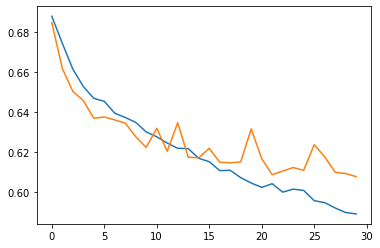

In [ ]:
plot_hist(hist)

In [ ]:
# visualizing losses and accuracy trained with lstm_shape = 16 and opt = Adam
def plot_hist(hist):
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(train_loss))


    _ = plt.figure()
    _ = plt.plot(xc, train_loss)
    _ = plt.plot(xc, val_loss)
    print('Min Val-Loss:',np.array(hist.history['val_loss']).min().round(3), '\nMax Val-Acc:',np.array(hist.history['val_accuracy']).max().round(3))

In [ ]:
lstm_shape = 12
drop = 0.2

# opt = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt = optimizers.Adadelta(learning_rate=1.0, rho=0.9)


model = Sequential()

model.add(LSTM(lstm_shape, input_shape = (X_train.shape[1:]), return_sequences=False))
model.add(Dropout(drop))
model.add(Dense(lstm_shape,activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(y_train.shape[1],activation = 'softmax'))

model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy'])

hist = model.fit(X_train, y_train, epochs=30, validation_data = (X_test,y_test), shuffle = True)

ar = np.hstack((lstm_shape,drop,model.evaluate(X_test,y_test)))
# log = log.append(pd.Series(ar,index =  ['lstm_shape','drop','loss','acc']),ignore_index=True,sort = False)
# log.to_csv('2020-03-11_logfile_LSTM.csv')

Train on 9340 samples, validate on 1000 samples
Epoch 1/30
9340/9340 [==============================] - 4s 382us/sample - loss: 0.6877 - accuracy: 0.5366 - val_loss: 0.6846 - val_accuracy: 0.5300
Epoch 2/30
9340/9340 [==============================] - 2s 204us/sample - loss: 0.6743 - accuracy: 0.5748 - val_loss: 0.6618 - val_accuracy: 0.5880
Epoch 3/30
9340/9340 [==============================] - 2s 206us/sample - loss: 0.6615 - accuracy: 0.5978 - val_loss: 0.6504 - val_accuracy: 0.6130
Epoch 4/30
9340/9340 [==============================] - 2s 200us/sample - loss: 0.6528 - accuracy: 0.6095 - val_loss: 0.6458 - val_accuracy: 0.6190
Epoch 5/30
9340/9340 [==============================] - 2s 205us/sample - loss: 0.6469 - accuracy: 0.6234 - val_loss: 0.6369 - val_accuracy: 0.6280
Epoch 6/30
9340/9340 [==============================] - 2s 203us/sample - loss: 0.6454 - accuracy: 0.6297 - val_loss: 0.6376 - val_accuracy: 0.6370
Epoch 7/30
9340/9340 [==============================] - 2s 208us

In [ ]:
hist = model.fit(X_train, y_train, epochs=5, validation_data = (X_test,y_test), shuffle = True)

Train on 9340 samples, validate on 1000 samples
Epoch 1/5
9340/9340 [==============================] - 2s 213us/sample - loss: 0.5661 - accuracy: 0.6934 - val_loss: 0.6159 - val_accuracy: 0.6620
Epoch 2/5
9340/9340 [==============================] - 2s 203us/sample - loss: 0.5653 - accuracy: 0.6995 - val_loss: 0.6294 - val_accuracy: 0.6550
Epoch 3/5
9340/9340 [==============================] - 2s 205us/sample - loss: 0.5632 - accuracy: 0.7015 - val_loss: 0.6519 - val_accuracy: 0.6370
Epoch 4/5
9340/9340 [==============================] - 2s 207us/sample - loss: 0.5644 - accuracy: 0.6989 - val_loss: 0.6356 - val_accuracy: 0.6450
Epoch 5/5
9340/9340 [==============================] - 2s 210us/sample - loss: 0.5613 - accuracy: 0.7037 - val_loss: 0.6140 - val_accuracy: 0.6640


Learnings so far
- for pure no-sequential output model lower lstm_shape is better around 16
- after 50-100 epochs little to no more average improvement, strong overfitting apparently
- max acc achieved ever 0.69
- dropout of 0.1 or 0.3 does not seem to make a huge difference
- seq to no-seq output works as well
- 14 vs. 28 max lines in X does not seem to make a huge difference, 14 maybe slightly better
- adam better than sgd
- lr adam smaller than 0.01, default is quite ok, potentially smaller if enough epochs are okay, this adamsgrad doenst make a big difference, tends to worsen stuff
- stateful seems to lead to more fluctuation but no general improvement
- good so far: adadelta with learn 1 and rho lower than adviced, epochs up to 70